In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import time
from copy import deepcopy
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold, StratifiedShuffleSplit, cross_val_score, cross_val_predict, GridSearchCV, LeaveOneOut
from sklearn.feature_selection import SelectFromModel, VarianceThreshold, SelectKBest, f_classif, chi2
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, confusion_matrix
from sklearn.preprocessing import Imputer, StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.pipeline import Pipeline
from scipy import stats
from sklearn.externals import joblib
from collections import Counter

In [3]:
import warnings
warnings.filterwarnings("ignore")

### Загрузка данных

In [4]:
labels = pd.read_csv("targets 22.03.2018.csv", sep=";")
mri_data = pd.read_csv("T1 morphometry merged 27.02.2018.csv",index_col=0)

In [5]:
idx_to_label = ["C", "D", "E", "DE", "NE", "ND", "TLE", "Positive", "Negative", "TLEPositive", "TLENegative", "NoTLE"]
label_to_idx = {l : i for i, l in enumerate(idx_to_label)}

for col in labels.columns[1:]:
    labels[col] = labels[col].apply(lambda x: label_to_idx[x] if x in label_to_idx else np.nan)
    
DE_idx = labels["target"].notnull()
E_idx = labels["E/no E"].notnull()
D_idx = labels["D/no D"].notnull()
E_C_idx = labels["E/C"].notnull()
TLE_noE_idx = labels["TLE/no E"].notnull()
TLE_C_idx = labels["TLE/C"].notnull()
D_C_idx = labels["D/C"].notnull()
DE_E_idx = labels["DE/E"].notnull()
Pos_Neg_idx = np.logical_and(labels["MRIPositive/Negative "].notnull(), labels["E/no E"] == label_to_idx["E"])
TLEPos_C_idx = labels["TLEPositive/C"].notnull()
TLENeg_C_idx = labels["TLENegative/C"].notnull()
NoTLE_C_idx = labels["NoTLE/C"].notnull()
# +
DE_D_idx = labels["D/no D"] == label_to_idx["D"]
labels["DE/D"] = labels["target"][DE_D_idx]

In [6]:
len(mri_data)

100

In [7]:
len(labels)

100

In [8]:
# отбор признаков на основе модели
# аналогично SelectFromModel, но на основе количества признаков, а не порога

from sklearn.base import BaseEstimator, MetaEstimatorMixin, clone
from sklearn.feature_selection.base import SelectorMixin
from sklearn.feature_selection.from_model import _get_feature_importances
from sklearn.utils.metaestimators import if_delegate_has_method

class SelectNFeaturesFromModel(BaseEstimator, SelectorMixin, MetaEstimatorMixin):
    def __init__(self, estimator, n_selected, prefit=False):
        self.estimator = estimator
        self.n_selected = n_selected
        self.prefit = prefit

    def _get_support_mask(self):
        if self.prefit:
            estimator = self.estimator
        elif hasattr(self, 'estimator_'):
            estimator = self.estimator_
        else:
            raise ValueError(
                'Either fit SelectFromModel before transform or set "prefit='
                'True" and pass a fitted estimator to the constructor.')
        scores = _get_feature_importances(estimator)
        threshold = np.sort(scores)[-self.n_selected]
        return scores >= threshold

    def fit(self, X, y=None, **fit_params):
        if self.prefit:
            raise NotFittedError(
                "Since 'prefit=True', call transform directly")
        self.estimator_ = clone(self.estimator)
        self.estimator_.fit(X, y, **fit_params)
        return self
    
    @property
    def scores_(self):
        scores = _get_feature_importances(self.estimator_,)
        return scores

    @property
    def threshold_(self):
        scores = _get_feature_importances(self.estimator_,)
        return np.sort(scores)[-n_selected]
    
    @if_delegate_has_method('estimator')
    def partial_fit(self, X, y=None, **fit_params):
        if self.prefit:
            raise NotFittedError(
                "Since 'prefit=True', call transform directly")
        if not hasattr(self, "estimator_"):
            self.estimator_ = clone(self.estimator)
        self.estimator_.partial_fit(X, y, **fit_params)
        return self

In [9]:
from sklearn.base import BaseEstimator, MetaEstimatorMixin, clone
from sklearn.feature_selection.base import SelectorMixin
from sklearn.feature_selection.from_model import _get_feature_importances
from sklearn.utils.metaestimators import if_delegate_has_method

class SelectFromGroups(BaseEstimator, SelectorMixin, MetaEstimatorMixin):
    # groups = True-False-mask for X columns (features)
    def __init__(self, method, groups=[]):
        self.method = method
        self.groups = groups
        self.methods = []
        self.supports = []
        
    def _get_support_mask(self):
#         if self.prefit:
#             estimator = self.estimator
#         elif hasattr(self, 'estimator_'):
#             estimator = self.estimator_
#         else:
#             raise ValueError(
#                 'Either fit SelectFromModel before transform or set "prefit='
#                 'True" and pass a fitted estimator to the constructor.')
#         scores = _get_feature_importances(estimator)
#         threshold = np.sort(scores)[-self.n_selected]
        return np.column_stack(supports)
        
    def fit(self, X, y):
        self.methods = []
        self.supports = []
        if not self.groups:
            n_features = X.shape[1]
            self.groups = [np.ones(n_features, dtype=bool)]
        for group in self.groups:
            self.method.fit(X[:, group], y)
            self.methods.append(deepcopy(self.method))
            self.supports.append(self.method.get_support())
                
    def fit_transform(self, X, y):
        self.methods = []
        self.supports = []
        transformed = []
        if not self.groups:
            n_features = X.shape[1]
            self.groups = [np.ones(n_features, dtype=bool)]
        for group in self.groups:
            transformed.append(self.method.fit_transform(X[:, group], y))
            self.methods.append(deepcopy(self.method))
            self.supports.append(self.method.get_support())
                
        return np.column_stack(transformed)
    def transform(self, X):
        transformed = []
        if not self.methods:
            self.method.transform(X)
        else:
            for group in self.groups:
                transformed.append(self.method.transform(X[:, group]))
        return np.column_stack(transformed)

In [10]:
def get_svc_grid(cv, dim_reduction_methods, scoring, random_state=None, n_jobs=1,
                 svc_kernel_l=None, svc_c_l=None, svc_gamma_l=None):

    pipe = Pipeline([
        ("Fill_NaN", Imputer(strategy="median")),
        ('StdScaler', StandardScaler()),
#         ("VarTh", VarianceThreshold()),
        ('dim_reduction', SelectKBest(stats.ttest_ind)),
        ('classifier', SVC(probability=True, random_state=random_state)),
    ])

    param_grid = {
        'dim_reduction': dim_reduction_methods,
    }
    if svc_kernel_l is not None:
        param_grid['classifier__kernel'] = svc_kernel_l
    if svc_c_l is not None:
        param_grid['classifier__C'] = svc_c_l
    if svc_gamma_l is not None:
        param_grid['classifier__gamma'] = svc_gamma_l
    
    return GridSearchCV(estimator=pipe, param_grid=param_grid, scoring=scoring, cv=cv, n_jobs=n_jobs)

In [11]:
def get_lr_grid(cv, dim_reduction_methods, scoring, random_state=None, n_jobs=1,
                 lr_c_l=None, lr_penalty_l=None):
    
    pipe = Pipeline([
        ("Fill_NaN", Imputer(strategy="median")),
        ('StdScaler', StandardScaler()),
#         ("VarTh", VarianceThreshold()),
        ('dim_reduction', SelectKBest(stats.ttest_ind)),
        ('classifier', LogisticRegression(random_state=random_state)),
    ])

    param_grid = {
        'dim_reduction': dim_reduction_methods,
    }
    if lr_c_l is not None:
        param_grid['classifier__C'] = lr_c_l
    if lr_penalty_l is not None:
        param_grid['classifier__penalty'] = lr_penalty_l
    
    return GridSearchCV(estimator=pipe, param_grid=param_grid, scoring=scoring, cv=cv, n_jobs=n_jobs)

In [12]:
def get_rfc_grid(cv, dim_reduction_methods, scoring, random_state=None, n_jobs=1,
                 rfc_n_estimators_l=None):
    
    pipe = Pipeline([
        ("Fill_NaN", Imputer(strategy="median")),
        ('StdScaler', StandardScaler()),
#         ("VarTh", VarianceThreshold()),
        ('dim_reduction', SelectKBest(stats.ttest_ind)),
        ('classifier', RandomForestClassifier(random_state=random_state)),
    ])

    param_grid = {
        'dim_reduction': dim_reduction_methods,
    }
    if rfc_n_estimators_l is not None:
        param_grid['classifier__n_estimators'] = rfc_n_estimators_l
    
    return GridSearchCV(estimator=pipe, param_grid=param_grid, scoring=scoring, cv=cv, n_jobs=n_jobs)

In [13]:
def get_knn_grid(cv, dim_reduction_methods, scoring, random_state=None, n_jobs=1,
                 knn_n_neighbors_l=None, knn_weights_l=None, knn_p_l=None):
    
    pipe = Pipeline([
        ("Fill_NaN", Imputer(strategy="median")),
        ('StdScaler', StandardScaler()),
#         ("VarTh", VarianceThreshold()),
        ('dim_reduction', SelectKBest(stats.ttest_ind)),
        ('classifier', KNeighborsClassifier()),
    ])

    param_grid = {
        'dim_reduction': dim_reduction_methods,
    }
    if knn_n_neighbors_l is not None:
        param_grid['classifier__n_neighbors'] = knn_n_neighbors_l
    if knn_weights_l is not None:
        param_grid['classifier__weights'] = knn_weights_l
    if knn_p_l is not None:
        param_grid['classifier__p'] = knn_p_l
    
    return GridSearchCV(estimator=pipe, param_grid=param_grid, scoring=scoring, cv=cv, n_jobs=n_jobs)

In [14]:
def get_gbc_grid(cv, dim_reduction_methods, scoring, random_state=None, n_jobs=1,
                 gbc_n_estimators_l=None): # мб нужно варьировать больше параметров
    
    pipe = Pipeline([
        ("Fill_NaN", Imputer(strategy="median")),
        ('StdScaler', StandardScaler()),
#         ("VarTh", VarianceThreshold()),
        ('dim_reduction', SelectKBest(stats.ttest_ind)),
        ('classifier', GradientBoostingClassifier(random_state=random_state)),
    ])

    param_grid = {
        'dim_reduction': dim_reduction_methods,
    }
    if gbc_n_estimators_l is not None:
        param_grid['classifier__n_estimators'] = gbc_n_estimators_l
    
    return GridSearchCV(estimator=pipe, param_grid=param_grid, scoring=scoring, cv=cv, n_jobs=n_jobs)

In [15]:
# set printoptions
pd.set_option('expand_frame_repr', True)
pd.set_option('max_colwidth', 150)

In [16]:
def print_results(clf_grid_dict, save_plot_to=None):
    results = {
            "classifier" : [], 
            "best parameters" : [],
            "best dim. reduction method" : [],
            "mean" : [],
            "std" : []
           }
    
    for clf, grid in clf_grid_dict.items():
        results["classifier"].append(clf)
        results["best parameters"].append(", ".join(
            [param + " = " + str(best_value) for param, best_value in grid.best_params_.items() if param != 'dim_reduction']))
        results["best dim. reduction method"].append(grid.best_params_['dim_reduction'])
        idx = grid.best_index_
        results["mean"].append(grid.cv_results_['mean_test_score'][idx])
        results["std"].append(grid.cv_results_['std_test_score'][idx])
        
    results = pd.DataFrame(results, columns=["classifier", "best parameters", "best dim. reduction method", "mean", "std"])
    display(results.set_index("classifier"))
    
    # draw graph
    width = 0.9
    for i in results.index:
        plt.bar(i, results.loc[i, "mean"], width, yerr=results.loc[i, "std"], label=results.loc[i, "classifier"])
    plt.xticks(range(results.shape[0]), results.loc[:, "classifier"])
    plt.axis(ymin=0.0, ymax=1.0)
    if save_plot_to is not None:
        plt.savefig(save_plot_to)
    plt.show()
    
    print("Best model: ")
    clf = results.loc[results["mean"].argmax(), "classifier"]
    print(clf)
    print("\n".join(
            [param + " = " + str(best_value) for param, best_value in clf_grid_dict[clf].best_params_.items()]))

### Объединенный подсчет и сравнение всех классификаторов (SVC, LR, RFC, KNN, GBC)

In [46]:
def train_grid_cv(X, y, n_splits, n_repeats, scoring, pos_label=None, random_state=None, n_jobs=1, features_groups=[], save_plot_to=None):
    cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=random_state)
    
    #n_features = [10, 20, 50, 100]
    n_features = [20]
    n_components = [10, 20]
    
    # list of dimensionality reduction methods
    dim_reduction_methods = []
    dim_reduction_methods += [SelectKBest(stats.ttest_ind, n) for n in n_features]
    dim_reduction_methods += [SelectKBest(f_classif, n) for n in n_features]
    dim_reduction_methods += [SelectNFeaturesFromModel(RandomForestClassifier(n_estimators=100, random_state=random_state), n) for n in n_features]
    dim_reduction_methods += [SelectNFeaturesFromModel(LogisticRegression(random_state=random_state), n) for n in n_features]
    dim_reduction_methods += [SelectNFeaturesFromModel(ExtraTreesClassifier(n_estimators=100, random_state=random_state), n) for n in n_features]
#     dim_reduction_methods += [PCA(n, random_state=random_state) for n in n_components]
#     dim_reduction_methods += [LocallyLinearEmbedding(n_components=n, random_state=random_state) for n in n_components]
    
    
    print("Target distribution: ")
    print(y.value_counts(), "\n")
    if pos_label is None:
        y_enc = pd.Series(LabelEncoder().fit_transform(y), index=y.index)
    else:
        y_enc = pd.Series(y == pos_label, dtype=int)
    
    print("Training SVC...")
    grid_cv_svc = get_svc_grid(cv, dim_reduction_methods, scoring, random_state=random_state, n_jobs=n_jobs,
                               svc_kernel_l=["rbf", "linear"],
                               svc_c_l=[10 ** i for i in range(0, 4, 1)],
                               svc_gamma_l=[10 ** i for i in range(-3, -1, 1)])
    start_time = time.time()
    grid_cv_svc.fit(X, y_enc)
    print("(training took {}s)\n".format(time.time() - start_time))
    
    print("Training LR...")
    grid_cv_lr = get_lr_grid(cv, dim_reduction_methods, scoring, random_state=random_state, n_jobs=n_jobs,
                             lr_c_l=[10 ** i for i in range(-4, -1, 1)],
                             lr_penalty_l=["l1", "l2"])
    start_time = time.time()
    grid_cv_lr.fit(X, y_enc)
    print("(training took {}s)\n".format(time.time() - start_time))
    
    print("Training RFC...")
    grid_cv_rfc = get_rfc_grid(cv, dim_reduction_methods, scoring, random_state=random_state, n_jobs=n_jobs,
                               rfc_n_estimators_l=[i for i in range(100, 210, 30)])
    start_time = time.time()
    grid_cv_rfc.fit(X, y_enc)
    print("(training took {}s)\n".format(time.time() - start_time))
    
    print("Training KNN...")
    class_size_tr = min(y.value_counts())
    grid_cv_knn = get_knn_grid(cv, dim_reduction_methods, scoring, random_state=random_state, n_jobs=n_jobs,
                              knn_p_l=[1, 2],
                              knn_weights_l=["uniform", "distance"],
                              knn_n_neighbors_l=[i for i in range(5, class_size_tr - 1, 3)])
    start_time = time.time()
    grid_cv_knn.fit(X, y_enc)
    print("(training took {}s)\n".format(time.time() - start_time))

    
    print("Scoring:", scoring)
    print_results({
        "SVC" : grid_cv_svc,
        "LR" : grid_cv_lr,
        "RFC" : grid_cv_rfc,
        "KNN" : grid_cv_knn,
                  }, save_plot_to=save_plot_to)
    
    best_model = max([grid_cv_svc, grid_cv_lr, grid_cv_rfc, grid_cv_knn], key=lambda x: x.best_score_).best_estimator_
    
    return best_model, grid_cv_svc, grid_cv_lr, grid_cv_rfc, grid_cv_knn

In [18]:
n_objects = mri_data.shape[0]

def repeated_cross_val_predict(estimator, X, y, cv, file=None):
    predictions = [[] for i in range(n_objects)]
    for idx_tr, idx_te in tqdm(cv.split(X, y)):
        estimator.fit(X.iloc[idx_tr], y.iloc[idx_tr])
        pred_te = np.array(estimator.predict(X.iloc[idx_te]), dtype=int)
        for i, idx in enumerate(idx_te):
            predictions[X.index[idx]].append(idx_to_label[pred_te[i]])
        
    predictions = pd.DataFrame(predictions)
    if file is not None:
        predictions.to_csv(file)
        
    return predictions

In [19]:
n_objects = mri_data.shape[0]

def repeated_cross_val_predict_proba(estimator, X, y, cv, pos_label=None, file=None):
    
    if pos_label is None:
        y_enc = pd.Series(LabelEncoder().fit_transform(y), index=y.index)
    else:
        y_enc = pd.Series(y == pos_label, dtype=int)
    predictions = [[] for i in range(n_objects)]
    for idx_tr, idx_te in tqdm(cv.split(X, y_enc)):
        estimator.fit(X.iloc[idx_tr], y_enc.iloc[idx_tr])
        pred_te = np.array(estimator.predict_proba(X.iloc[idx_te]), dtype=float)
        for i, idx in enumerate(idx_te):
            predictions[X.index[idx]].append(pred_te[i, 1])
        
    predictions = pd.DataFrame(predictions)
    if file is not None:
        predictions.to_csv(file)
        
    return predictions

In [20]:
def save_model(model, file):
    joblib.dump(model, file)
    
def load_model(file):
    model = joblib.load(file)
    return model

In [21]:
def plot_roc_curve(y, probas, idx, average_repeats=False, show=True):
    if average_repeats:
        y_true = y
        y_score = probas[idx].mean(axis=1)
    else:
        n_repeats = probas.shape[1]
        y_true = pd.Series(np.tile(y, (n_repeats)), dtype=int)
        y_score = probas[idx].values.T.reshape(-1, 1)
    fpr, tpr, t = roc_curve(y_true=y_true, y_score=y_score)
    
    if show:
        plt.figure(figsize=(12, 8))
        plt.plot(fpr, tpr)
        plt.xlabel("False Positive rate", fontsize=14)
        plt.ylabel("True Positive rate", fontsize=14)
        plt.show()
        print("auc =", roc_auc_score(y_true, y_score))
        
    return fpr, tpr, t

In [22]:
def get_fixed_fpr_threshold(fpr, t, fix_fpr=0):
    return t[fpr <= fix_fpr][-1]

In [23]:
def get_fpr_fnr(fpr, tpr, fix_fpr_l=[0.1, 0.15, 0.2, 0.3]):
    fnr_l = []
    for fix_fpr in fix_fpr_l:
        fnr_l.append(1 - tpr[fpr <= fix_fpr][-1])
    fpr_fnr_table = pd.DataFrame(np.column_stack((fix_fpr_l, fnr_l)), columns=["False Positive rate (fixed)", "False Negative rate"])
    display(fpr_fnr_table)
    return fpr_fnr_table

In [24]:
# сейчас работает только для одномерных векторов вероятностей (одно предсказание для каждого объекта, напр. leave one out)
def get_incorrectly_classified(y, probas, idx, fpr, t, fix_fpr_l=[0.1, 0.15, 0.2, 0.3], file=None, show=True):
    columns = ["False Positive rate (fixed)", "Threshold", "False Positives indexes", "False Negatives indexes"]
    t_l = []
    false_0 = []
    false_1 = []
    for fix_fpr in fix_fpr_l:
        fix_t = t[fpr <= fix_fpr][-1]
        t_l.append(fix_t)
        labels_t = probas > fix_t
        labels_t = pd.Series(labels_t.values.ravel())
        false_0.append(", ".join(list(labels.loc[(probas[idx][np.logical_and(labels_t[idx] == 0, y == 1)]).index, "patient_number"])))
        false_1.append(", ".join(list(labels.loc[(probas[idx][np.logical_and(labels_t[idx] == 1, y == 0)]).index, "patient_number"])))
              
    t_l = np.array(t_l)
    false_0 = np.array(false_0)
    false_1 = np.array(false_1)
    
    res = pd.DataFrame(np.column_stack((fix_fpr_l, t_l)), columns=columns[:2])
    res["False Positives indexes"] = false_1
    res["False Negatives indexes"] = false_0
    
    if file is not None:
        res.to_csv(file)
        
    if show:
        display(res)
    return res

In [25]:
def get_features(X, y, model):
    model.fit(X, y)
#     var_th = model.named_steps['VarTh']
#     var_th_features_idx = var_th.get_support()
    dim_reduction = model.named_steps["dim_reduction"]
    features_idx = dim_reduction.get_support()
#     classifier = model.named_steps["classifier"]
#     features_weights = classifier.coef_[0]
    features = X.columns[features_idx].tolist()
    return features

In [26]:
def get_feature_sets_on_cross_val(X, y, model, cv):
    feature_sets = []
    for idx_tr, idx_te in tqdm(cv.split(X, y)):
        X_tr = X.loc[X.index[idx_tr]]
        y_tr = y.loc[X.index[idx_tr]]
        y_te = y.loc[X.index[idx_te]]
        feature_sets.append(get_features(X_tr, y_tr, model))
    return feature_sets

In [27]:
def get_frequent_features(features_l, classifier_l, y, p=0.5, min_common=3, file_all=None, file_frequent=None):
    for i, features in enumerate(features_l):
        features["frequency_norm"] = features["frequency"] / y.size
        features["classifier"] = classifier_l[i]
    
    all_features = pd.concat([features.drop("frequency", axis=1) for features in features_l], axis=0)
    all_features = all_features.reset_index().set_index("classifier")
    all_features.columns = ["feature", "frequency_norm"]
    
    if file_all is not None:
        all_features.to_csv(file_all)
        
    frequent_features = pd.DataFrame(all_features[all_features.frequency_norm > p]["feature"].value_counts())
    if file_frequent is not None:
        frequent_features.to_csv(file_frequent)
    
    common_frequent_features = frequent_features[frequent_features["feature"] >= min_common].index.tolist()
    
    return all_features, frequent_features, common_frequent_features

In [28]:
def get_frequent_indexes(probas_l, classifiers_l, y, idx, show=False, file=None):
    incorr_classified_l = []
    for i, probas in enumerate(probas_l):
        fpr, tpr, t = plot_roc_curve(y, probas, idx, show=show)
        incorr_classified = get_incorrectly_classified(y, probas, idx, fpr, t, show=show)
        incorr_classified["classifier"] = classifiers_l[i]
        incorr_classified_l.append(incorr_classified)
        
    all_incorr_classified = pd.concat(incorr_classified_l, axis=0)
    all_incorr_classified.set_index("classifier", inplace=True)
    
    if file is not None:
        all_incorr_classified.to_csv(file)
    
    max_fpr = all_incorr_classified["False Positive rate (fixed)"].max()
    common_false_positives = Counter(list((", ".join(all_incorr_classified[all_incorr_classified["False Positive rate (fixed)"] == max_fpr]["False Positives indexes"].tolist())).split(", ")))
    data=pd.DataFrame(common_false_positives,index=[0]).T
    common_false_positives_ =", ".join(data[data[0]>=3].index)    
    
    min_fpr = all_incorr_classified["False Positive rate (fixed)"].min()
    common_false_negatives = Counter(list((", ".join(all_incorr_classified[all_incorr_classified["False Positive rate (fixed)"] == min_fpr]["False Negatives indexes"].tolist())).split(", ")))
    data=pd.DataFrame(common_false_negatives,index=[0]).T
    common_false_negatives_ =", ".join(data[data[0]>=3].index)
    
    return all_incorr_classified, common_false_positives_, common_false_negatives_

In [29]:
def get_frequent_regions(all_features, n=0.0, importance=0.5):
    freq_list=all_features[all_features['frequency_norm']>=n]
    freq_list=freq_list.reset_index()
    freq_list['feature_pure']=''
    freq_list['feature_score']=''
    appendix_list_thick=['_NumVert','_GrayVol','_FoldInd','_CurvInd','_GausCurv','_ThickStd','_ThickAvg','_MeanCurv','_SurfArea']
    appendix_list_vol=['_Volume_mm3','_normMean','_normMin','_normMax','_normStdDev','_normRange','_NVoxels']
    for i in range(len(freq_list)):
        for j in appendix_list_thick:
            if j in freq_list['feature'].loc[i]:
                freq_list['feature_pure'].loc[i]=freq_list['feature'].loc[i].replace(j, '')
                freq_list['feature_score'].loc[i]=freq_list['frequency_norm'].loc[i]/9
        for k in appendix_list_vol:
            if k in freq_list['feature'].loc[i]:
                freq_list['feature_pure'].loc[i]=freq_list['feature'].loc[i].replace(k, '')
                freq_list['feature_score'].loc[i]=freq_list['frequency_norm'].loc[i]/7

    freq_pure_list=freq_list[['feature_pure','feature_score']].groupby(['feature_pure']).sum()
    freq_pure_list=freq_pure_list.sort_values(['feature_score'], ascending=False)
    freq_pure_list=freq_pure_list[freq_pure_list['feature_score']>=freq_pure_list['feature_score'].max()*importance]
    print (freq_pure_list)

In [30]:
# now going with test train validate
def select_features_on_cross_val(cv, X_tr, y_tr, random_state=None):
    # отбираем признаки    
    # сохраняем все признаки с весами (для каждой итерации RepeatedKFold)
    features_l = []
    for i_tr, i_te in cv.split(X_tr, y_tr):
        
        selector = SelectKBest(score_func=f_classif, k=150)
        selector.fit(X_tr.loc[X_tr.index[i_tr]], y_tr[X_tr.index[i_tr]])
        features_idx = selector.get_support()
        features = X_tr.columns[features_idx].tolist()
#         selector = LogisticRegression(penalty='l1', random_state=random_state)
#         selector.fit(X_tr.loc[X_tr.index[i_tr]], y_tr[X_tr.index[i_tr]])
#         features_weights = selector.coef_[0]
#         features = pd.DataFrame(sorted(list(zip(X_tr.columns, features_weights)), 
#                         key=lambda x: -abs(x[1])), columns=["feature", "weight (from classifier)"])
#         # оставляем только признаки с ненулевыми весами
#         features = features.loc[features["weight (from classifier)"] != 0, "feature"].values.tolist()
        features_l.append(features)

    # оставляем только признаки, которые вошли во все множества 
    selected_features = list(reduce(lambda x, y: set(x) & set(y), features_l))
#     print(selected_features)

    # оставляем области, которые вошли во все множества
    regions_l = list(map(lambda x: list(map(get_feature_region, x)), features_l))
    selected_regions = list(reduce(lambda x, y: set(x) & set(y), regions_l))
#     print(selected_regions)
    
    # выбираем все признаки для этих областей
    selected = []
    for region in selected_regions:
        for feature_type in types:
            feature = region + "_" + feature_type
            if feature in all_features:
                selected.append(feature)
    
    return selected

def cross_val_feature_selection_test(X, y, pos_label, estimator, n_splits_outer=5, n_repeats_outer=10, 
                                     n_splits=5, n_repeats=10, scoring="roc_auc", random_state=None):
    cv_outer = RepeatedStratifiedKFold(n_splits=n_splits_outer, n_repeats=n_repeats_outer, random_state=random_state)
    cv_score_tr = []
    score_te = []    
    # отложим часть данных для теста
    for idx_tr, idx_te in tqdm(cv_outer.split(X, y)):
        X_tr = X.loc[X.index[idx_tr]]
        X_te = X.loc[X.index[idx_te]]
        y_tr = y.loc[X.index[idx_tr]]
        y_te = y.loc[X.index[idx_te]]
        
        cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=random_state)
        selected = select_features_on_cross_val(cv, X_tr, y_tr, random_state)
        print(selected)
        
        # качество на той части выборки, где признаки были выбраны
        cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=random_state)
        scores_selected = cross_val_score(estimator, X_tr[selected], pd.Series(y_tr == pos_label, dtype=np.int), cv=cv, scoring=scoring)
        cv_score_tr += scores_selected.tolist()

        # test
        # обучаем на всей выборке (train) 
        estimator.fit(X_tr[selected], pd.Series(y_tr == pos_label, dtype=np.int))
        # оцениваем на отложенной части (test)
        score_selected_test = roc_auc_score(pd.Series(y_te == pos_label, dtype=np.int), estimator.predict_proba(X_te[selected])[:, 1])
        score_te.append(score_selected_test)
        
    return cv_score_tr, score_te

### Training

In [31]:
labels.head()

,patient_number,target,E/no E,D/no D,E/C,TLE/no E,TLE/C,D/C,DE/E,MRIPositive/Negative,TLEPositive/C,TLENegative/C,NoTLE/C,TLEPositive/Negative,DE/D
0,P001,2,2,5,2.0,6.0,6.0,NaN,2.0,8.0,NaN,10.0,NaN,8.0,NaN
1,P002,3,2,1,NaN,NaN,NaN,NaN,3.0,8.0,NaN,NaN,11.0,NaN,3.0
2,P003,2,2,5,2.0,6.0,6.0,NaN,2.0,7.0,9.0,NaN,NaN,7.0,NaN
3,P004,1,4,1,NaN,4.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0
4,P006,2,2,5,2.0,NaN,NaN,NaN,2.0,8.0,NaN,NaN,11.0,NaN,NaN


In [32]:
# some metrics (e.g. f1_score) can not be used for multiclass classification and require micro/macro averaging
# scoring, scoring_multiclass = "f1", "f1_micro"
classifiers_l = ["svc", "lr", "rfc", "knn"]
scoring = "roc_auc"
# other variants
# scoring, scoring_multiclass = "accuracy", "accuracy"

### 2. Epilepsy / no epilepsy

Target distribution: 
1    50
0    50
Name: E/no E, dtype: int64 

Training SVC...
(training took 7053.688889741898s)

Training LR...
(training took 579.7779228687286s)

Training RFC...
(training took 1000.9753143787384s)

Training KNN...
(training took 4034.818870782852s)

Scoring: roc_auc


,best parameters,best dim. reduction method,mean,std
classifier,,,,
SVC,"classifier__C = 1, classifier__gamma = 0.001, classifier__kernel = rbf","SelectKBest(k=100, score_func=<function ttest_ind at 0x000001987D0F8B70>)",0.7272,0.184814
LR,"classifier__C = 0.01, classifier__penalty = l2","SelectKBest(k=100, score_func=<function ttest_ind at 0x000001987D0F8B70>)",0.7200,0.177989
RFC,classifier__n_estimators = 130,"SelectKBest(k=100, score_func=<function ttest_ind at 0x000001987D0F8B70>)",0.7268,0.178823
KNN,"classifier__n_neighbors = 32, classifier__p = 1, classifier__weights = distance","SelectNFeaturesFromModel(estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',\n max_depth=None, max_feat...",0.7104,0.182702


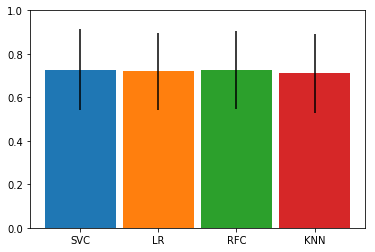

Best model: 
SVC
classifier__C = 1
classifier__gamma = 0.001
classifier__kernel = rbf
dim_reduction = SelectKBest(k=100, score_func=<function ttest_ind at 0x000001987D0F8B70>)


In [32]:
n_splits = 10
problem = "E_NE"
problem_labels = "E/no E"
pos_label = label_to_idx["E"]
idx = E_idx
X, y = mri_data, pd.Series(labels[idx][problem_labels] == pos_label, dtype=int)

best_model_mri_E, grid_cv_svc_mri_E, grid_cv_lr_mri_E, grid_cv_rfc_mri_E, grid_cv_knn_mri_E= train_grid_cv(
    X, y, n_splits=n_splits, n_repeats=5, scoring=scoring, random_state=42, n_jobs=1)

In [34]:
classifier_l = ["svc", "lr", "rfc", "knn"]
grid_cv_l = [grid_cv_svc_mri_E, grid_cv_lr_mri_E, grid_cv_rfc_mri_E, grid_cv_knn_mri_E]
best_model_l = [x.best_estimator_ for x in grid_cv_l]
for i, clf in enumerate(classifiers_l):
    save_model(best_model_l[i], "T1_sMRI_{}_best_{}.pkl".format(problem, clf))
save_model(best_model_mri_E, "T1_sMRI_{}.pkl".format(problem))    
    
probas_l = [repeated_cross_val_predict_proba(best_model, X, y, cv=LeaveOneOut(), file="{}_probas_mri_{}.csv".format(classifiers_l[i], problem)) for i, best_model in enumerate(best_model_l)]
feature_sets_l = [get_feature_sets_on_cross_val(X, y, best_model, cv=LeaveOneOut()) for best_model in best_model_l]
features_l = [pd.DataFrame(pd.DataFrame(data=feature_set).stack().reset_index(drop=True).value_counts(), columns=['frequency']) for feature_set in feature_sets_l]

100it [00:02, 43.41it/s]
100it [00:01, 72.13it/s]
100it [00:20,  4.78it/s]
100it [00:15,  6.46it/s]
100it [00:02, 38.48it/s]
100it [00:01, 50.95it/s]
100it [00:26,  3.73it/s]
100it [00:16,  6.10it/s]


Pipeline(memory=None,
     steps=[('Fill_NaN', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), ('StdScaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('dim_reduction', SelectKBest(k=100, score_func=<function ttest_ind at 0x000001987D0F8B70>)), ('classifier', SVC(C=1, cache_si...bf',
  max_iter=-1, probability=True, random_state=42, shrinking=True,
  tol=0.001, verbose=False))])


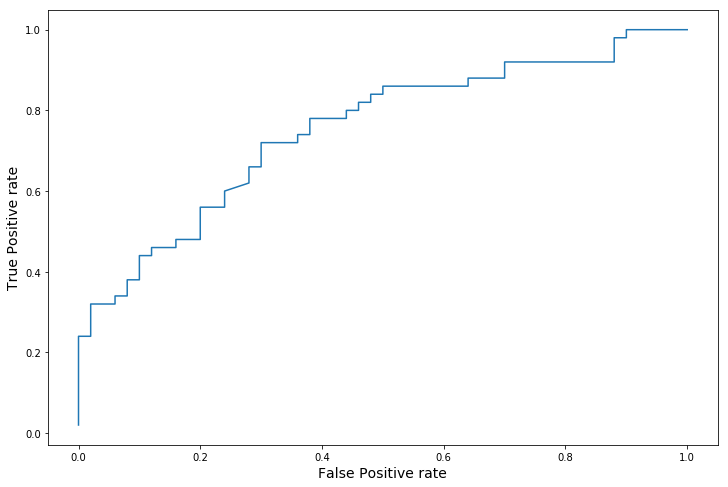

auc = 0.7508


,False Positive rate (fixed),False Negative rate
0,0.10,0.56
1,0.15,0.54
2,0.20,0.44
3,0.30,0.28


,False Positive rate (fixed),Threshold,False Positives indexes,False Negatives indexes
0,0.10,0.586462,"P035, P051, P077, P093, P098","P006, P009, P011, P015, P017, P024, P026, P034, P038, P040, P045, P048, P049, P050, P056, P057, P059, P061, P068, P073, P074, P081, P083, P084, P0..."
1,0.15,0.570816,"P035, P051, P053, P077, P093, P098","P006, P009, P011, P015, P017, P024, P026, P034, P040, P045, P048, P049, P050, P056, P057, P059, P061, P068, P073, P074, P081, P083, P084, P087, P0..."
2,0.20,0.526099,"P008, P021, P035, P036, P041, P051, P053, P077, P093, P098","P009, P015, P017, P024, P026, P034, P040, P045, P048, P049, P050, P056, P057, P059, P061, P068, P073, P074, P081, P083, P084, P094, P096"
3,0.30,0.479702,"P008, P013, P019, P020, P021, P035, P036, P041, P043, P047, P051, P053, P077, P093, P098","P009, P015, P026, P045, P049, P050, P056, P061, P068, P073, P074, P081, P084, P094, P096"


,frequency
lingual_GausCurv_r,97
inferiortemporal_ThickAvg_l,96
bankssts_ThickAvg_l,95
lateraloccipital_GausCurv_l,93
inferiortemporal_MeanCurv_r,93
Left-Accumbens-area_normMax,89
cuneus_ThickAvg_l,86
superiorfrontal_MeanCurv_l,85
lateraloccipital_GausCurv_r,84
Left-Putamen_normMax,83


Pipeline(memory=None,
     steps=[('Fill_NaN', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), ('StdScaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('dim_reduction', SelectKBest(k=100, score_func=<function ttest_ind at 0x000001987D0F8B70>)), ('classifier', LogisticRegressio...alty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])


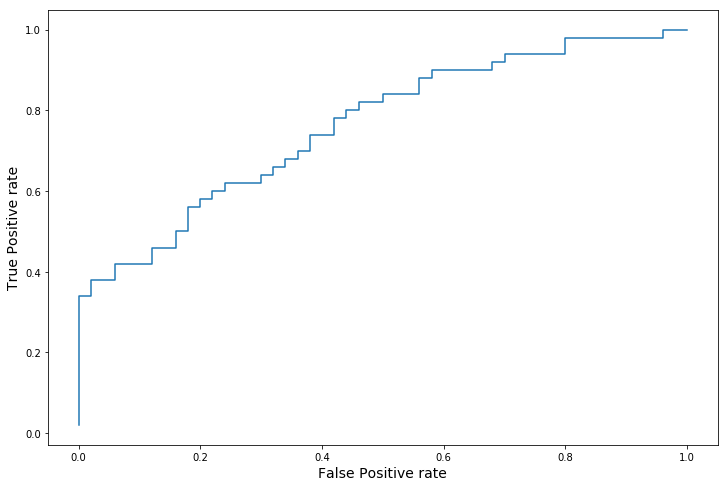

auc = 0.7624


,False Positive rate (fixed),False Negative rate
0,0.10,0.58
1,0.15,0.54
2,0.20,0.42
3,0.30,0.36


,False Positive rate (fixed),Threshold,False Positives indexes,False Negatives indexes
0,0.10,0.602058,"P051, P093, P098","P006, P009, P011, P015, P017, P024, P026, P034, P038, P040, P045, P048, P049, P050, P056, P057, P059, P061, P068, P073, P074, P079, P081, P083, P0..."
1,0.15,0.574134,"P021, P035, P051, P077, P093, P098","P006, P009, P011, P015, P017, P024, P026, P034, P038, P040, P045, P048, P049, P050, P056, P057, P059, P061, P068, P073, P074, P081, P083, P084, P0..."
2,0.20,0.498748,"P013, P021, P035, P036, P043, P047, P051, P077, P093, P098","P006, P009, P015, P017, P024, P026, P040, P045, P048, P049, P050, P056, P057, P059, P061, P068, P073, P074, P081, P084, P094, P096"
3,0.30,0.488502,"P012, P013, P016, P019, P021, P035, P036, P043, P047, P051, P053, P065, P077, P093, P098","P009, P015, P024, P026, P040, P045, P048, P049, P050, P056, P057, P059, P061, P068, P073, P074, P081, P094, P096"


,frequency
lingual_GausCurv_r,97
inferiortemporal_ThickAvg_l,96
bankssts_ThickAvg_l,95
lateraloccipital_GausCurv_l,93
inferiortemporal_MeanCurv_r,93
Left-Accumbens-area_normMax,89
cuneus_ThickAvg_l,86
superiorfrontal_MeanCurv_l,85
lateraloccipital_GausCurv_r,84
Left-Putamen_normMax,83


Pipeline(memory=None,
     steps=[('Fill_NaN', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), ('StdScaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('dim_reduction', SelectKBest(k=100, score_func=<function ttest_ind at 0x000001987D0F8B70>)), ('classifier', RandomForestClass...timators=130, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False))])


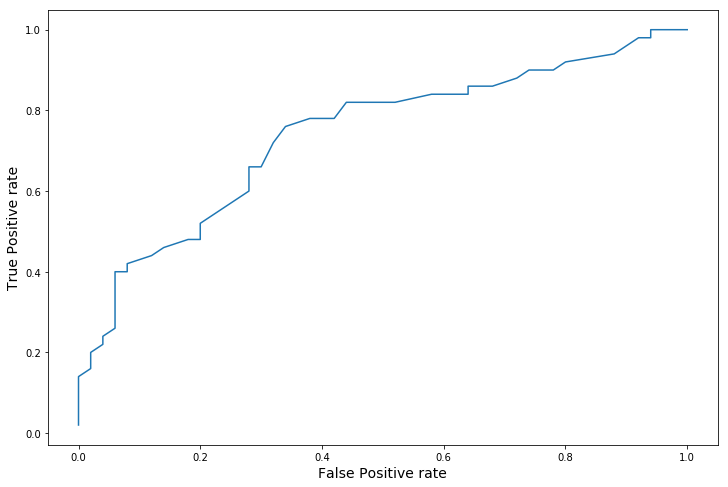

auc = 0.7387999999999999


,False Positive rate (fixed),False Negative rate
0,0.10,0.58
1,0.15,0.54
2,0.20,0.48
3,0.30,0.34


,False Positive rate (fixed),Threshold,False Positives indexes,False Negatives indexes
0,0.10,0.584615,"P051, P077, P093, P098","P002, P009, P011, P015, P017, P022, P024, P026, P034, P038, P040, P045, P048, P049, P050, P056, P057, P061, P068, P073, P074, P079, P081, P083, P0..."
1,0.15,0.569231,"P035, P036, P051, P077, P093, P098","P002, P009, P015, P017, P022, P024, P026, P034, P038, P040, P045, P048, P049, P050, P057, P061, P068, P073, P074, P079, P081, P083, P084, P086, P0..."
2,0.20,0.546154,"P008, P021, P035, P036, P047, P051, P053, P077, P093, P098","P002, P009, P015, P017, P022, P024, P026, P034, P038, P040, P045, P048, P049, P050, P061, P068, P073, P074, P079, P081, P083, P084, P088, P094, P0..."
3,0.30,0.492308,"P008, P013, P021, P035, P036, P041, P043, P047, P051, P053, P070, P077, P093, P098","P009, P015, P017, P024, P026, P040, P048, P049, P050, P061, P068, P073, P074, P081, P094, P096, P099"


,frequency
lingual_GausCurv_r,97
inferiortemporal_ThickAvg_l,96
bankssts_ThickAvg_l,95
lateraloccipital_GausCurv_l,93
inferiortemporal_MeanCurv_r,93
Left-Accumbens-area_normMax,89
cuneus_ThickAvg_l,86
superiorfrontal_MeanCurv_l,85
lateraloccipital_GausCurv_r,84
Left-Putamen_normMax,83


Pipeline(memory=None,
     steps=[('Fill_NaN', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), ('StdScaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('dim_reduction', SelectNFeaturesFromModel(estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini'...ski',
           metric_params=None, n_jobs=1, n_neighbors=32, p=1,
           weights='distance'))])


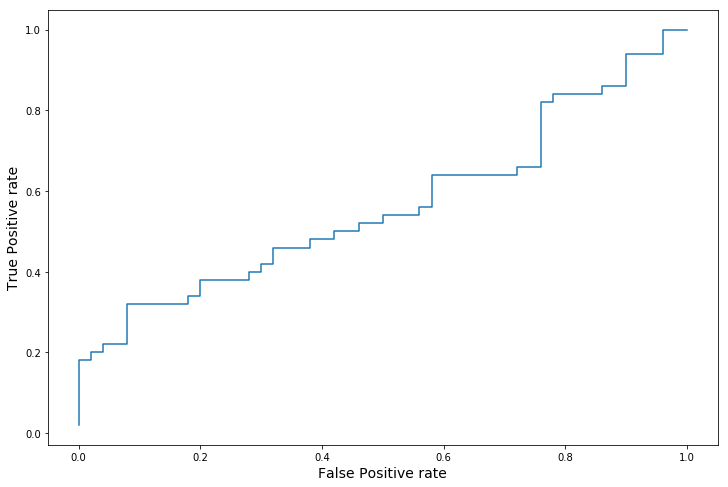

auc = 0.5636


,False Positive rate (fixed),False Negative rate
0,0.10,0.68
1,0.15,0.68
2,0.20,0.62
3,0.30,0.58


,False Positive rate (fixed),Threshold,False Positives indexes,False Negatives indexes
0,0.10,0.412549,"P020, P051, P093, P108","P006, P009, P011, P015, P017, P022, P024, P026, P034, P038, P040, P045, P048, P049, P050, P056, P057, P059, P061, P068, P072, P073, P074, P075, P0..."
1,0.15,0.412549,"P020, P051, P093, P108","P006, P009, P011, P015, P017, P022, P024, P026, P034, P038, P040, P045, P048, P049, P050, P056, P057, P059, P061, P068, P072, P073, P074, P075, P0..."
2,0.20,0.382993,"P012, P020, P051, P052, P053, P062, P063, P065, P093, P108","P006, P009, P011, P015, P017, P022, P024, P026, P034, P038, P040, P045, P048, P049, P050, P056, P057, P059, P061, P068, P072, P073, P074, P075, P0..."
3,0.30,0.367766,"P008, P012, P020, P028, P051, P052, P053, P060, P062, P063, P065, P082, P090, P093, P108","P006, P009, P011, P015, P017, P022, P024, P026, P034, P038, P040, P045, P049, P050, P056, P057, P059, P061, P068, P072, P073, P074, P075, P081, P0..."


,frequency
rostralmiddlefrontal_GausCurv_r,100
frontalpole_GausCurv_l,100
cuneus_FoldInd_l,100
fusiform_GausCurv_l,100
pericalcarine_ThickAvg_r,100
Left-Caudate_normStdDev,100
rostralmiddlefrontal_NumVert_l,100
fusiform_CurvInd_l,100
parsopercularis_MeanCurv_r,100
Right-Caudate_normMax,99


In [35]:
for i in range(len(best_model_l)):
    print(best_model_l[i])
    fpr, tpr, t = plot_roc_curve(y, probas_l[i], idx)
    get_fpr_fnr(fpr, tpr)
    get_incorrectly_classified(y, probas_l[i], idx, fpr, t)
    display(features_l[i].iloc[:10])

In [36]:
all_features, frequent_features, common_frequent_features = get_frequent_features(features_l, classifiers_l, y, p=0.7)
display(frequent_features.iloc[:10])
print("common_frequent_features: " + ", ".join(common_frequent_features))

,feature
Right-Cerebellum-White-Matter_normMean,3
Right-Thalamus-Proper_normMean,3
Left-Accumbens-area_normMax,3
lateraloccipital_GausCurv_l,3
postcentral_ThickAvg_l,3
lingual_GausCurv_r,3
superiorfrontal_MeanCurv_l,3
CC_Mid_Posterior_normMean,3
isthmuscingulate_ThickAvg_l,3
Right-Pallidum_normMean,3


common_frequent_features: Right-Cerebellum-White-Matter_normMean, Right-Thalamus-Proper_normMean, Left-Accumbens-area_normMax, lateraloccipital_GausCurv_l, postcentral_ThickAvg_l, lingual_GausCurv_r, superiorfrontal_MeanCurv_l, CC_Mid_Posterior_normMean, isthmuscingulate_ThickAvg_l, Right-Pallidum_normMean, lateraloccipital_GausCurv_r, entorhinal_ThickAvg_l, isthmuscingulate_MeanCurv_l, CC_Anterior_normMean, Right-Thalamus-Proper_normMax, bankssts_ThickAvg_l, cuneus_ThickAvg_l, inferiortemporal_MeanCurv_r, caudalanteriorcingulate_ThickAvg_l, Left-Putamen_normMax, supramarginal_MeanCurv_r, inferiortemporal_ThickAvg_l, lateraloccipital_MeanCurv_r


In [37]:
all_incorr_classified, common_false_positives, common_false_negatives = get_frequent_indexes(probas_l, classifiers_l, y, idx, show=False)
print('False positives for more than 3 clsf',common_false_positives)
print('False negatives for more than 3 clsf',common_false_negatives)

False positives for more than 3 clsf P008, P013, P021, P035, P036, P043, P047, P051, P053, P077, P093, P098
False negatives for more than 3 clsf P006, P009, P011, P015, P017, P024, P026, P034, P038, P040, P045, P048, P049, P050, P056, P057, P059, P061, P068, P073, P074, P079, P081, P083, P084, P087, P088, P094, P096, P099


### 3. Depression / no depression

Target distribution: 
1    50
0    50
Name: D/no D, dtype: int64 

Training SVC...
(training took 77559.45247578621s)

Training LR...
(training took 539.3406386375427s)

Training RFC...
(training took 448.39318466186523s)

Training KNN...
(training took 4432.990548610687s)

Scoring: roc_auc


,best parameters,best dim. reduction method,mean,std
classifier,,,,
SVC,"classifier__C = 10, classifier__gamma = 0.1, classifier__kernel = rbf","SelectKBest(k=10, score_func=<function ttest_ind at 0x0000024E8F185B70>)",0.4960,0.162185
LR,"classifier__C = 0.001, classifier__penalty = l2","SelectKBest(k=100, score_func=<function ttest_ind at 0x0000024E8F185B70>)",0.5176,0.169217
RFC,classifier__n_estimators = 180,"SelectKBest(k=20, score_func=<function ttest_ind at 0x0000024E8F185B70>)",0.5220,0.186730
KNN,"classifier__n_neighbors = 44, classifier__p = 1, classifier__weights = distance","SelectKBest(k=100, score_func=<function ttest_ind at 0x0000024E8F185B70>)",0.5296,0.180410


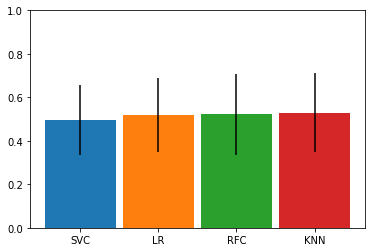

Best model: 
KNN
classifier__n_neighbors = 44
classifier__p = 1
classifier__weights = distance
dim_reduction = SelectKBest(k=100, score_func=<function ttest_ind at 0x0000024E8F185B70>)


In [40]:
n_splits = 10
problem = "D_ND"
problem_labels = "D/no D"
pos_label = label_to_idx["D"]
idx = D_idx
X, y = mri_data, pd.Series(labels[idx][problem_labels] == pos_label, dtype=int)

best_model_mri_D, grid_cv_svc_mri_D, grid_cv_lr_mri_D, grid_cv_rfc_mri_D, grid_cv_knn_mri_D= train_grid_cv(
    X, y, n_splits=n_splits, n_repeats=5, scoring=scoring, random_state=42, n_jobs=1)

In [41]:
grid_cv_l = [grid_cv_svc_mri_D, grid_cv_lr_mri_D, grid_cv_rfc_mri_D, grid_cv_knn_mri_D]
best_model_l = [x.best_estimator_ for x in grid_cv_l]
for i, clf in enumerate(classifiers_l):
    save_model(best_model_l[i], "T1_sMRI_{}_best_{}.pkl".format(problem, clf))
save_model(best_model_mri_D, "T1_sMRI_{}.pkl".format(problem))    
    
probas_l = [repeated_cross_val_predict_proba(best_model, X, y, cv=LeaveOneOut(), file="{}_probas_mri_{}.csv".format(classifiers_l[i], problem)) for i, best_model in enumerate(best_model_l)]
feature_sets_l = [get_feature_sets_on_cross_val(X, y, best_model, cv=LeaveOneOut()) for best_model in best_model_l]
features_l = [pd.DataFrame(pd.DataFrame(data=feature_set).stack().reset_index(drop=True).value_counts(), columns=['frequency']) for feature_set in feature_sets_l]

100it [00:02, 38.85it/s]
100it [00:01, 57.46it/s]
100it [00:35,  2.82it/s]
100it [00:01, 53.48it/s]
100it [00:02, 46.81it/s]
100it [00:01, 52.63it/s]
100it [00:25,  3.89it/s]
100it [00:01, 67.89it/s]


Pipeline(memory=None,
     steps=[('Fill_NaN', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), ('StdScaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('dim_reduction', SelectKBest(k=10, score_func=<function ttest_ind at 0x0000024E8F185B70>)), ('classifier', SVC(C=10, cache_si...bf',
  max_iter=-1, probability=True, random_state=42, shrinking=True,
  tol=0.001, verbose=False))])


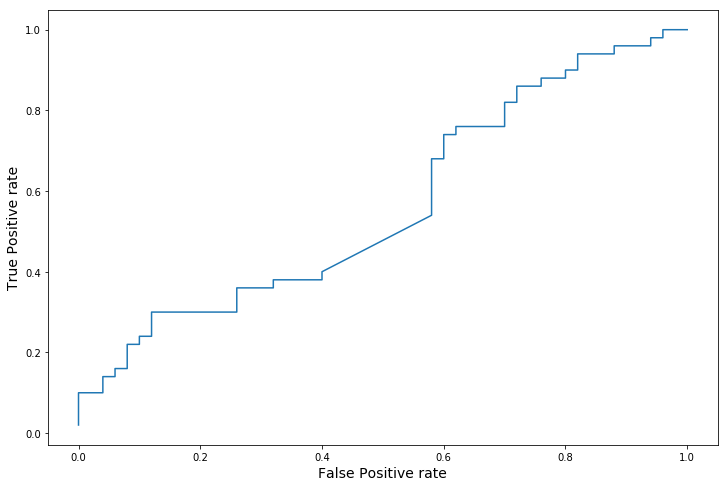

auc = 0.5646


,False Positive rate (fixed),False Negative rate
0,0.10,0.76
1,0.15,0.70
2,0.20,0.70
3,0.30,0.64


,False Positive rate (fixed),Threshold,False Positives indexes,False Negatives indexes
0,0.10,0.545183,"P006, P013, P079, P080, P090","P002, P004, P012, P014, P015, P017, P019, P020, P021, P022, P025, P028, P029, P030, P035, P038, P041, P042, P044, P049, P052, P053, P057, P058, P0..."
1,0.15,0.534748,"P006, P013, P079, P080, P085, P090","P002, P004, P012, P014, P015, P017, P019, P021, P022, P025, P028, P029, P030, P035, P038, P041, P042, P044, P049, P052, P053, P057, P058, P060, P0..."
2,0.20,0.534748,"P006, P013, P079, P080, P085, P090","P002, P004, P012, P014, P015, P017, P019, P021, P022, P025, P028, P029, P030, P035, P038, P041, P042, P044, P049, P052, P053, P057, P058, P060, P0..."
3,0.30,0.514205,"P006, P009, P013, P026, P032, P043, P062, P079, P080, P085, P090, P093, P106","P002, P004, P012, P015, P017, P019, P021, P022, P025, P028, P029, P030, P035, P038, P041, P042, P044, P049, P052, P053, P057, P058, P060, P061, P0..."


,frequency
inferiortemporal_ThickAvg_l,60
Right-Thalamus-Proper_normMean,54
Right-Cerebellum-White-Matter_normMean,43
lateraloccipital_MeanCurv_r,40
Right-Pallidum_normMean,40
CC_Anterior_normMean,40
Left-Putamen_normMean,35
CC_Mid_Posterior_normMean,35
Left-VentralDC_normMean,34
Right-Hippocampus_normMean,32


Pipeline(memory=None,
     steps=[('Fill_NaN', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), ('StdScaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('dim_reduction', SelectKBest(k=100, score_func=<function ttest_ind at 0x0000024E8F185B70>)), ('classifier', LogisticRegressio...alty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])


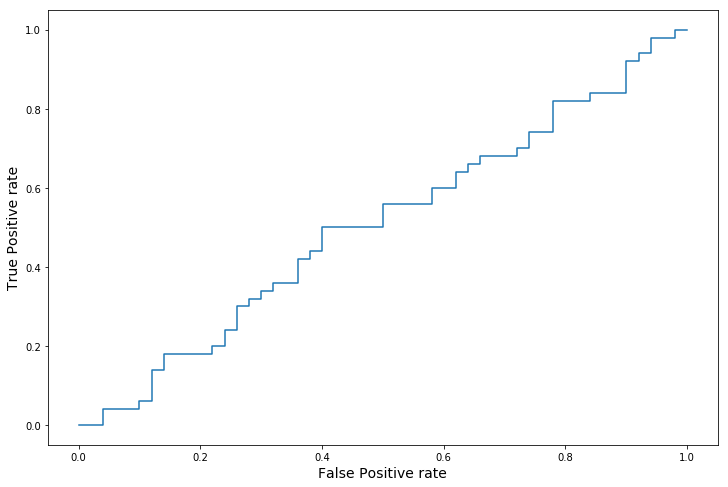

auc = 0.5056


,False Positive rate (fixed),False Negative rate
0,0.10,0.94
1,0.15,0.82
2,0.20,0.82
3,0.30,0.66


,False Positive rate (fixed),Threshold,False Positives indexes,False Negatives indexes
0,0.10,0.523758,"P003, P077, P079, P083, P094","P002, P004, P012, P014, P015, P016, P017, P019, P020, P021, P022, P023, P025, P027, P028, P029, P030, P035, P038, P040, P042, P044, P048, P052, P0..."
1,0.15,0.519210,"P003, P037, P077, P079, P083, P084, P094","P002, P004, P012, P014, P016, P017, P019, P020, P021, P022, P023, P025, P027, P029, P030, P035, P038, P040, P042, P044, P048, P052, P055, P057, P0..."
2,0.20,0.519210,"P003, P037, P077, P079, P083, P084, P094","P002, P004, P012, P014, P016, P017, P019, P020, P021, P022, P023, P025, P027, P029, P030, P035, P038, P040, P042, P044, P048, P052, P055, P057, P0..."
3,0.30,0.511147,"P003, P026, P037, P046, P056, P077, P079, P081, P083, P084, P085, P093, P094, P106, P107","P002, P004, P014, P016, P017, P019, P020, P022, P023, P025, P027, P035, P038, P040, P042, P044, P048, P052, P055, P057, P060, P061, P063, P064, P0..."


,frequency
lingual_GausCurv_r,97
inferiortemporal_ThickAvg_l,96
bankssts_ThickAvg_l,95
inferiortemporal_MeanCurv_r,94
lateraloccipital_GausCurv_l,93
Left-Accumbens-area_normMax,89
cuneus_ThickAvg_l,86
superiorfrontal_MeanCurv_l,85
lateraloccipital_GausCurv_r,84
Left-Putamen_normMax,83


Pipeline(memory=None,
     steps=[('Fill_NaN', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), ('StdScaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('dim_reduction', SelectKBest(k=20, score_func=<function ttest_ind at 0x0000024E8F185B70>)), ('classifier', RandomForestClassi...timators=180, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False))])


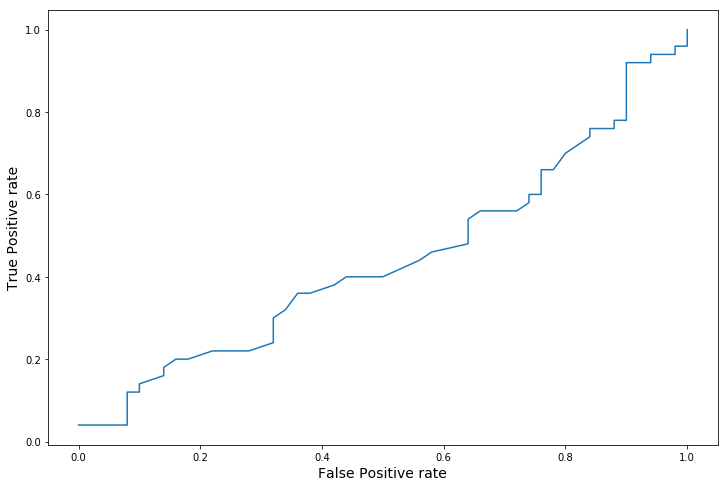

auc = 0.4426


,False Positive rate (fixed),False Negative rate
0,0.10,0.86
1,0.15,0.82
2,0.20,0.80
3,0.30,0.78


,False Positive rate (fixed),Threshold,False Positives indexes,False Negatives indexes
0,0.10,0.677778,"P046, P059, P081, P083, P093","P004, P012, P014, P015, P016, P017, P019, P020, P021, P022, P023, P025, P027, P028, P035, P038, P040, P041, P042, P044, P048, P049, P052, P053, P0..."
1,0.15,0.644444,"P046, P059, P081, P083, P084, P085, P093","P004, P014, P015, P016, P017, P019, P020, P021, P022, P023, P025, P027, P028, P035, P038, P040, P041, P042, P044, P048, P049, P052, P053, P055, P0..."
2,0.20,0.633333,"P018, P046, P059, P081, P083, P084, P085, P093","P004, P014, P015, P016, P017, P019, P020, P021, P022, P023, P025, P027, P035, P038, P040, P041, P042, P044, P048, P049, P052, P053, P055, P057, P0..."
3,0.30,0.572222,"P003, P013, P018, P046, P051, P059, P078, P081, P083, P084, P085, P093, P094","P004, P014, P015, P016, P017, P019, P020, P021, P022, P023, P025, P027, P035, P038, P040, P041, P042, P044, P048, P052, P053, P055, P057, P060, P0..."


,frequency
inferiortemporal_ThickAvg_l,78
Right-Thalamus-Proper_normMean,60
Right-Cerebellum-White-Matter_normMean,60
CC_Anterior_normMean,59
lateraloccipital_MeanCurv_r,58
bankssts_ThickAvg_l,58
inferiortemporal_MeanCurv_r,55
Right-Pallidum_normMean,54
CC_Mid_Posterior_normMean,53
superiorfrontal_MeanCurv_l,51


Pipeline(memory=None,
     steps=[('Fill_NaN', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), ('StdScaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('dim_reduction', SelectKBest(k=100, score_func=<function ttest_ind at 0x0000024E8F185B70>)), ('classifier', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=44, p=1,
           weights='distance'))])


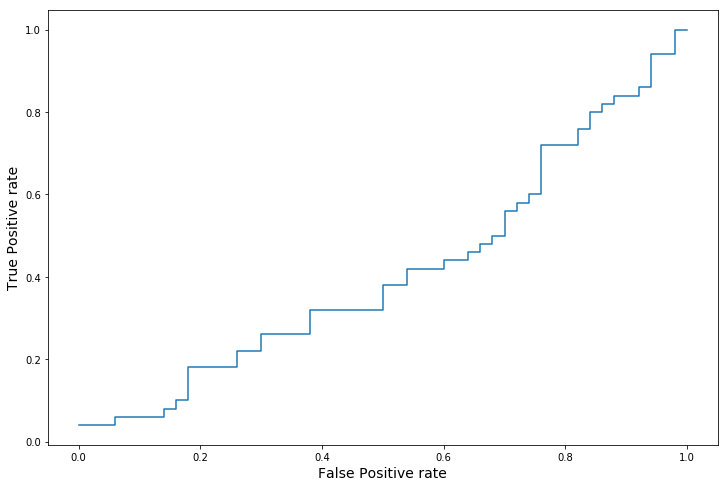

auc = 0.414


,False Positive rate (fixed),False Negative rate
0,0.10,0.94
1,0.15,0.92
2,0.20,0.82
3,0.30,0.74


,False Positive rate (fixed),Threshold,False Positives indexes,False Negatives indexes
0,0.10,0.631399,"P003, P018, P079","P002, P004, P012, P014, P015, P016, P017, P019, P020, P021, P022, P023, P025, P027, P028, P035, P038, P040, P041, P042, P044, P048, P049, P052, P0..."
1,0.15,0.613375,"P003, P011, P018, P037, P079, P083, P093","P002, P004, P012, P014, P015, P016, P017, P019, P020, P021, P022, P023, P025, P027, P028, P035, P038, P040, P042, P044, P048, P049, P052, P053, P0..."
2,0.20,0.593122,"P003, P011, P018, P037, P050, P079, P083, P093, P094","P002, P004, P014, P016, P017, P019, P020, P021, P022, P023, P025, P027, P028, P035, P038, P040, P042, P044, P048, P052, P053, P055, P057, P058, P0..."
3,0.30,0.575567,"P001, P003, P011, P018, P037, P047, P050, P051, P079, P083, P084, P085, P091, P093, P094","P002, P004, P014, P016, P017, P019, P020, P022, P023, P025, P027, P028, P035, P038, P040, P042, P044, P048, P052, P057, P058, P060, P061, P063, P0..."


,frequency
lingual_GausCurv_r,97
inferiortemporal_ThickAvg_l,96
bankssts_ThickAvg_l,95
inferiortemporal_MeanCurv_r,94
lateraloccipital_GausCurv_l,93
Left-Accumbens-area_normMax,89
cuneus_ThickAvg_l,86
superiorfrontal_MeanCurv_l,85
lateraloccipital_GausCurv_r,84
Left-Putamen_normMax,83


In [42]:
for i in range(len(best_model_l)):
    print(best_model_l[i])
    fpr, tpr, t = plot_roc_curve(y, probas_l[i], idx)
    get_fpr_fnr(fpr, tpr)
    get_incorrectly_classified(y, probas_l[i], idx, fpr, t)
    display(features_l[i].iloc[:10])

In [43]:
all_features, frequent_features, common_frequent_features = get_frequent_features(features_l, classifiers_l, y, p=0.7)
display(frequent_features.iloc[:10])
print("common_frequent_features: " + ", ".join(common_frequent_features))

,feature
inferiortemporal_ThickAvg_l,3
lateraloccipital_MeanCurv_r,2
supramarginal_MeanCurv_r,2
lingual_GausCurv_r,2
Right-Cerebellum-White-Matter_normMean,2
Right-Pallidum_normMean,2
CC_Mid_Posterior_normMean,2
entorhinal_ThickAvg_l,2
Left-Putamen_normMax,2
Right-Thalamus-Proper_normMax,2


common_frequent_features: inferiortemporal_ThickAvg_l


In [44]:
all_incorr_classified, common_false_positives, common_false_negatives = get_frequent_indexes(probas_l, classifiers_l, y, idx, show=False)
print('False positives for more than 3 clsf',common_false_positives)
print('False negatives for more than 3 clsf',common_false_negatives)

False positives for more than 3 clsf P003, P079, P083, P084, P085, P093, P094
False negatives for more than 3 clsf P002, P004, P012, P014, P015, P016, P017, P019, P020, P021, P022, P023, P025, P027, P028, P035, P038, P040, P041, P042, P044, P048, P049, P052, P053, P055, P057, P058, P060, P061, P063, P064, P065, P067, P069, P070, P071, P073, P074, P075, P076, P086, P087, P088, P096, P099, P105


### 4. Epilepsy / control

Target distribution: 
1    25
0    25
Name: E/C, dtype: int64 

Training SVC...
(training took 160.8449456691742s)

Training LR...
(training took 52.91340088844299s)

Training RFC...
(training took 119.37172079086304s)

Training KNN...
(training took 200.22991466522217s)

Scoring: roc_auc


,best parameters,best dim. reduction method,mean,std
classifier,,,,
SVC,"classifier__C = 1, classifier__gamma = 0.01, classifier__kernel = rbf","SelectNFeaturesFromModel(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',\n max_depth=None, max_fe...",0.6992,0.163998
LR,"classifier__C = 0.01, classifier__penalty = l2","SelectNFeaturesFromModel(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',\n max_depth=None, max_fe...",0.6544,0.180268
RFC,classifier__n_estimators = 130,"SelectKBest(k=20, score_func=<function ttest_ind at 0x000001C4D7D24B70>)",0.7184,0.167133
KNN,"classifier__n_neighbors = 5, classifier__p = 1, classifier__weights = distance","SelectNFeaturesFromModel(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',\n max_depth=None, max_fe...",0.7064,0.140253


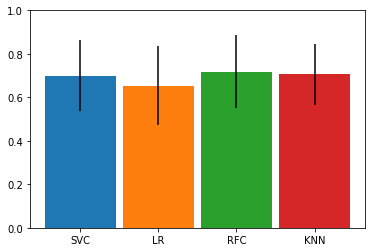

Best model: 
RFC
classifier__n_estimators = 130
dim_reduction = SelectKBest(k=20, score_func=<function ttest_ind at 0x000001C4D7D24B70>)


In [55]:
#03.07
n_splits = 5
problem = "E_C"
problem_labels = "E/C"
pos_label = label_to_idx["E"]
idx = E_C_idx
X, y = mri_data[idx], pd.Series(labels[idx][problem_labels] == pos_label, dtype=int)

best_model_mri_E_C, grid_cv_svc_mri_E_C, grid_cv_lr_mri_E_C, grid_cv_rfc_mri_E_C, grid_cv_knn_mri_E_C= train_grid_cv(
    X, y, n_splits=n_splits, n_repeats=5, scoring=scoring, random_state=42, n_jobs=1)

Target distribution: 
1    25
0    25
Name: E/C, dtype: int64 

Training SVC...
(training took 756.2037258148193s)

Training LR...
(training took 265.2154040336609s)

Training RFC...
(training took 619.8186190128326s)

Training KNN...
(training took 1090.9793212413788s)

Scoring: roc_auc


,best parameters,best dim. reduction method,mean,std
classifier,,,,
SVC,"classifier__C = 1, classifier__gamma = 0.01, classifier__kernel = rbf","SelectKBest(k=50, score_func=<function ttest_ind at 0x000001987D0F8B70>)",0.7360,0.159198
LR,"classifier__C = 0.01, classifier__penalty = l2","SelectKBest(k=100, score_func=<function ttest_ind at 0x000001987D0F8B70>)",0.6944,0.190622
RFC,classifier__n_estimators = 190,"SelectKBest(k=100, score_func=<function ttest_ind at 0x000001987D0F8B70>)",0.7416,0.178071
KNN,"classifier__n_neighbors = 8, classifier__p = 1, classifier__weights = distance","SelectKBest(k=50, score_func=<function ttest_ind at 0x000001987D0F8B70>)",0.7104,0.164450


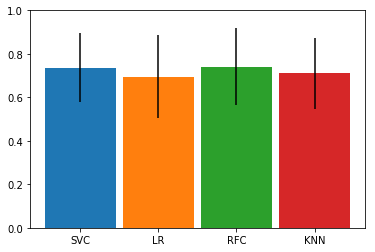

Best model: 
RFC
classifier__n_estimators = 190
dim_reduction = SelectKBest(k=100, score_func=<function ttest_ind at 0x000001987D0F8B70>)


In [38]:
n_splits = 5
problem = "E_C"
problem_labels = "E/C"
pos_label = label_to_idx["E"]
idx = E_C_idx
X, y = mri_data[idx], pd.Series(labels[idx][problem_labels] == pos_label, dtype=int)

best_model_mri_E_C, grid_cv_svc_mri_E_C, grid_cv_lr_mri_E_C, grid_cv_rfc_mri_E_C, grid_cv_knn_mri_E_C= train_grid_cv(
    X, y, n_splits=n_splits, n_repeats=5, scoring=scoring, random_state=42, n_jobs=1)

In [39]:
grid_cv_l = [grid_cv_svc_mri_E_C, grid_cv_lr_mri_E_C, grid_cv_rfc_mri_E_C, grid_cv_knn_mri_E_C]
best_model_l = [x.best_estimator_ for x in grid_cv_l]
for i, clf in enumerate(classifiers_l):
    save_model(best_model_l[i], "T1_sMRI_{}_best_{}.pkl".format(problem, clf))
save_model(best_model_mri_E_C, "T1_sMRI_{}.pkl".format(problem))    
    
probas_l = [repeated_cross_val_predict_proba(best_model, X, y, cv=LeaveOneOut(), file="{}_probas_mri_{}.csv".format(classifiers_l[i], problem)) for i, best_model in enumerate(best_model_l)]
feature_sets_l = [get_feature_sets_on_cross_val(X, y, best_model, cv=LeaveOneOut()) for best_model in best_model_l]
features_l = [pd.DataFrame(pd.DataFrame(data=feature_set).stack().reset_index(drop=True).value_counts(), columns=['frequency']) for feature_set in feature_sets_l]

50it [00:00, 92.84it/s]
50it [00:00, 114.46it/s]
50it [00:13,  3.72it/s]
50it [00:00, 93.53it/s] 
50it [00:00, 97.54it/s] 
50it [00:00, 90.01it/s]
50it [00:18,  2.67it/s]
50it [00:00, 84.26it/s]


Pipeline(memory=None,
     steps=[('Fill_NaN', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), ('StdScaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('dim_reduction', SelectKBest(k=50, score_func=<function ttest_ind at 0x000001987D0F8B70>)), ('classifier', SVC(C=1, cache_siz...bf',
  max_iter=-1, probability=True, random_state=42, shrinking=True,
  tol=0.001, verbose=False))])


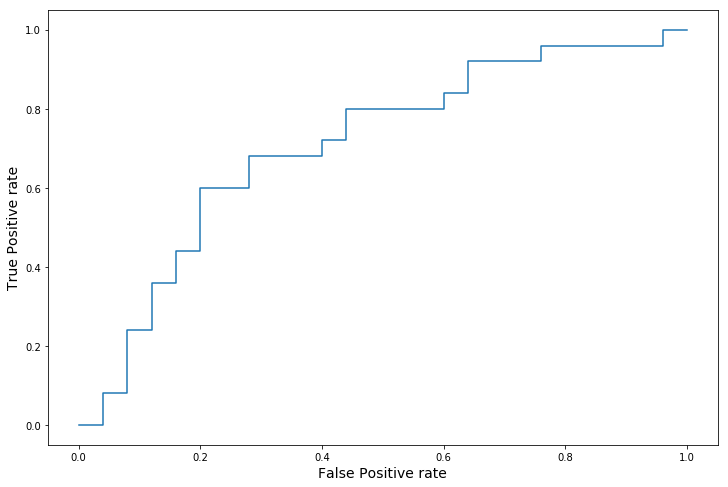

auc = 0.7072


,False Positive rate (fixed),False Negative rate
0,0.10,0.76
1,0.15,0.64
2,0.20,0.40
3,0.30,0.32


,False Positive rate (fixed),Threshold,False Positives indexes,False Negatives indexes
0,0.10,0.650402,"P077, P089","P003, P006, P009, P010, P011, P024, P026, P031, P034, P045, P050, P056, P059, P068, P079, P081, P083, P084, P092, P094"
1,0.15,0.611789,"P037, P077, P089","P003, P006, P009, P010, P024, P031, P034, P050, P056, P059, P068, P079, P081, P083, P084, P092, P094"
2,0.20,0.572567,"P008, P036, P037, P077, P089","P006, P009, P010, P031, P050, P056, P059, P068, P083, P084, P094"
3,0.30,0.548028,"P008, P013, P036, P037, P051, P077, P089","P006, P009, P050, P056, P059, P068, P083, P084, P094"


,frequency
Left-Hippocampus_normMean,40
Left-Thalamus-Proper_normMean,38
Right-VentralDC_normStdDev,37
Left-Putamen_normMean,36
Right-choroid-plexus_normMean,35
inferiorparietal_ThickAvg_r,32
CC_Posterior_normMean,31
CC_Mid_Posterior_normMean,31
fusiform_ThickAvg_l,31
Left-VentralDC_normMean,29


Pipeline(memory=None,
     steps=[('Fill_NaN', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), ('StdScaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('dim_reduction', SelectKBest(k=100, score_func=<function ttest_ind at 0x000001987D0F8B70>)), ('classifier', LogisticRegressio...alty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])


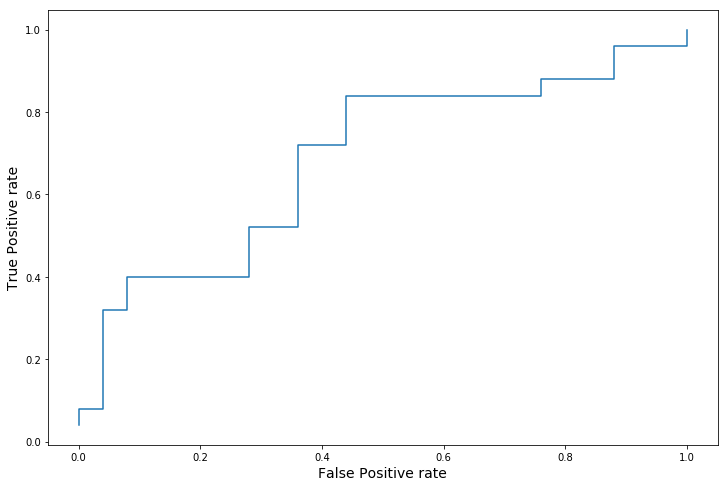

auc = 0.6848


,False Positive rate (fixed),False Negative rate
0,0.10,0.60
1,0.15,0.60
2,0.20,0.60
3,0.30,0.48


,False Positive rate (fixed),Threshold,False Positives indexes,False Negatives indexes
0,0.10,0.577635,"P051, P077","P006, P009, P024, P026, P031, P034, P039, P045, P050, P056, P059, P068, P081, P083, P084, P094"
1,0.15,0.577635,"P051, P077","P006, P009, P024, P026, P031, P034, P039, P045, P050, P056, P059, P068, P081, P083, P084, P094"
2,0.20,0.577635,"P051, P077","P006, P009, P024, P026, P031, P034, P039, P045, P050, P056, P059, P068, P081, P083, P084, P094"
3,0.30,0.510672,"P008, P013, P037, P051, P077, P089, P093","P006, P009, P031, P034, P039, P050, P056, P059, P068, P081, P083, P084, P094"


,frequency
Left-Thalamus-Proper_normMean,40
Left-Hippocampus_normMean,40
Right-VentralDC_normStdDev,40
Left-VentralDC_normStdDev,39
inferiorparietal_ThickAvg_r,38
CC_Posterior_normMean,37
Right-choroid-plexus_normMean,37
Left-Putamen_normMean,36
pericalcarine_GausCurv_l,35
Left-VentralDC_normMean,34


Pipeline(memory=None,
     steps=[('Fill_NaN', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), ('StdScaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('dim_reduction', SelectKBest(k=100, score_func=<function ttest_ind at 0x000001987D0F8B70>)), ('classifier', RandomForestClass...timators=190, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False))])


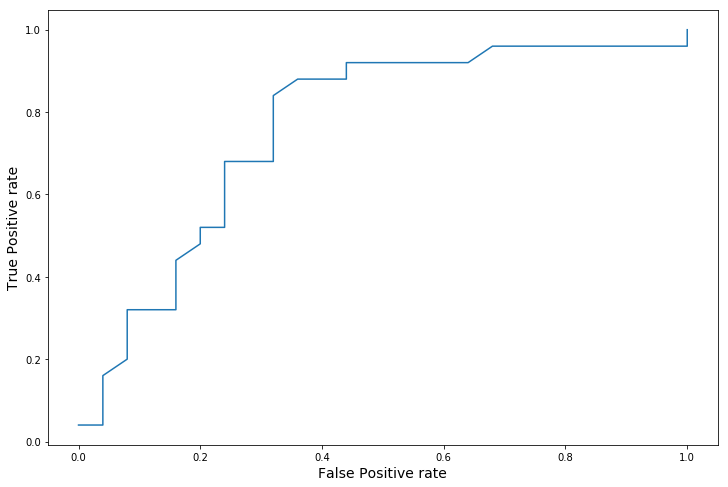

auc = 0.7616


,False Positive rate (fixed),False Negative rate
0,0.10,0.68
1,0.15,0.68
2,0.20,0.48
3,0.30,0.32


,False Positive rate (fixed),Threshold,False Positives indexes,False Negatives indexes
0,0.10,0.631579,"P037, P077","P006, P009, P010, P011, P024, P026, P031, P034, P039, P050, P056, P059, P068, P079, P081, P083, P084, P094"
1,0.15,0.631579,"P037, P077","P006, P009, P010, P011, P024, P026, P031, P034, P039, P050, P056, P059, P068, P079, P081, P083, P084, P094"
2,0.20,0.542105,"P008, P037, P051, P077, P093","P006, P009, P024, P026, P031, P034, P050, P056, P068, P081, P083, P084, P094"
3,0.30,0.505263,"P008, P013, P037, P051, P077, P093","P006, P009, P031, P050, P056, P068, P081, P084, P094"


,frequency
Left-Thalamus-Proper_normMean,40
Left-Hippocampus_normMean,40
Right-VentralDC_normStdDev,40
Left-VentralDC_normStdDev,39
inferiorparietal_ThickAvg_r,38
CC_Posterior_normMean,37
Right-choroid-plexus_normMean,37
Left-Putamen_normMean,36
pericalcarine_GausCurv_l,35
Left-VentralDC_normMean,34


Pipeline(memory=None,
     steps=[('Fill_NaN', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), ('StdScaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('dim_reduction', SelectKBest(k=50, score_func=<function ttest_ind at 0x000001987D0F8B70>)), ('classifier', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=8, p=1,
           weights='distance'))])


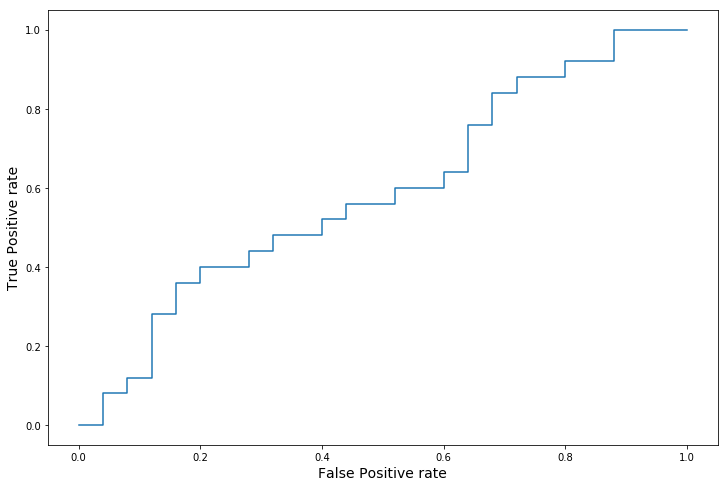

auc = 0.5888


,False Positive rate (fixed),False Negative rate
0,0.10,0.88
1,0.15,0.72
2,0.20,0.60
3,0.30,0.56


,False Positive rate (fixed),Threshold,False Positives indexes,False Negatives indexes
0,0.10,0.627916,"P008, P077","P001, P003, P006, P009, P010, P011, P024, P026, P031, P034, P039, P045, P050, P056, P059, P068, P072, P078, P079, P083, P084, P092, P094"
1,0.15,0.511864,"P008, P013, P077","P001, P006, P009, P010, P024, P026, P031, P034, P039, P045, P050, P056, P059, P068, P072, P079, P083, P084, P094"
2,0.20,0.497951,"P008, P013, P037, P077, P093","P001, P006, P009, P010, P024, P031, P034, P039, P045, P050, P056, P059, P068, P083, P084, P094"
3,0.30,0.477273,"P008, P013, P037, P077, P085, P093, P100","P006, P009, P010, P024, P031, P034, P039, P045, P050, P056, P059, P068, P083, P084, P094"


,frequency
Left-Hippocampus_normMean,40
Left-Thalamus-Proper_normMean,38
Right-VentralDC_normStdDev,37
Left-Putamen_normMean,36
Right-choroid-plexus_normMean,35
inferiorparietal_ThickAvg_r,32
CC_Posterior_normMean,31
CC_Mid_Posterior_normMean,31
fusiform_ThickAvg_l,31
Left-VentralDC_normMean,29


In [40]:
for i in range(len(best_model_l)):
    print(best_model_l[i])
    fpr, tpr, t = plot_roc_curve(y, probas_l[i], idx)
    get_fpr_fnr(fpr, tpr)
    get_incorrectly_classified(y, probas_l[i], idx, fpr, t)
    display(features_l[i].iloc[:10])

In [41]:
all_features, frequent_features, common_frequent_features = get_frequent_features(features_l, classifiers_l, y, p=0.7)
display(frequent_features.iloc[:10])
print("common_frequent_features: " + ", ".join(common_frequent_features))

,feature
Left-Putamen_normMean,4
Left-Thalamus-Proper_normMean,4
Left-Hippocampus_normMean,4
Right-VentralDC_normStdDev,4
inferiorparietal_ThickAvg_r,2
Left-VentralDC_normStdDev,2
CC_Posterior_normMean,2
Right-choroid-plexus_normMean,2


common_frequent_features: Left-Putamen_normMean, Left-Thalamus-Proper_normMean, Left-Hippocampus_normMean, Right-VentralDC_normStdDev


In [42]:
all_incorr_classified, common_false_positives, common_false_negatives = get_frequent_indexes(probas_l, classifiers_l, y, idx, show=False)
print('False positives for more than 3 clsf',common_false_positives)
print('False negatives for more than 3 clsf',common_false_negatives)

False positives for more than 3 clsf P008, P013, P037, P051, P077, P093
False negatives for more than 3 clsf P006, P009, P010, P011, P024, P026, P031, P034, P039, P045, P050, P056, P059, P068, P079, P081, P083, P084, P094


### 5. Depression / control

Target distribution: 
1    25
0    25
Name: D/C, dtype: int64 

Training SVC...
(training took 180.53920102119446s)

Training LR...
(training took 40.76467037200928s)

Training RFC...
(training took 109.02930402755737s)

Training KNN...
(training took 199.45471239089966s)

Scoring: roc_auc


,best parameters,best dim. reduction method,mean,std
classifier,,,,
SVC,"classifier__C = 1, classifier__gamma = 0.0001, classifier__kernel = rbf","SelectNFeaturesFromModel(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',\n max_depth=None, max_fe...",0.6224,0.135330
LR,"classifier__C = 0.001, classifier__penalty = l2","SelectNFeaturesFromModel(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',\n max_depth=None, max_fe...",0.6240,0.135765
RFC,classifier__n_estimators = 100,"SelectNFeaturesFromModel(estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',\n max_depth=None, max_feat...",0.7040,0.151789
KNN,"classifier__n_neighbors = 11, classifier__p = 1, classifier__weights = distance","SelectNFeaturesFromModel(estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',\n max_depth=None, max_feat...",0.6704,0.142786


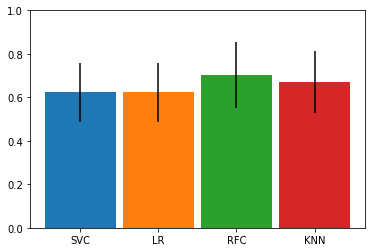

Best model: 
RFC
classifier__n_estimators = 100
dim_reduction = SelectNFeaturesFromModel(estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
             n_selected=20, prefit=False)


In [53]:
n_splits = 5
problem = "D_C"
problem_labels = "D/C"
pos_label = label_to_idx["D"]
idx = D_C_idx
X, y = mri_data[idx], pd.Series(labels[idx][problem_labels] == pos_label, dtype=int)

best_model_mri_D_C, grid_cv_svc_mri_D_C, grid_cv_lr_mri_D_C, grid_cv_rfc_mri_D_C, grid_cv_knn_mri_D_C = train_grid_cv(
    X, y, n_splits=n_splits, n_repeats=5, scoring=scoring, random_state=42, n_jobs=1)

Target distribution: 
1    25
0    25
Name: D/C, dtype: int64 

Training SVC...
(training took 110.07607913017273s)

Training LR...
(training took 52.27899408340454s)

Training RFC...
(training took 154.456303358078s)

Training KNN...
(training took 336.49256324768066s)

Scoring: roc_auc


,best parameters,best dim. reduction method,mean,std
classifier,,,,
SVC,"classifier__C = 1, classifier__gamma = 0.001, classifier__kernel = rbf","SelectNFeaturesFromModel(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',\n max_depth=None, max_fe...",0.6224,0.139062
LR,"classifier__C = 0.001, classifier__penalty = l2","SelectNFeaturesFromModel(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',\n max_depth=None, max_fe...",0.6240,0.135765
RFC,classifier__n_estimators = 100,"SelectNFeaturesFromModel(estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',\n max_depth=None, max_feat...",0.7040,0.151789
KNN,"classifier__n_neighbors = 11, classifier__p = 1, classifier__weights = distance","SelectNFeaturesFromModel(estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',\n max_depth=None, max_feat...",0.6704,0.142786


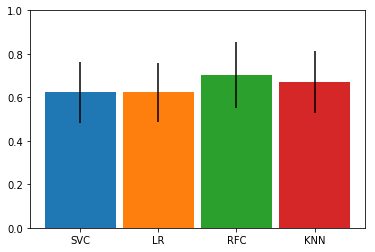

Best model: 
RFC
classifier__n_estimators = 100
dim_reduction = SelectNFeaturesFromModel(estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
             n_selected=20, prefit=False)


In [50]:
n_splits = 5
problem = "D_C"
problem_labels = "D/C"
pos_label = label_to_idx["D"]
idx = D_C_idx
X, y = mri_data[idx], pd.Series(labels[idx][problem_labels] == pos_label, dtype=int)

best_model_mri_D_C, grid_cv_svc_mri_D_C, grid_cv_lr_mri_D_C, grid_cv_rfc_mri_D_C, grid_cv_knn_mri_D_C = train_grid_cv(
    X, y, n_splits=n_splits, n_repeats=5, scoring=scoring, random_state=42, n_jobs=1)

In [47]:
grid_cv_l = [grid_cv_svc_mri_D_C, grid_cv_lr_mri_D_C, grid_cv_rfc_mri_D_C, grid_cv_knn_mri_D_C ]
best_model_l = [x.best_estimator_ for x in grid_cv_l]
for i, clf in enumerate(classifiers_l):
    save_model(best_model_l[i], "T1_sMRI_{}_best_{}.pkl".format(problem, clf))
save_model(best_model_mri_D_C, "T1_sMRI_{}.pkl".format(problem))    
    
probas_l = [repeated_cross_val_predict_proba(best_model, X, y, cv=LeaveOneOut(), file="{}_probas_mri_{}.csv".format(classifiers_l[i], problem)) for i, best_model in enumerate(best_model_l)]
feature_sets_l = [get_feature_sets_on_cross_val(X, y, best_model, cv=LeaveOneOut()) for best_model in best_model_l]
features_l = [pd.DataFrame(pd.DataFrame(data=feature_set).stack().reset_index(drop=True).value_counts(), columns=['frequency']) for feature_set in feature_sets_l]

50it [00:06,  7.16it/s]
50it [00:06,  7.29it/s]
50it [00:15,  3.25it/s]
50it [00:09,  5.09it/s]
50it [00:10,  4.87it/s]
50it [00:09,  5.14it/s]
50it [00:10,  4.84it/s]
50it [00:05,  9.10it/s]


Pipeline(memory=None,
     steps=[('Fill_NaN', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), ('StdScaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('dim_reduction', SelectNFeaturesFromModel(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini...bf',
  max_iter=-1, probability=True, random_state=42, shrinking=True,
  tol=0.001, verbose=False))])


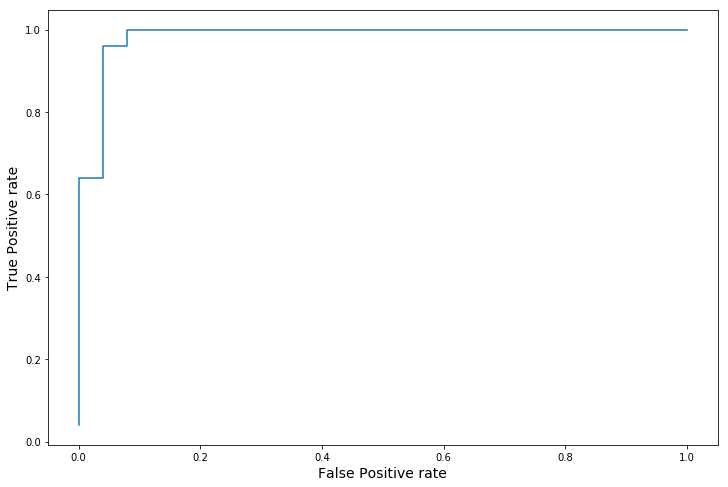

auc = 0.984


,False Positive rate (fixed),False Negative rate
0,0.10,0.0
1,0.15,0.0
2,0.20,0.0
3,0.30,0.0


,False Positive rate (fixed),Threshold,False Positives indexes,False Negatives indexes
0,0.10,0.489701,"P077, P106",P041
1,0.15,0.489701,"P077, P106",P041
2,0.20,0.489701,"P077, P106",P041
3,0.30,0.489701,"P077, P106",P041


,frequency
superiortemporal_ThickStd_r,50
temporalpole_NumVert_r,49
Left-Caudate_normStdDev,49
frontalpole_ThickStd_r,45
caudalanteriorcingulate_MeanCurv_r,38
inferiorparietal_GrayVol_l,33
precentral_ThickStd_l,33
inferiortemporal_ThickAvg_l,31
bankssts_ThickAvg_r,29
parsorbitalis_ThickStd_r,29


Pipeline(memory=None,
     steps=[('Fill_NaN', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), ('StdScaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('dim_reduction', SelectNFeaturesFromModel(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini...alty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])


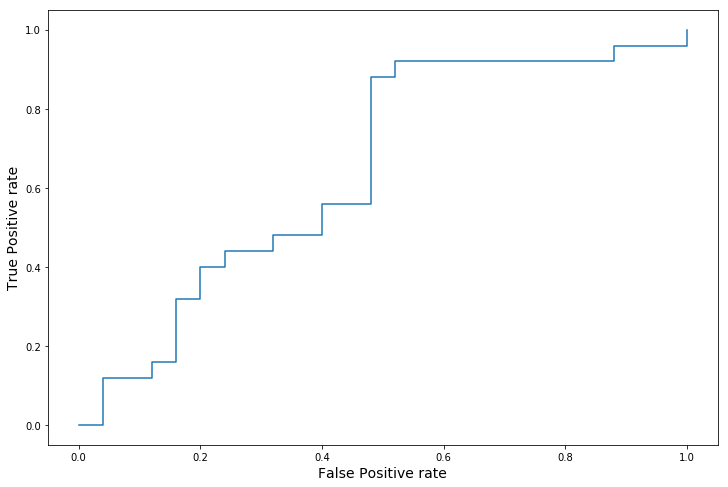

auc = 0.6448


,False Positive rate (fixed),False Negative rate
0,0.10,0.88
1,0.15,0.84
2,0.20,0.60
3,0.30,0.56


,False Positive rate (fixed),Threshold,False Positives indexes,False Negatives indexes
0,0.10,0.524330,P077,"P004, P012, P014, P016, P019, P020, P021, P023, P028, P029, P030, P035, P041, P042, P052, P053, P058, P060, P063, P066, P067, P069, P071"
1,0.15,0.516352,"P037, P046, P077","P004, P012, P014, P016, P019, P020, P021, P023, P028, P029, P030, P035, P042, P052, P053, P058, P060, P063, P066, P067, P069, P071"
2,0.20,0.505492,"P037, P046, P077, P085, P091","P004, P012, P014, P016, P019, P020, P021, P029, P030, P035, P042, P053, P060, P066, P069, P071"
3,0.30,0.504331,"P037, P046, P077, P085, P091, P093","P004, P012, P014, P016, P019, P020, P021, P029, P030, P035, P053, P060, P066, P069, P071"


,frequency
superiortemporal_ThickStd_r,50
temporalpole_NumVert_r,49
Left-Caudate_normStdDev,49
frontalpole_ThickStd_r,45
caudalanteriorcingulate_MeanCurv_r,38
inferiorparietal_GrayVol_l,33
precentral_ThickStd_l,33
inferiortemporal_ThickAvg_l,31
bankssts_ThickAvg_r,29
parsorbitalis_ThickStd_r,29


Pipeline(memory=None,
     steps=[('Fill_NaN', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), ('StdScaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('dim_reduction', SelectNFeaturesFromModel(estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini'...timators=100, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False))])


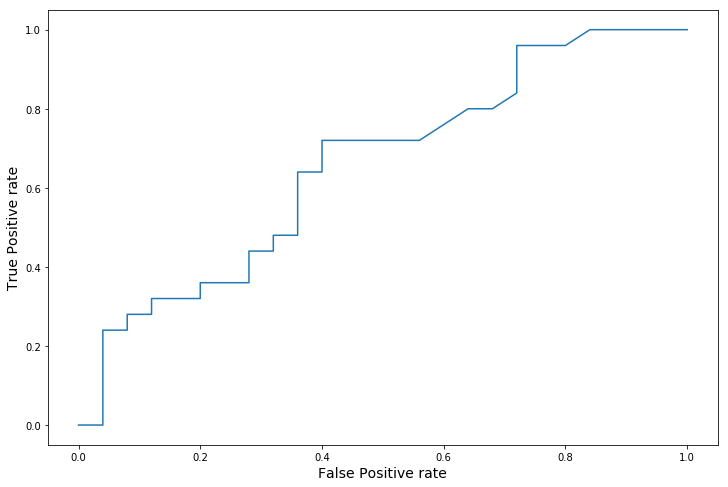

auc = 0.6544


,False Positive rate (fixed),False Negative rate
0,0.10,0.72
1,0.15,0.68
2,0.20,0.64
3,0.30,0.56


,False Positive rate (fixed),Threshold,False Positives indexes,False Negatives indexes
0,0.10,0.73,"P062, P077","P004, P012, P014, P016, P019, P020, P021, P023, P035, P042, P052, P053, P060, P063, P065, P066, P069, P070, P071"
1,0.15,0.70,"P037, P062, P077","P004, P012, P014, P016, P019, P020, P021, P023, P035, P042, P052, P053, P060, P063, P065, P066, P069, P071"
2,0.20,0.65,"P037, P046, P062, P077, P082","P004, P012, P014, P016, P019, P020, P021, P023, P035, P042, P052, P060, P063, P065, P066, P069, P071"
3,0.30,0.58,"P037, P046, P062, P077, P082, P085, P107","P004, P012, P014, P019, P020, P021, P023, P035, P042, P052, P060, P065, P066, P069, P071"


,frequency
inferiortemporal_ThickAvg_l,50
superiortemporal_ThickStd_r,50
frontalpole_ThickStd_r,47
postcentral_CurvInd_l,45
superiorfrontal_ThickStd_r,41
precentral_GausCurv_r,38
precentral_GausCurv_l,36
pericalcarine_GausCurv_r,35
CC_Central_normStdDev,31
4th-Ventricle_normMean,28


Pipeline(memory=None,
     steps=[('Fill_NaN', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), ('StdScaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('dim_reduction', SelectNFeaturesFromModel(estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini'...ski',
           metric_params=None, n_jobs=1, n_neighbors=11, p=1,
           weights='distance'))])


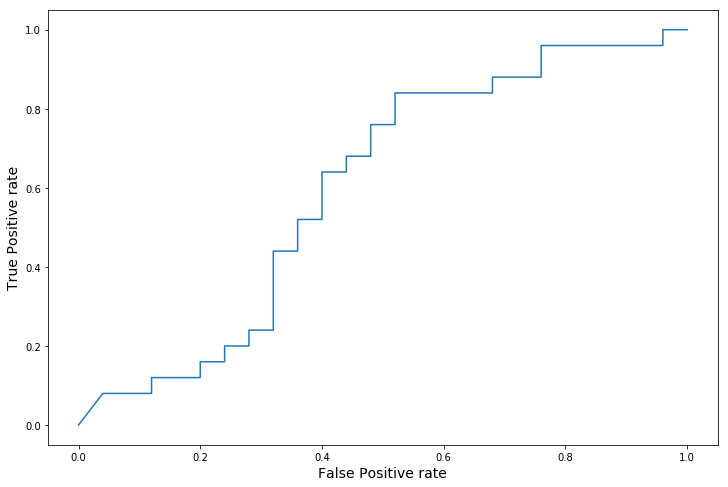

auc = 0.5999999999999999


,False Positive rate (fixed),False Negative rate
0,0.10,0.92
1,0.15,0.88
2,0.20,0.84
3,0.30,0.76


,False Positive rate (fixed),Threshold,False Positives indexes,False Negatives indexes
0,0.10,1.000000,,"P004, P012, P014, P016, P019, P020, P021, P023, P028, P029, P030, P035, P041, P042, P052, P053, P058, P060, P063, P065, P066, P067, P069, P070, P071"
1,0.15,0.902009,"P037, P062, P077","P004, P012, P014, P016, P019, P020, P021, P023, P028, P035, P041, P042, P052, P053, P058, P060, P063, P065, P066, P067, P069, P070, P071"
2,0.20,0.814273,"P037, P046, P062, P077, P085","P004, P012, P014, P016, P019, P020, P021, P023, P028, P035, P042, P052, P053, P058, P060, P063, P065, P066, P067, P069, P070, P071"
3,0.30,0.744541,"P037, P046, P062, P077, P082, P085, P107","P004, P012, P014, P016, P019, P020, P021, P023, P028, P035, P042, P052, P053, P058, P060, P063, P066, P067, P069, P071"


,frequency
inferiortemporal_ThickAvg_l,50
superiortemporal_ThickStd_r,50
frontalpole_ThickStd_r,47
postcentral_CurvInd_l,45
superiorfrontal_ThickStd_r,41
precentral_GausCurv_r,38
precentral_GausCurv_l,36
pericalcarine_GausCurv_r,35
CC_Central_normStdDev,31
4th-Ventricle_normMean,28


In [48]:
for i in range(len(best_model_l)):
    print(best_model_l[i])
    fpr, tpr, t = plot_roc_curve(y, probas_l[i], idx)
    get_fpr_fnr(fpr, tpr)
    get_incorrectly_classified(y, probas_l[i], idx, fpr, t)
    display(features_l[i].iloc[:10])

Pipeline(memory=None,
     steps=[('Fill_NaN', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), ('StdScaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('dim_reduction', SelectNFeaturesFromModel(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini...bf',
  max_iter=-1, probability=True, random_state=42, shrinking=True,
  tol=0.001, verbose=False))])


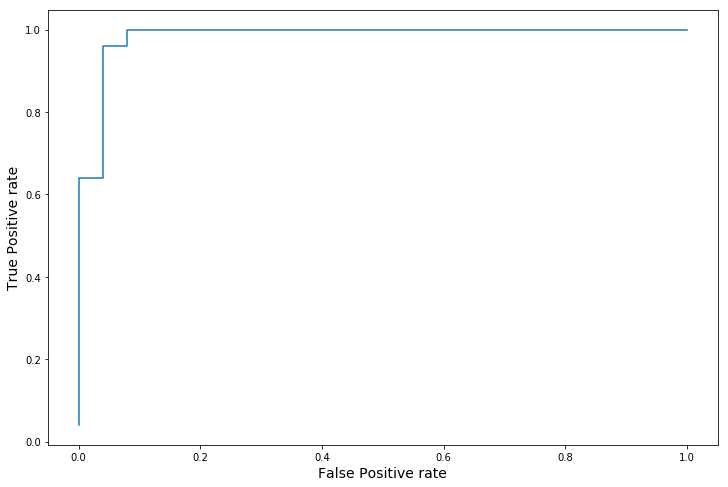

auc = 0.984


,False Positive rate (fixed),False Negative rate
0,0.10,0.0
1,0.15,0.0
2,0.20,0.0
3,0.30,0.0


,False Positive rate (fixed),Threshold,False Positives indexes,False Negatives indexes
0,0.10,0.489701,"P077, P106",P041
1,0.15,0.489701,"P077, P106",P041
2,0.20,0.489701,"P077, P106",P041
3,0.30,0.489701,"P077, P106",P041


,frequency
superiortemporal_ThickStd_r,50
temporalpole_NumVert_r,49
Left-Caudate_normStdDev,49
frontalpole_ThickStd_r,45
caudalanteriorcingulate_MeanCurv_r,38
inferiorparietal_GrayVol_l,33
precentral_ThickStd_l,33
inferiortemporal_ThickAvg_l,31
bankssts_ThickAvg_r,29
parsorbitalis_ThickStd_r,29


Pipeline(memory=None,
     steps=[('Fill_NaN', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), ('StdScaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('dim_reduction', SelectNFeaturesFromModel(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini...alty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])


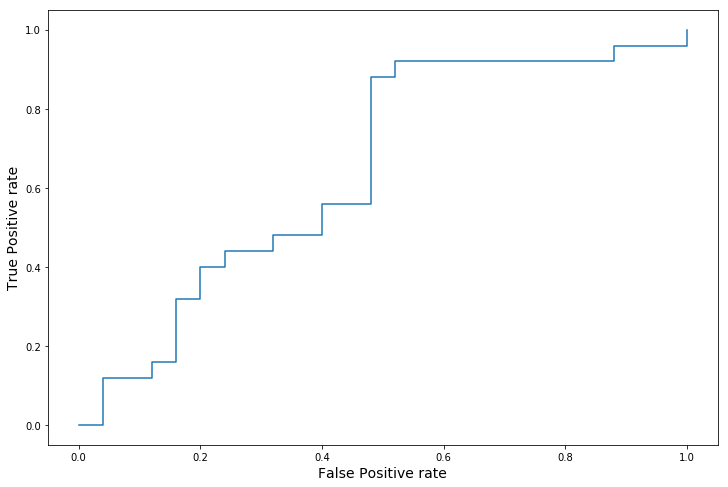

auc = 0.6448


,False Positive rate (fixed),False Negative rate
0,0.10,0.88
1,0.15,0.84
2,0.20,0.60
3,0.30,0.56


,False Positive rate (fixed),Threshold,False Positives indexes,False Negatives indexes
0,0.10,0.524330,P077,"P004, P012, P014, P016, P019, P020, P021, P023, P028, P029, P030, P035, P041, P042, P052, P053, P058, P060, P063, P066, P067, P069, P071"
1,0.15,0.516352,"P037, P046, P077","P004, P012, P014, P016, P019, P020, P021, P023, P028, P029, P030, P035, P042, P052, P053, P058, P060, P063, P066, P067, P069, P071"
2,0.20,0.505492,"P037, P046, P077, P085, P091","P004, P012, P014, P016, P019, P020, P021, P029, P030, P035, P042, P053, P060, P066, P069, P071"
3,0.30,0.504331,"P037, P046, P077, P085, P091, P093","P004, P012, P014, P016, P019, P020, P021, P029, P030, P035, P053, P060, P066, P069, P071"


,frequency
superiortemporal_ThickStd_r,50
temporalpole_NumVert_r,49
Left-Caudate_normStdDev,49
frontalpole_ThickStd_r,45
caudalanteriorcingulate_MeanCurv_r,38
inferiorparietal_GrayVol_l,33
precentral_ThickStd_l,33
inferiortemporal_ThickAvg_l,31
bankssts_ThickAvg_r,29
parsorbitalis_ThickStd_r,29


Pipeline(memory=None,
     steps=[('Fill_NaN', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), ('StdScaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('dim_reduction', SelectNFeaturesFromModel(estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini'...timators=100, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False))])


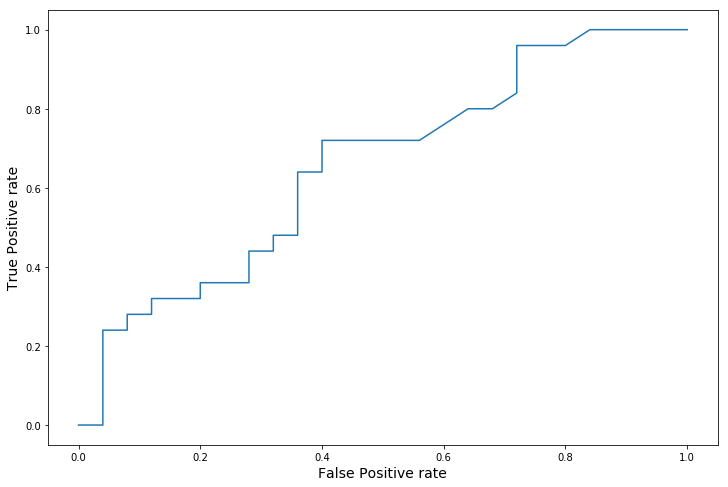

auc = 0.6544


,False Positive rate (fixed),False Negative rate
0,0.10,0.72
1,0.15,0.68
2,0.20,0.64
3,0.30,0.56


,False Positive rate (fixed),Threshold,False Positives indexes,False Negatives indexes
0,0.10,0.73,"P062, P077","P004, P012, P014, P016, P019, P020, P021, P023, P035, P042, P052, P053, P060, P063, P065, P066, P069, P070, P071"
1,0.15,0.70,"P037, P062, P077","P004, P012, P014, P016, P019, P020, P021, P023, P035, P042, P052, P053, P060, P063, P065, P066, P069, P071"
2,0.20,0.65,"P037, P046, P062, P077, P082","P004, P012, P014, P016, P019, P020, P021, P023, P035, P042, P052, P060, P063, P065, P066, P069, P071"
3,0.30,0.58,"P037, P046, P062, P077, P082, P085, P107","P004, P012, P014, P019, P020, P021, P023, P035, P042, P052, P060, P065, P066, P069, P071"


,frequency
inferiortemporal_ThickAvg_l,50
superiortemporal_ThickStd_r,50
frontalpole_ThickStd_r,47
postcentral_CurvInd_l,45
superiorfrontal_ThickStd_r,41
precentral_GausCurv_r,38
precentral_GausCurv_l,36
pericalcarine_GausCurv_r,35
CC_Central_normStdDev,31
4th-Ventricle_normMean,28


Pipeline(memory=None,
     steps=[('Fill_NaN', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), ('StdScaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('dim_reduction', SelectNFeaturesFromModel(estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini'...ski',
           metric_params=None, n_jobs=1, n_neighbors=11, p=1,
           weights='distance'))])


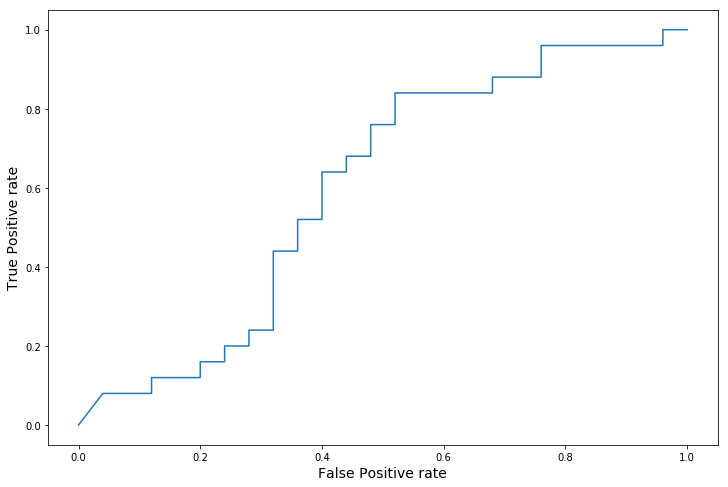

auc = 0.5999999999999999


,False Positive rate (fixed),False Negative rate
0,0.10,0.92
1,0.15,0.88
2,0.20,0.84
3,0.30,0.76


,False Positive rate (fixed),Threshold,False Positives indexes,False Negatives indexes
0,0.10,1.000000,,"P004, P012, P014, P016, P019, P020, P021, P023, P028, P029, P030, P035, P041, P042, P052, P053, P058, P060, P063, P065, P066, P067, P069, P070, P071"
1,0.15,0.902009,"P037, P062, P077","P004, P012, P014, P016, P019, P020, P021, P023, P028, P035, P041, P042, P052, P053, P058, P060, P063, P065, P066, P067, P069, P070, P071"
2,0.20,0.814273,"P037, P046, P062, P077, P085","P004, P012, P014, P016, P019, P020, P021, P023, P028, P035, P042, P052, P053, P058, P060, P063, P065, P066, P067, P069, P070, P071"
3,0.30,0.744541,"P037, P046, P062, P077, P082, P085, P107","P004, P012, P014, P016, P019, P020, P021, P023, P028, P035, P042, P052, P053, P058, P060, P063, P066, P067, P069, P071"


,frequency
inferiortemporal_ThickAvg_l,50
superiortemporal_ThickStd_r,50
frontalpole_ThickStd_r,47
postcentral_CurvInd_l,45
superiorfrontal_ThickStd_r,41
precentral_GausCurv_r,38
precentral_GausCurv_l,36
pericalcarine_GausCurv_r,35
CC_Central_normStdDev,31
4th-Ventricle_normMean,28


In [45]:
for i in range(len(best_model_l)):
    print(best_model_l[i])
    fpr, tpr, t = plot_roc_curve(y, probas_l[i], idx)
    get_fpr_fnr(fpr, tpr)
    get_incorrectly_classified(y, probas_l[i], idx, fpr, t)
    display(features_l[i].iloc[:10])

In [114]:
freq_list=all_features[all_features['frequency_norm']>=0.1]
freq_list=freq_list.reset_index()
freq_list['feature_pure']=''
freq_list['feature_score']=''
appendix_list_thick=['_NumVer
                     t','_GrayVol','_FoldInd','_CurvInd','_GausCurv','_ThickStd','_ThickAvg','_MeanCurv','_SurfArea']
appendix_list_vol=['_Volume_mm3','_normMean','_normMin','_normMax','_normStdDev','_normRange','_NVoxels']
for i in range(len(freq_list)):
    for j in appendix_list_thick:
        if j in freq_list['feature'].loc[i]:
            freq_list['feature_pure'].loc[i]=freq_list['feature'].loc[i].replace(j, '')
            freq_list['feature_score'].loc[i]=freq_list['frequency_norm'].loc[i]/9
    for k in appendix_list_vol:
        if k in freq_list['feature'].loc[i]:
            freq_list['feature_pure'].loc[i]=freq_list['feature'].loc[i].replace(k, '')
            freq_list['feature_score'].loc[i]=freq_list['frequency_norm'].loc[i]/7

freq_pure_list=freq_list[['feature_pure','feature_score']].groupby(['feature_pure']).sum()
freq_pure_list=freq_pure_list.sort_values(['feature_score'], ascending=False)
freq_pure_list[freq_pure_list['feature_score']>=freq_pure_list['feature_score'].max()*0.5]

postcentral_l
pericalcarine_r
inferiortemporal_l
frontalpole_r
superiortemporal_r
paracentral_r
CC_Mid_Anterior
precentral_r
precentral_l
superiorfrontal_r
precentral_r
4th-Ventricle
paracentral_r
parsorbitalis_r
entorhinal_l
precuneus_r
supramarginal_r
Right-Caudate
precentral_r
entorhinal_l
postcentral_l
transversetemporal_l
Right-Cerebellum-White-Matter
temporalpole_l
Left-Cerebellum-White-Matter
CC_Central
fusiform_l
Left-Caudate
fusiform_r
4th-Ventricle
Left-Pallidum
inferiortemporal_r
medialorbitofrontal_r
CSF
temporalpole_l
lingual_r
entorhinal_r
precentral_l
rostralmiddlefrontal_r
Left-Cerebellum-White-Matter
CC_Mid_Anterior
supramarginal_r
parsorbitalis_r
Left-Lateral-Ventricle
parsopercularis_l
parsopercularis_l
4th-Ventricle
bankssts_r
Left-Caudate
inferiorparietal_l
precuneus_l
lateraloccipital_l
inferiortemporal_r
frontalpole_r
Right-Thalamus-Proper
Right-Thalamus-Proper
parstriangularis_l
precentral_l
parsopercularis_r
rostralanteriorcingulate_l
precuneus_l
temporalpole_r

,feature_score
feature_pure,
precentral_r,1.302222
postcentral_l,1.106667
4th-Ventricle,1.088571
paracentral_r,0.946667
precentral_l,0.933333
frontalpole_r,0.817778
Right-Thalamus-Proper,0.791429
parsorbitalis_r,0.751111
Left-Cerebellum-White-Matter,0.742857


In [117]:
all_features, frequent_features, common_frequent_features = get_frequent_features(features_l, classifiers_l, y, p=0.7,file_frequent="T1_sMRI_{}_frequent_{}.csv".format(problem, clf))
display(frequent_features.iloc[:10])
print("common_frequent_features: " + ", ".join(common_frequent_features))
get_frequent_regions(all_features)

,feature
frontalpole_ThickStd_r,4
inferiortemporal_ThickAvg_l,4
superiortemporal_ThickStd_r,4
parsorbitalis_GausCurv_r,3
Left-Pallidum_normMin,3
fusiform_NumVert_r,3
Left-Caudate_normStdDev,3
superiorfrontal_ThickStd_r,3
4th-Ventricle_normMean,3
precentral_ThickStd_l,3


common_frequent_features: frontalpole_ThickStd_r, inferiortemporal_ThickAvg_l, superiortemporal_ThickStd_r, parsorbitalis_GausCurv_r, Left-Pallidum_normMin, fusiform_NumVert_r, Left-Caudate_normStdDev, superiorfrontal_ThickStd_r, 4th-Ventricle_normMean, precentral_ThickStd_l, precentral_CurvInd_r, postcentral_CurvInd_l
                               feature_score
feature_pure                                
precentral_r                        1.315556
4th-Ventricle                       1.122857
postcentral_l                       1.120000
precentral_l                        0.964444
paracentral_r                       0.964444
frontalpole_r                       0.862222
Right-Thalamus-Proper               0.817143
parsorbitalis_r                     0.786667
Left-Cerebellum-White-Matter        0.782857
Left-Caudate                        0.725714
inferiortemporal_l                  0.682222
Right-Cerebellum-White-Matter       0.665714
CC_Mid_Anterior                     0.660000


In [118]:
all_incorr_classified, common_false_positives, common_false_negatives = get_frequent_indexes(probas_l, classifiers_l, y, idx, show=False)
print('False positives for more than 3 clsf',common_false_positives)
print('False negatives for more than 3 clsf',common_false_negatives)

False positives for more than 3 clsf P037, P046, P062, P077, P085
False negatives for more than 3 clsf P004, P012, P014, P016, P019, P020, P021, P023, P028, P029, P030, P035, P041, P042, P052, P053, P058, P060, P063, P065, P066, P067, P069, P070, P071


### 6. Epilepsy with depression / only epilepsy

Target distribution: 
1    22
0    21
Name: DE/E, dtype: int64 

Training SVC...
(training took 427.6845326423645s)

Training LR...
(training took 198.20208191871643s)

Training RFC...
(training took 193.94845509529114s)

Training KNN...
(training took 473.05822134017944s)

Scoring: roc_auc


,best parameters,best dim. reduction method,mean,std
classifier,,,,
SVC,"classifier__C = 1, classifier__gamma = 0.1, classifier__kernel = rbf","SelectNFeaturesFromModel(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, ma...",0.613256,0.195938
LR,"classifier__C = 0.001, classifier__penalty = l2","SelectNFeaturesFromModel(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, ma...",0.547907,0.202580
RFC,classifier__n_estimators = 150,"SelectNFeaturesFromModel(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, ma...",0.558605,0.207358
KNN,"classifier__n_neighbors = 17, classifier__p = 2, classifier__weights = distance","SelectNFeaturesFromModel(estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',\n max_depth=None, max_feat...",0.589535,0.186712


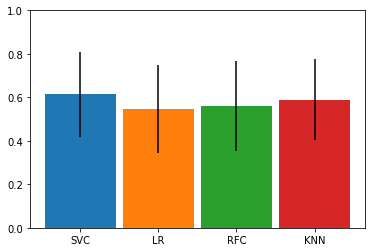

Best model: 
SVC
classifier__C = 1
classifier__gamma = 0.1
classifier__kernel = rbf
dim_reduction = SelectNFeaturesFromModel(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
             n_selected=100, prefit=False)


In [63]:
n_splits = 5
problem = "DE_E"
problem_labels = "DE/E"
pos_label = label_to_idx["DE"]
idx = DE_E_idx
X, y = mri_data[idx], pd.Series(labels[idx][problem_labels] == pos_label, dtype=int)

best_model_mri_DE_E, grid_cv_svc_mri_DE_E, grid_cv_lr_mri_DE_E, grid_cv_rfc_mri_DE_E, grid_cv_knn_mri_DE_E = train_grid_cv(
    X, y, n_splits=n_splits, n_repeats=5, scoring=scoring, random_state=42, n_jobs=1)

In [64]:
grid_cv_l = [grid_cv_svc_mri_DE_E, grid_cv_lr_mri_DE_E, grid_cv_rfc_mri_DE_E, grid_cv_knn_mri_DE_E  ]
best_model_l = [x.best_estimator_ for x in grid_cv_l]
for i, clf in enumerate(classifiers_l):
    save_model(best_model_l[i], "T1_sMRI_{}_best_{}.pkl".format(problem, clf))
save_model(best_model_mri_DE_E, "T1_sMRI_{}.pkl".format(problem))    
    
probas_l = [repeated_cross_val_predict_proba(best_model, X, y, cv=LeaveOneOut(), file="{}_probas_mri_{}.csv".format(classifiers_l[i], problem)) for i, best_model in enumerate(best_model_l)]
feature_sets_l = [get_feature_sets_on_cross_val(X, y, best_model, cv=LeaveOneOut()) for best_model in best_model_l]
features_l = [pd.DataFrame(pd.DataFrame(data=feature_set).stack().reset_index(drop=True).value_counts(), columns=['frequency']) for feature_set in feature_sets_l]

43it [00:00, 93.53it/s]
43it [00:00, 104.14it/s]
43it [00:06,  6.92it/s]
43it [00:04, 10.19it/s]
43it [00:00, 92.32it/s]
43it [00:00, 105.16it/s]
43it [00:05,  7.36it/s]
43it [00:04, 10.59it/s]


Pipeline(memory=None,
     steps=[('Fill_NaN', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), ('StdScaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('dim_reduction', SelectNFeaturesFromModel(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=Tr...bf',
  max_iter=-1, probability=True, random_state=42, shrinking=True,
  tol=0.001, verbose=False))])


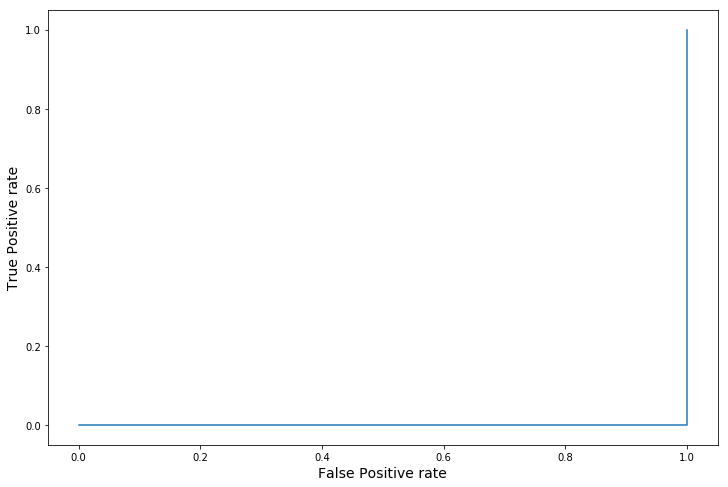

auc = 0.0


,False Positive rate (fixed),False Negative rate
0,0.10,1.0
1,0.15,1.0
2,0.20,1.0
3,0.30,1.0


,False Positive rate (fixed),Threshold,False Positives indexes,False Negatives indexes
0,0.10,1.5,,"P002, P015, P017, P022, P025, P027, P038, P040, P044, P049, P055, P061, P064, P073, P074, P075, P076, P086, P087, P096, P099, P105"
1,0.15,1.5,,"P002, P015, P017, P022, P025, P027, P038, P040, P044, P049, P055, P061, P064, P073, P074, P075, P076, P086, P087, P096, P099, P105"
2,0.20,1.5,,"P002, P015, P017, P022, P025, P027, P038, P040, P044, P049, P055, P061, P064, P073, P074, P075, P076, P086, P087, P096, P099, P105"
3,0.30,1.5,,"P002, P015, P017, P022, P025, P027, P038, P040, P044, P049, P055, P061, P064, P073, P074, P075, P076, P086, P087, P096, P099, P105"


,frequency
postcentral_FoldInd_r,43
isthmuscingulate_MeanCurv_r,43
Brain-Stem_normMax,43
Left-Cerebellum-Cortex_normRange,43
Right-Hippocampus_Volume_mm3,43
Left-Cerebellum-White-Matter_normMin,43
temporalpole_SurfArea_l,43
rostralanteriorcingulate_ThickStd_r,43
fusiform_GausCurv_l,43
parsorbitalis_ThickStd_r,43


Pipeline(memory=None,
     steps=[('Fill_NaN', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), ('StdScaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('dim_reduction', SelectNFeaturesFromModel(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=Tr...alty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])


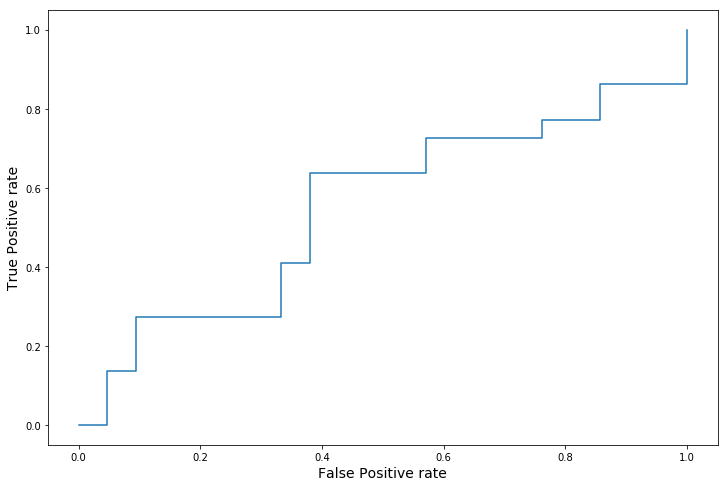

auc = 0.5476190476190477


,False Positive rate (fixed),False Negative rate
0,0.10,0.727273
1,0.15,0.727273
2,0.20,0.727273
3,0.30,0.727273


,False Positive rate (fixed),Threshold,False Positives indexes,False Negatives indexes
0,0.10,0.522218,"P032, P092","P015, P017, P022, P025, P027, P038, P040, P044, P049, P055, P061, P064, P076, P087, P096, P099, P105"
1,0.15,0.522218,"P032, P092","P015, P017, P022, P025, P027, P038, P040, P044, P049, P055, P061, P064, P076, P087, P096, P099, P105"
2,0.20,0.522218,"P032, P092","P015, P017, P022, P025, P027, P038, P040, P044, P049, P055, P061, P064, P076, P087, P096, P099, P105"
3,0.30,0.522218,"P032, P092","P015, P017, P022, P025, P027, P038, P040, P044, P049, P055, P061, P064, P076, P087, P096, P099, P105"


,frequency
postcentral_FoldInd_r,43
isthmuscingulate_MeanCurv_r,43
Brain-Stem_normMax,43
Left-Cerebellum-Cortex_normRange,43
Right-Hippocampus_Volume_mm3,43
Left-Cerebellum-White-Matter_normMin,43
temporalpole_SurfArea_l,43
rostralanteriorcingulate_ThickStd_r,43
fusiform_GausCurv_l,43
parsorbitalis_ThickStd_r,43


Pipeline(memory=None,
     steps=[('Fill_NaN', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), ('StdScaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('dim_reduction', SelectNFeaturesFromModel(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=Tr...timators=150, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False))])


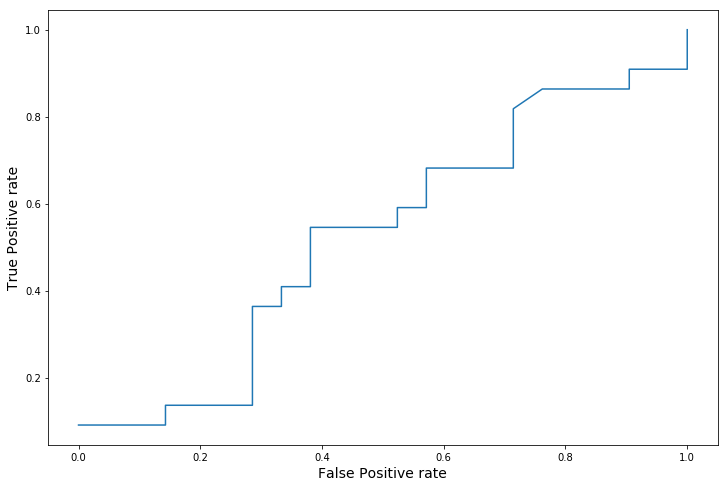

auc = 0.5227272727272727


,False Positive rate (fixed),False Negative rate
0,0.10,0.909091
1,0.15,0.863636
2,0.20,0.863636
3,0.30,0.636364


,False Positive rate (fixed),Threshold,False Positives indexes,False Negatives indexes
0,0.10,0.866667,,"P002, P015, P017, P022, P025, P027, P038, P040, P044, P049, P055, P061, P064, P073, P074, P075, P076, P086, P087, P096, P099, P105"
1,0.15,0.693333,"P003, P024, P092","P002, P015, P017, P022, P025, P027, P038, P040, P044, P049, P055, P061, P064, P073, P076, P086, P087, P096, P099, P105"
2,0.20,0.693333,"P003, P024, P092","P002, P015, P017, P022, P025, P027, P038, P040, P044, P049, P055, P061, P064, P073, P076, P086, P087, P096, P099, P105"
3,0.30,0.606667,"P003, P009, P024, P072, P079, P092","P002, P015, P017, P022, P025, P027, P038, P040, P044, P049, P055, P061, P076, P087, P099"


,frequency
postcentral_FoldInd_r,43
isthmuscingulate_MeanCurv_r,43
Brain-Stem_normMax,43
Left-Cerebellum-Cortex_normRange,43
Right-Hippocampus_Volume_mm3,43
Left-Cerebellum-White-Matter_normMin,43
temporalpole_SurfArea_l,43
rostralanteriorcingulate_ThickStd_r,43
fusiform_GausCurv_l,43
parsorbitalis_ThickStd_r,43


Pipeline(memory=None,
     steps=[('Fill_NaN', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), ('StdScaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('dim_reduction', SelectNFeaturesFromModel(estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini'...ski',
           metric_params=None, n_jobs=1, n_neighbors=17, p=2,
           weights='distance'))])


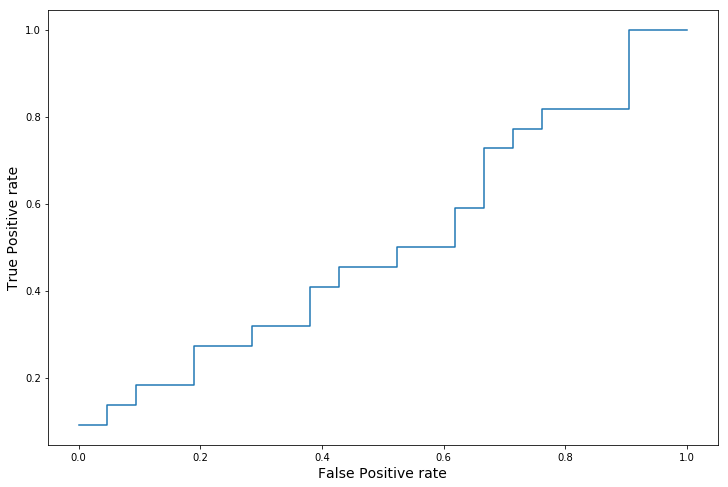

auc = 0.5064935064935066


,False Positive rate (fixed),False Negative rate
0,0.10,0.818182
1,0.15,0.818182
2,0.20,0.727273
3,0.30,0.681818


,False Positive rate (fixed),Threshold,False Positives indexes,False Negatives indexes
0,0.10,0.654276,"P009, P092","P002, P015, P017, P022, P027, P038, P040, P044, P049, P055, P061, P064, P073, P076, P086, P087, P096, P099, P105"
1,0.15,0.654276,"P009, P092","P002, P015, P017, P022, P027, P038, P040, P044, P049, P055, P061, P064, P073, P076, P086, P087, P096, P099, P105"
2,0.20,0.593345,"P009, P068, P079, P092","P015, P017, P022, P027, P038, P040, P044, P049, P055, P061, P064, P073, P076, P086, P087, P099, P105"
3,0.30,0.586666,"P003, P009, P034, P068, P079, P092","P015, P017, P022, P027, P038, P040, P044, P049, P061, P064, P073, P076, P086, P087, P099, P105"


,frequency
Left-Putamen_normStdDev,43
3rd-Ventricle_normMax,43
bankssts_NumVert_r,43
lateralorbitofrontal_GrayVol_r,43
Right-Cerebellum-Cortex_normRange,43
isthmuscingulate_ThickStd_l,43
isthmuscingulate_GausCurv_r,42
superiorfrontal_ThickStd_r,42
pericalcarine_CurvInd_r,41
fusiform_GausCurv_r,41


In [65]:
for i in range(len(best_model_l)):
    print(best_model_l[i])
    fpr, tpr, t = plot_roc_curve(y, probas_l[i], idx)
    get_fpr_fnr(fpr, tpr)
    get_incorrectly_classified(y, probas_l[i], idx, fpr, t)
    display(features_l[i].iloc[:10])

In [66]:
all_features, frequent_features, common_frequent_features = get_frequent_features(features_l, classifiers_l, y, p=0.7)
display(frequent_features.iloc[:10])
print("common_frequent_features: " + ", ".join(common_frequent_features))

,feature
inferiortemporal_ThickStd_l,4
lateralorbitofrontal_GrayVol_r,4
isthmuscingulate_GausCurv_r,4
Right-Cerebellum-Cortex_normRange,4
superiorfrontal_ThickStd_r,4
bankssts_ThickStd_r,4
CC_Mid_Posterior_Volume_mm3,4
isthmuscingulate_MeanCurv_r,4
middletemporal_FoldInd_l,4
Brain-Stem_normMin,4


common_frequent_features: inferiortemporal_ThickStd_l, lateralorbitofrontal_GrayVol_r, isthmuscingulate_GausCurv_r, Right-Cerebellum-Cortex_normRange, superiorfrontal_ThickStd_r, bankssts_ThickStd_r, CC_Mid_Posterior_Volume_mm3, isthmuscingulate_MeanCurv_r, middletemporal_FoldInd_l, Brain-Stem_normMin, Right-vessel_normRange, Brain-Stem_normRange, Left-Cerebellum-Cortex_normRange, Right-Putamen_normStdDev, fusiform_GrayVol_l, 3rd-Ventricle_normMax, insula_ThickStd_r, WM-hypointensities_normStdDev, frontalpole_NumVert_l, Left-Cerebellum-Cortex_normMax, caudalmiddlefrontal_SurfArea_r, Left-Putamen_normRange, parahippocampal_GrayVol_r, fusiform_MeanCurv_r, postcentral_CurvInd_r, rostralanteriorcingulate_GausCurv_r, bankssts_GausCurv_l, transversetemporal_CurvInd_r, caudalmiddlefrontal_GrayVol_r, transversetemporal_FoldInd_r, posteriorcingulate_SurfArea_r, bankssts_CurvInd_l, caudalmiddlefrontal_GausCurv_r, cuneus_GrayVol_l, parsorbitalis_ThickStd_r, cuneus_ThickAvg_l, temporalpole_NumVert

In [67]:
all_incorr_classified, common_false_positives, common_false_negatives = get_frequent_indexes(probas_l, classifiers_l, y, idx, show=False)
print('False positives for more than 3 clsf',common_false_positives)
print('False negatives for more than 3 clsf',common_false_negatives)

False positives for more than 3 clsf P092
False negatives for more than 3 clsf P002, P015, P017, P022, P025, P027, P038, P040, P044, P049, P055, P061, P064, P073, P076, P086, P087, P096, P099, P105


In [ ]:
Right-Cerebellum-White-Matter_normMean, Right-Thalamus-Proper_normMean, Left-Accumbens-area_normMax, lateraloccipital_GausCurv_l, postcentral_ThickAvg_l, lingual_GausCurv_r, superiorfrontal_MeanCurv_l, CC_Mid_Posterior_normMean, isthmuscingulate_ThickAvg_l, Right-Pallidum_normMean, lateraloccipital_GausCurv_r, entorhinal_ThickAvg_l, isthmuscingulate_MeanCurv_l, CC_Anterior_normMean, Right-Thalamus-Proper_normMax, bankssts_ThickAvg_l, cuneus_ThickAvg_l, inferiortemporal_MeanCurv_r, caudalanteriorcingulate_ThickAvg_l, Left-Putamen_normMax, supramarginal_MeanCurv_r, inferiortemporal_ThickAvg_l, lateraloccipital_MeanCurv_r

In [50]:
mri_data1=mri_data[['Right-Cerebellum-White-Matter_normMean', 'Right-Thalamus-Proper_normMean', 'Left-Accumbens-area_normMax', 'lateraloccipital_GausCurv_l', 'postcentral_ThickAvg_l', 'lingual_GausCurv_r', 'superiorfrontal_MeanCurv_l', 'CC_Mid_Posterior_normMean', 'isthmuscingulate_ThickAvg_l', 'Right-Pallidum_normMean', 'lateraloccipital_GausCurv_r', 'entorhinal_ThickAvg_l', 'isthmuscingulate_MeanCurv_l', 'CC_Anterior_normMean', 'Right-Thalamus-Proper_normMax', 'bankssts_ThickAvg_l', 'cuneus_ThickAvg_l', 'inferiortemporal_MeanCurv_r', 'caudalanteriorcingulate_ThickAvg_l', 'Left-Putamen_normMax', 'supramarginal_MeanCurv_r', 'inferiortemporal_ThickAvg_l', 'lateraloccipital_MeanCurv_r']]

Target distribution: 
1    25
0    25
Name: DE/E, dtype: int64 

Training SVC...
(training took 98.55938363075256s)

Training LR...
(training took 33.085047245025635s)

Training RFC...
(training took 100.9097375869751s)

Training KNN...
(training took 161.3069291114807s)

Scoring: roc_auc


,best parameters,best dim. reduction method,mean,std
classifier,,,,
SVC,"classifier__C = 100, classifier__gamma = 0.01, classifier__kernel = rbf","SelectNFeaturesFromModel(estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',\n max_depth=None, max_feat...",0.6288,0.166861
LR,"classifier__C = 0.0001, classifier__penalty = l1","SelectKBest(k=20, score_func=<function ttest_ind at 0x000001C9BD74DB70>)",0.5000,0.000000
RFC,classifier__n_estimators = 100,"SelectKBest(k=20, score_func=<function f_classif at 0x000001C9BE8831E0>)",0.4944,0.171349
KNN,"classifier__n_neighbors = 23, classifier__p = 2, classifier__weights = uniform","SelectKBest(k=20, score_func=<function ttest_ind at 0x000001C9BD74DB70>)",0.5456,0.198113


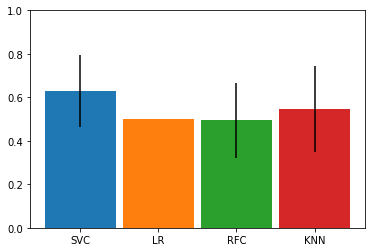

Best model: 
SVC
classifier__C = 100
classifier__gamma = 0.01
classifier__kernel = rbf
dim_reduction = SelectNFeaturesFromModel(estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
             n_selected=20, prefit=False)


In [51]:
n_splits = 5
problem = "DE_E"
problem_labels = "DE/E"
pos_label = label_to_idx["DE"]
idx = DE_E_idx
X, y = mri_data1[idx], pd.Series(labels[idx][problem_labels] == pos_label, dtype=int)

best_model_mri_DE_E, grid_cv_svc_mri_DE_E, grid_cv_lr_mri_DE_E, grid_cv_rfc_mri_DE_E, grid_cv_knn_mri_DE_E = train_grid_cv(
    X, y, n_splits=n_splits, n_repeats=5, scoring=scoring, random_state=42, n_jobs=1)

### 6.2. Epilepsy with depression / only depression

Target distribution: 
1    25
0    25
Name: DE/D, dtype: int64 

Training SVC...
(training took 123.45026230812073s)

Training LR...
(training took 43.26464772224426s)

Training RFC...
(training took 94.20077538490295s)

Training KNN...
(training took 200.65216755867004s)

Scoring: roc_auc


,best parameters,best dim. reduction method,mean,std
classifier,,,,
SVC,"classifier__C = 1, classifier__gamma = 0.01, classifier__kernel = rbf","SelectNFeaturesFromModel(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',\n max_depth=None, max_fe...",0.7648,0.147217
LR,"classifier__C = 0.001, classifier__penalty = l2","SelectKBest(k=30, score_func=<function f_classif at 0x000001C9BE8831E0>)",0.7280,0.147513
RFC,classifier__n_estimators = 160,"SelectKBest(k=30, score_func=<function f_classif at 0x000001C9BE8831E0>)",0.7520,0.158795
KNN,"classifier__n_neighbors = 23, classifier__p = 1, classifier__weights = distance","SelectNFeaturesFromModel(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',\n max_depth=None, max_fe...",0.7840,0.119197


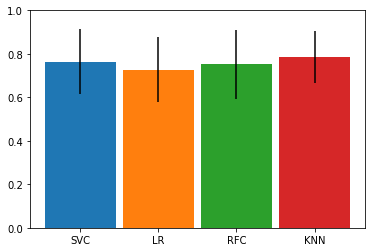

Best model: 
KNN
classifier__n_neighbors = 23
classifier__p = 1
classifier__weights = distance
dim_reduction = SelectNFeaturesFromModel(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
             n_selected=30, prefit=False)


In [42]:
n_splits = 5
problem = "DE_D"
problem_labels = "DE/D"
pos_label = label_to_idx["DE"]
idx = DE_D_idx
X, y = mri_data[idx], pd.Series(labels[idx][problem_labels] == pos_label, dtype=int)

best_model_mri_DE_D, grid_cv_svc_mri_DE_D, grid_cv_lr_mri_DE_D, grid_cv_rfc_mri_DE_D, grid_cv_knn_mri_DE_D= train_grid_cv(
    X, y, n_splits=n_splits, n_repeats=5, scoring=scoring, random_state=42, n_jobs=1)

In [43]:
grid_cv_l = [grid_cv_svc_mri_DE_D, grid_cv_lr_mri_DE_D, grid_cv_rfc_mri_DE_D, grid_cv_knn_mri_DE_D]
best_model_l = [x.best_estimator_ for x in grid_cv_l]
for i, clf in enumerate(classifiers_l):
    save_model(best_model_l[i], "T1_sMRI_{}_best_{}.pkl".format(problem, clf))
save_model(best_model_mri_DE_D, "T1_sMRI_{}.pkl".format(problem))    
    
probas_l = [repeated_cross_val_predict_proba(best_model, X, y, cv=LeaveOneOut(), file="{}_probas_mri_{}.csv".format(classifiers_l[i], problem)) for i, best_model in enumerate(best_model_l)]
feature_sets_l = [get_feature_sets_on_cross_val(X, y, best_model, cv=LeaveOneOut()) for best_model in best_model_l]
features_l = [pd.DataFrame(pd.DataFrame(data=feature_set).stack().reset_index(drop=True).value_counts(), columns=['frequency']) for feature_set in feature_sets_l]

50it [00:06,  7.18it/s]
50it [00:00, 127.89it/s]
50it [00:08,  5.67it/s]
50it [00:06,  8.06it/s]
50it [00:07,  6.26it/s]
50it [00:00, 96.41it/s]
50it [00:09,  5.23it/s]
50it [00:07,  7.06it/s]


Pipeline(memory=None,
     steps=[('Fill_NaN', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), ('StdScaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('dim_reduction', SelectNFeaturesFromModel(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini...bf',
  max_iter=-1, probability=True, random_state=42, shrinking=True,
  tol=0.001, verbose=False))])


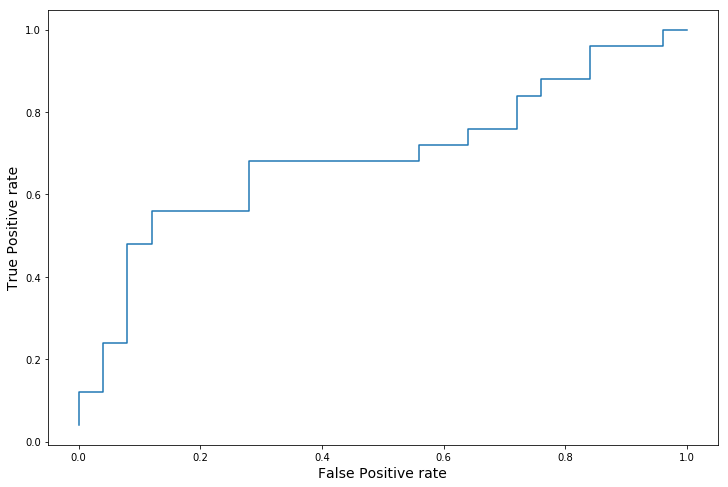

auc = 0.6912


,False Positive rate (fixed),False Negative rate
0,0.10,0.52
1,0.15,0.44
2,0.20,0.44
3,0.30,0.32


,False Positive rate (fixed),Threshold,False Positives indexes,False Negatives indexes
0,0.10,0.756043,"P021, P035","P002, P015, P017, P040, P044, P049, P061, P073, P074, P075, P086, P087, P088, P096"
1,0.15,0.668098,"P016, P021, P035","P015, P040, P044, P049, P061, P073, P074, P075, P086, P087, P088, P096"
2,0.20,0.668098,"P016, P021, P035","P015, P040, P044, P049, P061, P073, P074, P075, P086, P087, P088, P096"
3,0.30,0.479385,"P016, P019, P021, P035, P041, P052, P053","P015, P044, P049, P061, P073, P074, P086, P087, P096"


,frequency
Left-Caudate_normStdDev,50
Right-Cerebellum-Cortex_normMax,49
Left-Cerebellum-White-Matter_normStdDev,45
Left-Thalamus-Proper_normStdDev,43
Left-Caudate_normRange,42
postcentral_CurvInd_l,36
superiortemporal_ThickStd_r,36
Right-Cerebellum-Cortex_normRange,35
fusiform_CurvInd_l,35
Left-Caudate_normMax,34


Pipeline(memory=None,
     steps=[('Fill_NaN', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), ('StdScaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('dim_reduction', SelectKBest(k=30, score_func=<function f_classif at 0x000001C9BE8831E0>)), ('classifier', LogisticRegression...alty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])


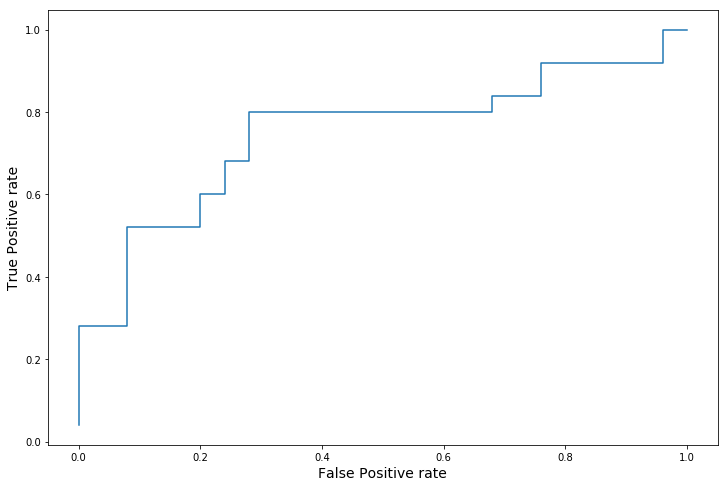

auc = 0.7472000000000001


,False Positive rate (fixed),False Negative rate
0,0.10,0.48
1,0.15,0.48
2,0.20,0.40
3,0.30,0.20


,False Positive rate (fixed),Threshold,False Positives indexes,False Negatives indexes
0,0.10,0.514027,"P021, P035","P015, P017, P022, P038, P044, P048, P049, P061, P073, P086, P087, P088, P096"
1,0.15,0.514027,"P021, P035","P015, P017, P022, P038, P044, P048, P049, P061, P073, P086, P087, P088, P096"
2,0.20,0.500670,"P019, P021, P035, P052, P053","P015, P017, P044, P048, P049, P061, P073, P086, P087, P088, P096"
3,0.30,0.490010,"P016, P019, P020, P021, P035, P052, P053","P015, P049, P061, P073, P087, P096"


,frequency
rostralmiddlefrontal_CurvInd_r,50
postcentral_FoldInd_l,50
Right-Caudate_normStdDev,50
parsorbitalis_GausCurv_r,50
WM-hypointensities_Volume_mm3,50
paracentral_MeanCurv_l,50
Left-Caudate_normMax,50
precentral_ThickAvg_r,50
postcentral_CurvInd_l,50
Left-Cerebellum-White-Matter_normStdDev,50


Pipeline(memory=None,
     steps=[('Fill_NaN', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), ('StdScaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('dim_reduction', SelectKBest(k=30, score_func=<function f_classif at 0x000001C9BE8831E0>)), ('classifier', RandomForestClassi...timators=160, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False))])


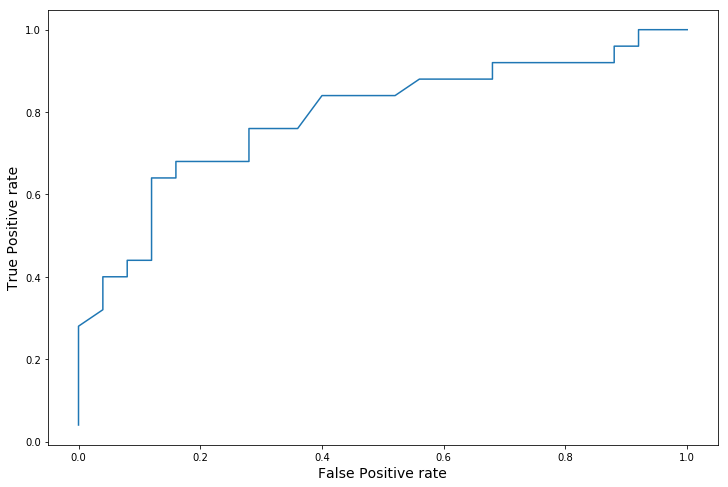

auc = 0.7888


,False Positive rate (fixed),False Negative rate
0,0.10,0.56
1,0.15,0.36
2,0.20,0.32
3,0.30,0.24


,False Positive rate (fixed),Threshold,False Positives indexes,False Negatives indexes
0,0.10,0.72500,"P021, P035","P002, P015, P017, P022, P040, P044, P048, P049, P061, P073, P074, P086, P087, P088, P096"
1,0.15,0.61250,"P019, P021, P035","P015, P017, P022, P048, P049, P061, P073, P086, P087, P088, P096"
2,0.20,0.59375,"P019, P021, P035, P053","P015, P017, P048, P049, P061, P073, P087, P088, P096"
3,0.30,0.37500,"P016, P019, P020, P021, P035, P052, P053","P015, P017, P049, P061, P073, P088, P096"


,frequency
rostralmiddlefrontal_CurvInd_r,50
postcentral_FoldInd_l,50
Right-Caudate_normStdDev,50
parsorbitalis_GausCurv_r,50
WM-hypointensities_Volume_mm3,50
paracentral_MeanCurv_l,50
Left-Caudate_normMax,50
precentral_ThickAvg_r,50
postcentral_CurvInd_l,50
Left-Cerebellum-White-Matter_normStdDev,50


Pipeline(memory=None,
     steps=[('Fill_NaN', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), ('StdScaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('dim_reduction', SelectNFeaturesFromModel(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini...ski',
           metric_params=None, n_jobs=1, n_neighbors=23, p=1,
           weights='distance'))])


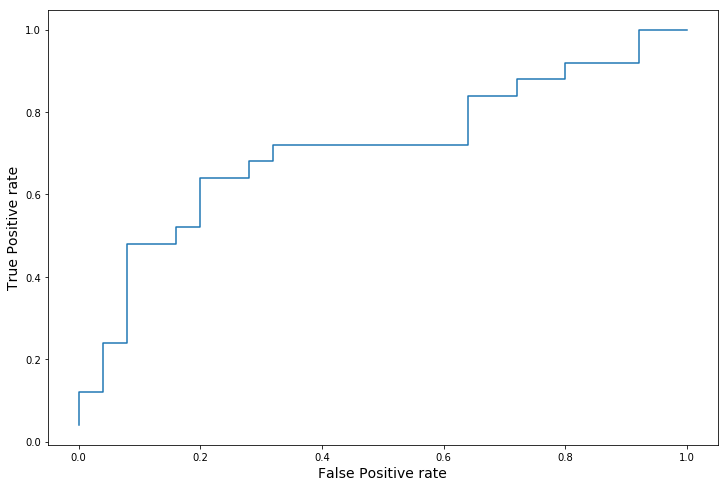

auc = 0.7104


,False Positive rate (fixed),False Negative rate
0,0.10,0.52
1,0.15,0.52
2,0.20,0.36
3,0.30,0.32


,False Positive rate (fixed),Threshold,False Positives indexes,False Negatives indexes
0,0.10,0.457575,"P021, P035","P002, P015, P017, P022, P040, P044, P049, P061, P073, P074, P086, P087, P088, P096"
1,0.15,0.457575,"P021, P035","P002, P015, P017, P022, P040, P044, P049, P061, P073, P074, P086, P087, P088, P096"
2,0.20,0.377934,"P016, P021, P035, P041, P065","P015, P017, P040, P044, P049, P061, P073, P074, P087, P096"
3,0.30,0.362401,"P016, P021, P035, P041, P053, P063, P065","P015, P040, P044, P049, P061, P073, P074, P087, P096"


,frequency
Left-Caudate_normStdDev,50
Right-Cerebellum-Cortex_normMax,49
Left-Cerebellum-White-Matter_normStdDev,45
Left-Thalamus-Proper_normStdDev,43
Left-Caudate_normRange,42
postcentral_CurvInd_l,36
superiortemporal_ThickStd_r,36
Right-Cerebellum-Cortex_normRange,35
fusiform_CurvInd_l,35
Left-Caudate_normMax,34


In [44]:
for i in range(len(best_model_l)):
    print(best_model_l[i])
    fpr, tpr, t = plot_roc_curve(y, probas_l[i], idx)
    get_fpr_fnr(fpr, tpr)
    get_incorrectly_classified(y, probas_l[i], idx, fpr, t)
    display(features_l[i].iloc[:10])

In [45]:
all_features, frequent_features, common_frequent_features = get_frequent_features(features_l, classifiers_l, y, p=0.7)
display(frequent_features.iloc[:10])
print("common_frequent_features: " + ", ".join(common_frequent_features))

,feature
superiortemporal_ThickStd_r,4
Left-Caudate_normStdDev,4
postcentral_CurvInd_l,4
Left-Cerebellum-White-Matter_normStdDev,4
Left-Thalamus-Proper_normStdDev,4
Right-Cerebellum-Cortex_normMax,4
rostralmiddlefrontal_CurvInd_r,2
postcentral_MeanCurv_r,2
caudalmiddlefrontal_CurvInd_r,2
Right-Caudate_normStdDev,2


common_frequent_features: superiortemporal_ThickStd_r, Left-Caudate_normStdDev, postcentral_CurvInd_l, Left-Cerebellum-White-Matter_normStdDev, Left-Thalamus-Proper_normStdDev, Right-Cerebellum-Cortex_normMax


In [46]:
all_incorr_classified, common_false_positives, common_false_negatives = get_frequent_indexes(probas_l, classifiers_l, y, idx, show=False)
print('False positives for more than 3 clsf',common_false_positives)
print('False negatives for more than 3 clsf',common_false_negatives)

False positives for more than 3 clsf P016, P019, P021, P035, P052, P053
False negatives for more than 3 clsf P002, P015, P017, P022, P040, P044, P049, P061, P073, P074, P086, P087, P088, P096


### 7. TLE / no epilepsy

Target distribution: 
0    47
1    24
Name: TLE/no E, dtype: int64 

Training SVC...
(training took 491.9427328109741s)

Training LR...
(training took 215.19764137268066s)

Training RFC...
(training took 203.49094343185425s)

Training KNN...
(training took 630.1891434192657s)

Scoring: roc_auc


,best parameters,best dim. reduction method,mean,std
classifier,,,,
SVC,"classifier__C = 1, classifier__gamma = 0.1, classifier__kernel = rbf","SelectNFeaturesFromModel(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, ma...",0.773959,0.144786
LR,"classifier__C = 1, classifier__penalty = l2","SelectNFeaturesFromModel(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',\n max_depth=None, max_fe...",0.729139,0.154601
RFC,classifier__n_estimators = 180,"SelectNFeaturesFromModel(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, ma...",0.774116,0.184645
KNN,"classifier__n_neighbors = 17, classifier__p = 1, classifier__weights = distance","SelectNFeaturesFromModel(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, ma...",0.743897,0.179413


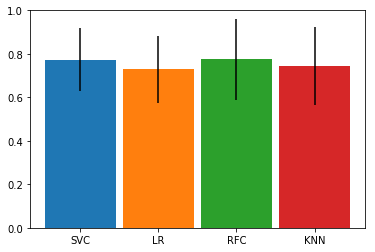

Best model: 
RFC
classifier__n_estimators = 180
dim_reduction = SelectNFeaturesFromModel(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
             n_selected=10, prefit=False)


In [73]:
n_splits = 5
problem = "TLE_noE"
problem_labels = "TLE/no E"
pos_label = label_to_idx["TLE"]
idx = TLE_noE_idx
X, y = mri_data[idx], pd.Series(labels[idx][problem_labels] == pos_label, dtype=int)

best_model_mri_TLE_noE, grid_cv_svc_mri_TLE_noE, grid_cv_lr_mri_TLE_noE, grid_cv_rfc_mri_TLE_noE, grid_cv_knn_mri_TLE_noE= train_grid_cv(
    X, y, n_splits=n_splits, n_repeats=5, scoring=scoring, random_state=42, n_jobs=1)

In [74]:
grid_cv_l = [ grid_cv_svc_mri_TLE_noE, grid_cv_lr_mri_TLE_noE, grid_cv_rfc_mri_TLE_noE, grid_cv_knn_mri_TLE_noE]
best_model_l = [x.best_estimator_ for x in grid_cv_l]
for i, clf in enumerate(classifiers_l):
    save_model(best_model_l[i], "T1_sMRI_{}_best_{}.pkl".format(problem, clf))
save_model(best_model_mri_TLE_noE, "T1_sMRI_{}.pkl".format(problem))    
    
probas_l = [repeated_cross_val_predict_proba(best_model, X, y, cv=LeaveOneOut(), file="{}_probas_mri_{}.csv".format(classifiers_l[i], problem)) for i, best_model in enumerate(best_model_l)]
feature_sets_l = [get_feature_sets_on_cross_val(X, y, best_model, cv=LeaveOneOut()) for best_model in best_model_l]
features_l = [pd.DataFrame(pd.DataFrame(data=feature_set).stack().reset_index(drop=True).value_counts(), columns=['frequency']) for feature_set in feature_sets_l]

71it [00:01, 53.25it/s]
71it [00:09,  7.47it/s]
71it [00:14,  5.03it/s]
71it [00:01, 46.84it/s]
71it [00:01, 51.93it/s]
71it [00:10,  6.69it/s]
71it [00:13,  5.29it/s]
71it [00:01, 63.05it/s]


Pipeline(memory=None,
     steps=[('Fill_NaN', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), ('StdScaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('dim_reduction', SelectNFeaturesFromModel(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=Tr...bf',
  max_iter=-1, probability=True, random_state=42, shrinking=True,
  tol=0.001, verbose=False))])


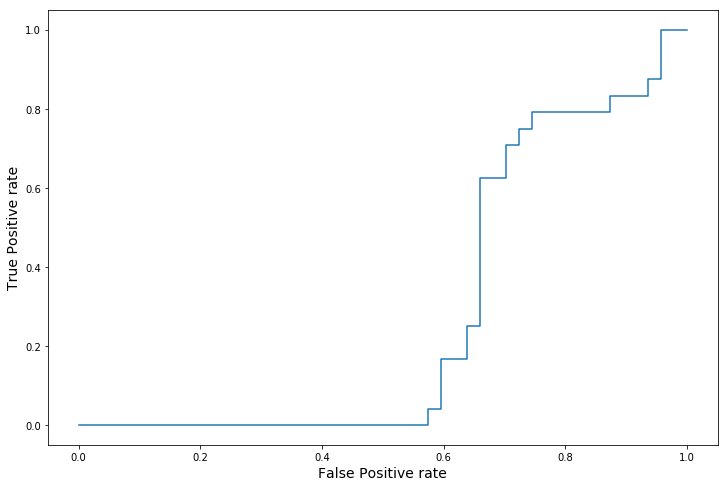

auc = 0.2863475177304965


,False Positive rate (fixed),False Negative rate
0,0.10,1.0
1,0.15,1.0
2,0.20,1.0
3,0.30,1.0


,False Positive rate (fixed),Threshold,False Positives indexes,False Negatives indexes
0,0.10,0.360301,,"P001, P003, P011, P022, P024, P025, P026, P027, P032, P038, P039, P044, P045, P049, P055, P056, P064, P073, P074, P075, P076, P079, P087, P105"
1,0.15,0.360301,,"P001, P003, P011, P022, P024, P025, P026, P027, P032, P038, P039, P044, P045, P049, P055, P056, P064, P073, P074, P075, P076, P079, P087, P105"
2,0.20,0.360301,,"P001, P003, P011, P022, P024, P025, P026, P027, P032, P038, P039, P044, P045, P049, P055, P056, P064, P073, P074, P075, P076, P079, P087, P105"
3,0.30,0.360301,,"P001, P003, P011, P022, P024, P025, P026, P027, P032, P038, P039, P044, P045, P049, P055, P056, P064, P073, P074, P075, P076, P079, P087, P105"


,frequency
lateraloccipital_ThickStd_r,71
transversetemporal_FoldInd_r,71
postcentral_FoldInd_r,71
temporalpole_SurfArea_l,71
supramarginal_NumVert_r,71
Left-Cerebellum-Cortex_normStdDev,71
Right-Amygdala_NVoxels,71
Left-Amygdala_normMean,71
parsopercularis_MeanCurv_r,71
Right-choroid-plexus_normRange,71


Pipeline(memory=None,
     steps=[('Fill_NaN', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), ('StdScaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('dim_reduction', SelectNFeaturesFromModel(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini...alty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])


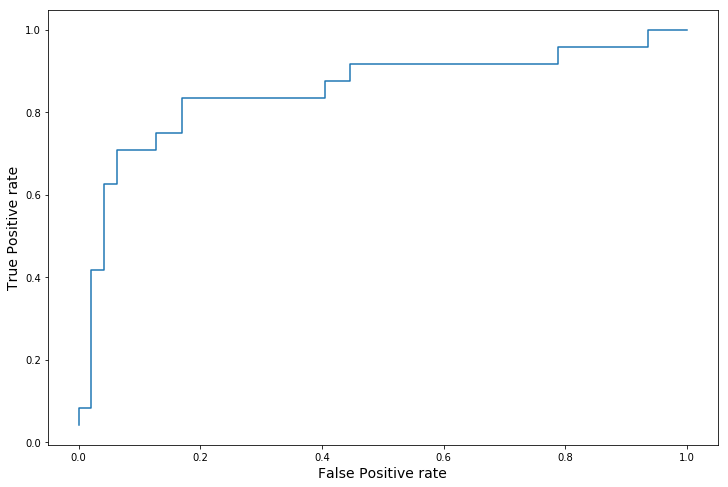

auc = 0.851950354609929


,False Positive rate (fixed),False Negative rate
0,0.10,0.291667
1,0.15,0.250000
2,0.20,0.166667
3,0.30,0.166667


,False Positive rate (fixed),Threshold,False Positives indexes,False Negatives indexes
0,0.10,0.691364,"P035, P041, P093","P024, P038, P044, P045, P049, P064, P073, P079"
1,0.15,0.477853,"P021, P035, P041, P051, P070, P093","P024, P038, P044, P049, P064, P073, P079"
2,0.20,0.346597,"P019, P021, P035, P041, P047, P051, P070, P093","P024, P038, P044, P049, P073"
3,0.30,0.346597,"P019, P021, P035, P041, P047, P051, P070, P093","P024, P038, P044, P049, P073"


,frequency
caudalanteriorcingulate_NumVert_r,71
parstriangularis_MeanCurv_l,71
parstriangularis_CurvInd_r,71
Left-Cerebellum-White-Matter_normStdDev,71
Right-choroid-plexus_Volume_mm3,71
Right-Cerebellum-White-Matter_normStdDev,71
entorhinal_ThickStd_l,71
CC_Mid_Posterior_normMean,71
Right-Cerebellum-Cortex_normStdDev,71
Left-Cerebellum-Cortex_normStdDev,70


Pipeline(memory=None,
     steps=[('Fill_NaN', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), ('StdScaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('dim_reduction', SelectNFeaturesFromModel(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=Tr...timators=180, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False))])


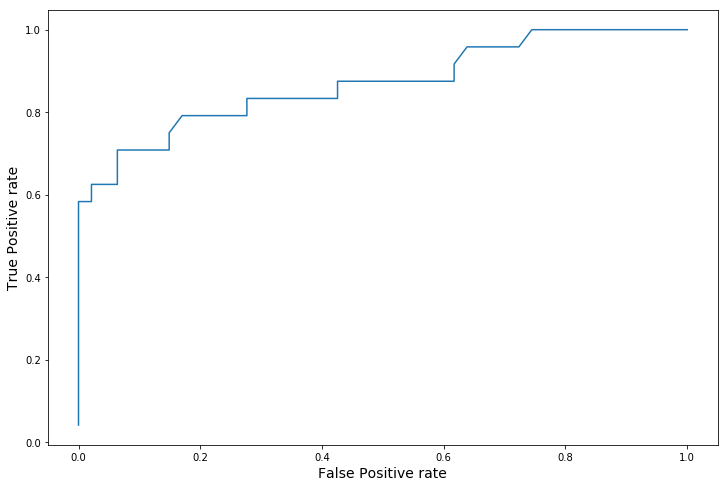

auc = 0.8692375886524824


,False Positive rate (fixed),False Negative rate
0,0.10,0.291667
1,0.15,0.250000
2,0.20,0.208333
3,0.30,0.166667


,False Positive rate (fixed),Threshold,False Positives indexes,False Negatives indexes
0,0.10,0.522222,"P035, P062, P093","P022, P024, P038, P045, P049, P064, P073, P076"
1,0.15,0.461111,"P019, P023, P028, P035, P047, P062, P093","P022, P024, P038, P049, P064, P073, P076"
2,0.20,0.455556,"P019, P023, P028, P035, P047, P062, P093","P022, P024, P038, P049, P073, P076"
3,0.30,0.305556,"P008, P019, P023, P028, P035, P037, P041, P047, P062, P063, P069, P070, P093","P022, P038, P049, P073, P076"


,frequency
entorhinal_ThickStd_l,71
Right-Cerebellum-Cortex_normStdDev,71
parsopercularis_MeanCurv_r,71
Right-Cerebellum-White-Matter_normStdDev,71
Left-Cerebellum-Cortex_normStdDev,71
temporalpole_SurfArea_l,69
postcentral_FoldInd_r,67
Right-Amygdala_Volume_mm3,58
transversetemporal_NumVert_r,58
lateraloccipital_ThickStd_r,45


Pipeline(memory=None,
     steps=[('Fill_NaN', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), ('StdScaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('dim_reduction', SelectNFeaturesFromModel(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=Tr...ski',
           metric_params=None, n_jobs=1, n_neighbors=17, p=1,
           weights='distance'))])


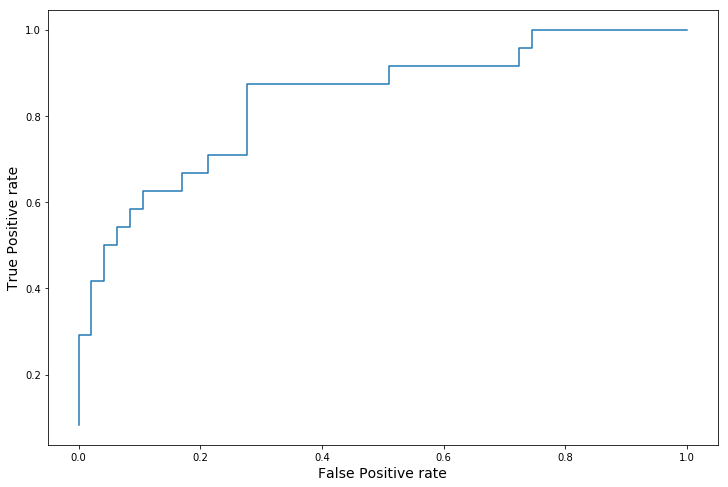

auc = 0.8386524822695035


,False Positive rate (fixed),False Negative rate
0,0.10,0.416667
1,0.15,0.375000
2,0.20,0.333333
3,0.30,0.125000


,False Positive rate (fixed),Threshold,False Positives indexes,False Negatives indexes
0,0.10,0.307011,"P035, P047, P062, P093","P003, P022, P024, P026, P038, P044, P045, P049, P064, P073, P076"
1,0.15,0.300746,"P035, P041, P047, P062, P093","P003, P022, P024, P026, P038, P044, P049, P064, P073, P076"
2,0.20,0.270982,"P008, P023, P035, P041, P047, P062, P082, P093","P003, P022, P024, P026, P038, P049, P064, P073, P076"
3,0.30,0.170070,"P008, P018, P019, P023, P035, P041, P047, P062, P069, P070, P071, P082, P093","P022, P038, P049, P073"


,frequency
entorhinal_ThickStd_l,71
Right-Cerebellum-Cortex_normStdDev,71
parsopercularis_MeanCurv_r,71
Right-Cerebellum-White-Matter_normStdDev,71
Left-Cerebellum-Cortex_normStdDev,71
temporalpole_SurfArea_l,69
postcentral_FoldInd_r,67
Right-Amygdala_Volume_mm3,58
transversetemporal_NumVert_r,58
lateraloccipital_ThickStd_r,45


In [75]:
for i in range(len(best_model_l)):
    print(best_model_l[i])
    fpr, tpr, t = plot_roc_curve(y, probas_l[i], idx)
    get_fpr_fnr(fpr, tpr)
    get_incorrectly_classified(y, probas_l[i], idx, fpr, t)
    display(features_l[i].iloc[:10])

In [76]:
all_features, frequent_features, common_frequent_features = get_frequent_features(features_l, classifiers_l, y, p=0.7)
display(frequent_features.iloc[:10])
print("common_frequent_features: " + ", ".join(common_frequent_features))

,feature
Right-Cerebellum-White-Matter_normStdDev,4
entorhinal_ThickStd_l,4
Right-Cerebellum-Cortex_normStdDev,4
parsopercularis_MeanCurv_r,4
Left-Cerebellum-Cortex_normStdDev,4
temporalpole_SurfArea_l,3
Right-Amygdala_Volume_mm3,3
postcentral_FoldInd_r,3
transversetemporal_NumVert_r,3
parsopercularis_FoldInd_r,2


common_frequent_features: Right-Cerebellum-White-Matter_normStdDev, entorhinal_ThickStd_l, Right-Cerebellum-Cortex_normStdDev, parsopercularis_MeanCurv_r, Left-Cerebellum-Cortex_normStdDev, temporalpole_SurfArea_l, Right-Amygdala_Volume_mm3, postcentral_FoldInd_r, transversetemporal_NumVert_r


In [77]:
all_incorr_classified, common_false_positives, common_false_negatives = get_frequent_indexes(probas_l, classifiers_l, y, idx, show=False)
print('False positives for more than 3 clsf',common_false_positives)
print('False negatives for more than 3 clsf',common_false_negatives)

False positives for more than 3 clsf P019, P035, P041, P047, P070, P093
False negatives for more than 3 clsf P022, P024, P038, P044, P045, P049, P064, P073, P076


### 8. TLE / control

Target distribution: 
1    24
0    23
Name: TLE/C, dtype: int64 

Training SVC...
(training took 433.18087244033813s)

Training LR...
(training took 196.04185819625854s)

Training RFC...
(training took 194.07810878753662s)

Training KNN...
(training took 573.0139787197113s)

Scoring: roc_auc


,best parameters,best dim. reduction method,mean,std
classifier,,,,
SVC,"classifier__C = 1, classifier__gamma = 0.01, classifier__kernel = rbf","SelectNFeaturesFromModel(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, ma...",0.888936,0.108446
LR,"classifier__C = 0.001, classifier__penalty = l2","SelectNFeaturesFromModel(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, ma...",0.856596,0.135140
RFC,classifier__n_estimators = 150,"SelectNFeaturesFromModel(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, ma...",0.820319,0.130084
KNN,"classifier__n_neighbors = 14, classifier__p = 2, classifier__weights = distance","SelectNFeaturesFromModel(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, ma...",0.876809,0.107141


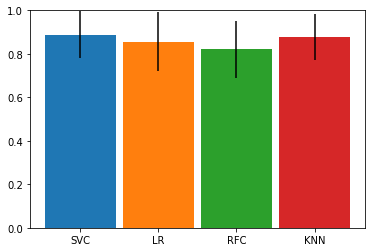

Best model: 
SVC
classifier__C = 1
classifier__gamma = 0.01
classifier__kernel = rbf
dim_reduction = SelectNFeaturesFromModel(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
             n_selected=50, prefit=False)


In [78]:
n_splits = 5
problem = "TLE_С"
problem_labels = "TLE/C"
pos_label = label_to_idx["TLE"]
idx = TLE_C_idx
X, y = mri_data[idx], pd.Series(labels[idx][problem_labels] == pos_label, dtype=int)

best_model_mri_TLE_C, grid_cv_svc_mri_TLE_C, grid_cv_lr_mri_TLE_C, grid_cv_rfc_mri_TLE_C, grid_cv_knn_mri_TLE_C= train_grid_cv(
    X, y, n_splits=n_splits, n_repeats=5, scoring=scoring, random_state=42, n_jobs=1)

In [79]:
grid_cv_l = [grid_cv_svc_mri_TLE_C, grid_cv_lr_mri_TLE_C, grid_cv_rfc_mri_TLE_C, grid_cv_knn_mri_TLE_C]
best_model_l = [x.best_estimator_ for x in grid_cv_l]
for i, clf in enumerate(classifiers_l):
    save_model(best_model_l[i], "T1_sMRI_{}_best_{}.pkl".format(problem, clf))
save_model(best_model_mri_TLE_C, "T1_sMRI_{}.pkl".format(problem))    
    
probas_l = [repeated_cross_val_predict_proba(best_model, X, y, cv=LeaveOneOut(), file="{}_probas_mri_{}.csv".format(classifiers_l[i], problem)) for i, best_model in enumerate(best_model_l)]
feature_sets_l = [get_feature_sets_on_cross_val(X, y, best_model, cv=LeaveOneOut()) for best_model in best_model_l]
features_l = [pd.DataFrame(pd.DataFrame(data=feature_set).stack().reset_index(drop=True).value_counts(), columns=['frequency']) for feature_set in feature_sets_l]

47it [00:00, 95.78it/s]
47it [00:00, 95.01it/s] 
47it [00:06,  7.05it/s]
47it [00:00, 100.27it/s]
47it [00:00, 93.50it/s]
47it [00:00, 95.78it/s]
47it [00:06,  7.53it/s]
47it [00:00, 99.20it/s] 


Pipeline(memory=None,
     steps=[('Fill_NaN', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), ('StdScaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('dim_reduction', SelectNFeaturesFromModel(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=Tr...bf',
  max_iter=-1, probability=True, random_state=42, shrinking=True,
  tol=0.001, verbose=False))])


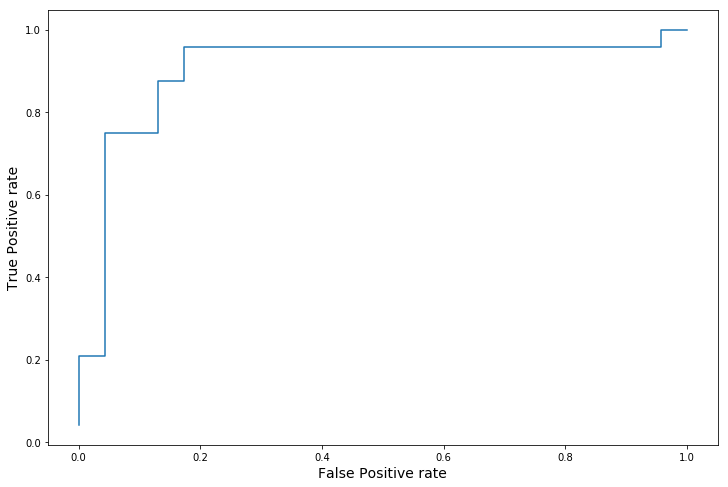

auc = 0.9057971014492754


,False Positive rate (fixed),False Negative rate
0,0.10,0.250000
1,0.15,0.125000
2,0.20,0.041667
3,0.30,0.041667


,False Positive rate (fixed),Threshold,False Positives indexes,False Negatives indexes
0,0.10,0.808359,P093,"P022, P024, P038, P039, P049, P064, P073"
1,0.15,0.630529,"P008, P093, P108","P022, P038, P049, P073"
2,0.20,0.468542,"P008, P036, P093, P108","P022, P049"
3,0.30,0.468542,"P008, P036, P093, P108","P022, P049"


,frequency
fusiform_ThickStd_l,47
Left-VentralDC_normRange,47
Right-Amygdala_Volume_mm3,47
Right-Amygdala_NVoxels,47
Right-Cerebellum-White-Matter_normMax,47
caudalanteriorcingulate_ThickStd_l,47
transversetemporal_FoldInd_r,47
Right-Pallidum_normMin,47
entorhinal_ThickStd_l,47
transversetemporal_GausCurv_l,47


Pipeline(memory=None,
     steps=[('Fill_NaN', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), ('StdScaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('dim_reduction', SelectNFeaturesFromModel(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=Tr...alty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])


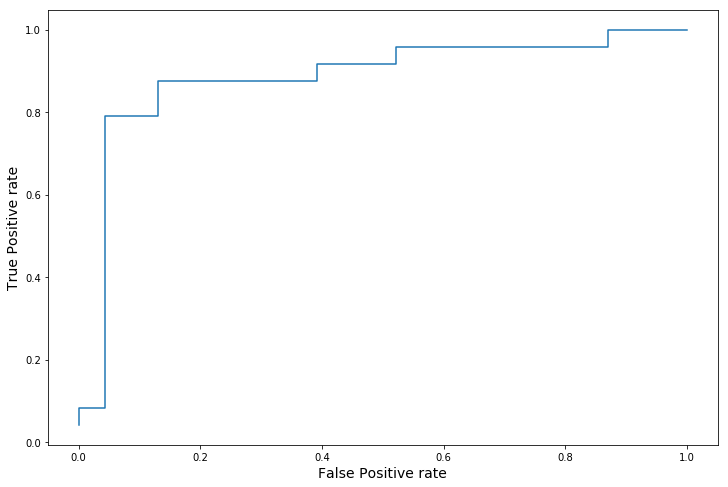

auc = 0.8840579710144928


,False Positive rate (fixed),False Negative rate
0,0.10,0.208333
1,0.15,0.125000
2,0.20,0.125000
3,0.30,0.125000


,False Positive rate (fixed),Threshold,False Positives indexes,False Negatives indexes
0,0.10,0.501534,P093,"P022, P024, P027, P038, P049, P073"
1,0.15,0.488190,"P036, P037, P093","P022, P024, P038, P049"
2,0.20,0.488190,"P036, P037, P093","P022, P024, P038, P049"
3,0.30,0.488190,"P036, P037, P093","P022, P024, P038, P049"


,frequency
fusiform_ThickStd_l,47
pericalcarine_FoldInd_r,47
Left-choroid-plexus_normStdDev,47
temporalpole_SurfArea_l,47
Right-Cerebellum-Cortex_normStdDev,47
Brain-Stem_normStdDev,47
Unnamed: 0,47
medialorbitofrontal_ThickStd_r,47
Left-Amygdala_NVoxels,47
Right-Pallidum_normRange,47


Pipeline(memory=None,
     steps=[('Fill_NaN', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), ('StdScaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('dim_reduction', SelectNFeaturesFromModel(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=Tr...timators=150, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False))])


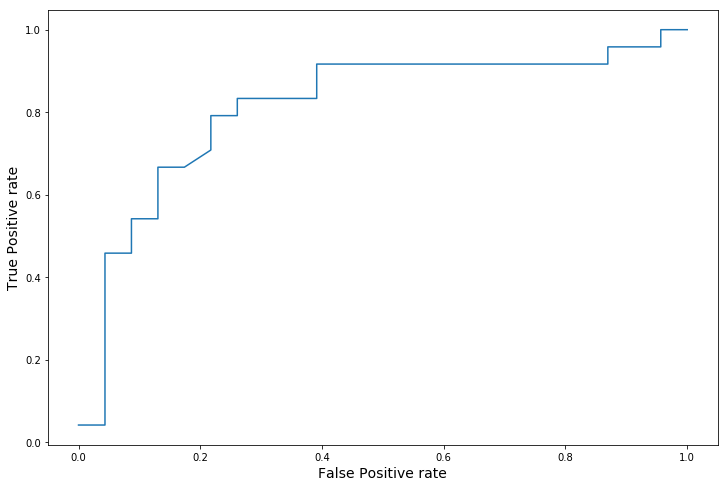

auc = 0.8125


,False Positive rate (fixed),False Negative rate
0,0.10,0.458333
1,0.15,0.333333
2,0.20,0.333333
3,0.30,0.166667


,False Positive rate (fixed),Threshold,False Positives indexes,False Negatives indexes
0,0.10,0.666667,"P037, P093","P022, P024, P027, P038, P039, P045, P049, P056, P064, P073, P076, P105"
1,0.15,0.586667,"P037, P051, P093","P022, P024, P038, P039, P045, P049, P056, P073, P076"
2,0.20,0.560000,"P037, P051, P093","P022, P024, P038, P039, P049, P056, P073, P076"
3,0.30,0.486667,"P013, P037, P046, P051, P090, P093","P022, P024, P038, P049, P073"


,frequency
fusiform_ThickStd_l,47
Left-VentralDC_normRange,47
Right-Amygdala_Volume_mm3,47
Right-Amygdala_NVoxels,47
Right-Cerebellum-White-Matter_normMax,47
caudalanteriorcingulate_ThickStd_l,47
transversetemporal_FoldInd_r,47
Right-Pallidum_normMin,47
entorhinal_ThickStd_l,47
transversetemporal_GausCurv_l,47


Pipeline(memory=None,
     steps=[('Fill_NaN', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), ('StdScaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('dim_reduction', SelectNFeaturesFromModel(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=Tr...ski',
           metric_params=None, n_jobs=1, n_neighbors=14, p=2,
           weights='distance'))])


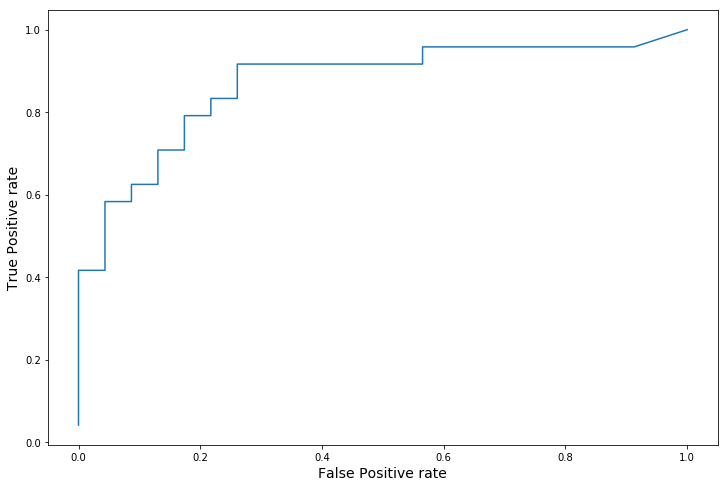

auc = 0.8695652173913044


,False Positive rate (fixed),False Negative rate
0,0.10,0.375000
1,0.15,0.291667
2,0.20,0.208333
3,0.30,0.083333


,False Positive rate (fixed),Threshold,False Positives indexes,False Negatives indexes
0,0.10,0.505648,"P036, P093","P022, P024, P025, P038, P039, P049, P056, P064, P073, P105"
1,0.15,0.421769,"P008, P036, P093","P022, P024, P025, P038, P049, P056, P064, P073"
2,0.20,0.365363,"P008, P036, P051, P093","P022, P024, P049, P056, P064, P073"
3,0.30,0.291208,"P008, P013, P036, P051, P093, P108","P022, P024, P049"


,frequency
fusiform_ThickStd_l,47
Left-VentralDC_normRange,47
Right-Amygdala_Volume_mm3,47
Right-Amygdala_NVoxels,47
Right-Cerebellum-White-Matter_normMax,47
caudalanteriorcingulate_ThickStd_l,47
transversetemporal_FoldInd_r,47
Right-Pallidum_normMin,47
entorhinal_ThickStd_l,47
transversetemporal_GausCurv_l,47


In [80]:
for i in range(len(best_model_l)):
    print(best_model_l[i])
    fpr, tpr, t = plot_roc_curve(y, probas_l[i], idx)
    get_fpr_fnr(fpr, tpr)
    get_incorrectly_classified(y, probas_l[i], idx, fpr, t)
    display(features_l[i].iloc[:10])

In [81]:
all_features, frequent_features, common_frequent_features = get_frequent_features(features_l, classifiers_l, y, p=0.7)
display(frequent_features.iloc[:30])
print("common_frequent_features: " + ", ".join(common_frequent_features))

,feature
Right-Cerebellum-White-Matter_normRange,4
cuneus_MeanCurv_l,4
CC_Mid_Posterior_normRange,4
Right-Cerebellum-White-Matter_normMax,4
Unnamed: 0,4
Right-Amygdala_Volume_mm3,4
CC_Central_normStdDev,4
Left-VentralDC_normRange,4
Left-Cerebellum-White-Matter_NVoxels,4
Right-Inf-Lat-Vent_normStdDev,4


common_frequent_features: Right-Cerebellum-White-Matter_normRange, cuneus_MeanCurv_l, CC_Mid_Posterior_normRange, Right-Cerebellum-White-Matter_normMax, Unnamed: 0, Right-Amygdala_Volume_mm3, CC_Central_normStdDev, Left-VentralDC_normRange, Left-Cerebellum-White-Matter_NVoxels, Right-Inf-Lat-Vent_normStdDev, bankssts_GausCurv_r, Left-Thalamus-Proper_Volume_mm3, pericalcarine_FoldInd_r, medialorbitofrontal_ThickStd_r, Brain-Stem_normStdDev, Right-Pallidum_normRange, CC_Mid_Posterior_normStdDev, transversetemporal_GausCurv_l, Left-Caudate_normRange, entorhinal_ThickStd_l, Left-Cerebellum-Cortex_normStdDev, inferiortemporal_GausCurv_l, Right-Amygdala_NVoxels, caudalanteriorcingulate_ThickStd_l, Right-Caudate_normMean, inferiortemporal_MeanCurv_l, Left-VentralDC_normMin, transversetemporal_NumVert_r, parsorbitalis_SurfArea_r, postcentral_FoldInd_r, Right-Pallidum_normMin, CC_Mid_Posterior_normMin, parsorbitalis_NumVert_r, frontalpole_ThickAvg_l, Left-Lateral-Ventricle_normStdDev, Left-Pall

In [ ]:
all_incorr_classified, common_false_positives, common_false_negatives = get_frequent_indexes(probas_l, classifiers_l, y, idx, show=False)
print('False positives for more than 3 clsf',common_false_positives)
print('False negatives for more than 3 clsf',common_false_negatives)

False positives for more than 3 clsf P036, P093
False negatives for more than 3 clsf P022, P024, P038, P039, P049, P064, P073


### 9. MRI positive / MRI negative

In [ ]:
mri_data

In [ ]:
n_splits = 5
problem = "Pos_Neg"
problem_labels = "MRIPositive/Negative "
pos_label = label_to_idx["Positive"]
idx = Pos_Neg_idx
X, y = mri_data[idx], pd.Series(labels[idx][problem_labels] == pos_label, dtype=int)

best_model_mri_Pos_Neg, grid_cv_svc_mri_Pos_Neg, grid_cv_lr_mri_Pos_Neg, grid_cv_rfc_mri_Pos_Neg, grid_cv_knn_mri_Pos_Neg = train_grid_cv(
    X, y, n_splits=n_splits, n_repeats=5, scoring=scoring, random_state=42, n_jobs=1)

Target distribution: 
0    26
1    17
Name: MRIPositive/Negative , dtype: int64 

Training SVC...


In [ ]:
grid_cv_l = [grid_cv_svc_mri_Pos_Neg, grid_cv_lr_mri_Pos_Neg, grid_cv_rfc_mri_Pos_Neg, grid_cv_knn_mri_Pos_Neg]
best_model_l = [x.best_estimator_ for x in grid_cv_l]
for i, clf in enumerate(classifiers_l):
    save_model(best_model_l[i], "T1_sMRI_{}_best_{}.pkl".format(problem, clf))
save_model(best_model_Pos_Neg, "T1_sMRI_{}.pkl".format(problem))    
    
probas_l = [repeated_cross_val_predict_proba(best_model, X, y, cv=LeaveOneOut(), file="{}_probas_mri_{}.csv".format(classifiers_l[i], problem)) for i, best_model in enumerate(best_model_l)]
feature_sets_l = [get_feature_sets_on_cross_val(X, y, best_model, cv=LeaveOneOut()) for best_model in best_model_l]
features_l = [pd.DataFrame(pd.DataFrame(data=feature_set).stack().reset_index(drop=True).value_counts(), columns=['frequency']) for feature_set in feature_sets_l]

In [ ]:
for i in range(len(best_model_l)):
    print(best_model_l[i])
    fpr, tpr, t = plot_roc_curve(y, probas_l[i], idx)
    get_fpr_fnr(fpr, tpr)
    get_incorrectly_classified(y, probas_l[i], idx, fpr, t)
    display(features_l[i].iloc[:10])

In [ ]:
all_features, frequent_features, common_frequent_features = get_frequent_features(features_l, classifiers_l, y, p=0.7)
display(frequent_features.iloc[:30])
print("common_frequent_features: " + ", ".join(common_frequent_features))

In [ ]:
all_incorr_classified, common_false_positives, common_false_negatives = get_frequent_indexes(probas_l, classifiers_l, y, idx, show=False)
print('False positives for more than 3 clsf',common_false_positives)
print('False negatives for more than 3 clsf',common_false_negatives)

In [ ]:
#without LLE and PCA
n_splits = 5
X, y = mri_data[Pos_Neg_idx], labels[Pos_Neg_idx]["MRIPositive/Negative "]

best_model_mri_Pos_Neg, grid_cv_svc_mri_Pos_Neg, grid_cv_lr_mri_Pos_Neg, grid_cv_rfc_mri_Pos_Neg, grid_cv_knn_mri_Pos_Neg = train_grid_cv(
    X, y, n_splits=n_splits, n_repeats=5, scoring=scoring, random_state=42, n_jobs=-1)

cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=10, random_state=42)
pos_label = label_to_idx["Positive"]

scores_mri_Pos_Neg = cross_val_score(best_model_mri_Pos_Neg, X, pd.Series(y == pos_label, dtype=int), cv=cv, scoring=scoring)
print("mean =", scores_mri_Pos_Neg.mean())
print("std =", scores_mri_Pos_Neg.std())
labels_mri_Pos_Neg = repeated_cross_val_predict(best_model_mri_Pos_Neg, X, y, cv=LeaveOneOut(), file="labels_mri_Pos_Neg.csv")

save_model(grid_cv_svc_mri_Pos_Neg, "T1_sMRI_Positive_Negative_best_svc.pkl")
save_model(grid_cv_lr_mri_Pos_Neg, "T1_sMRI_Positive_Negative_best_lr.pkl")
save_model(grid_cv_rfc_mri_Pos_Neg, "T1_sMRI_Positive_Negative_best_rfc.pkl")
save_model(grid_cv_knn_mri_Pos_Neg, "T1_sMRI_Positive_Negative_best_knn.pkl")
save_model(best_model_mri_Pos_Neg, "T1_sMRI_Positive_Negative.pkl")

probas_Pos_Neg = repeated_cross_val_predict_proba(best_model_mri_Pos_Neg, X, y, cv=LeaveOneOut(), pos_label=pos_label, file="probas_mri_Pos_Neg.csv")

### 10. TLE positive / control

Target distribution: 
0    25
1    16
Name: TLEPositive/C, dtype: int64 

Training SVC...
(training took 174.0832715034485s)

Training LR...
(training took 46.4715781211853s)

Training RFC...
(training took 113.04625940322876s)

Training KNN...
(training took 112.80327606201172s)

Scoring: roc_auc


,best parameters,best dim. reduction method,mean,std
classifier,,,,
SVC,"classifier__C = 1, classifier__gamma = 0.01, classifier__kernel = rbf","SelectNFeaturesFromModel(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',\n max_depth=None, max_fe...",0.754390,0.170062
LR,"classifier__C = 0.0001, classifier__penalty = l2","SelectNFeaturesFromModel(estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',\n max_depth=None, max_feat...",0.735041,0.187477
RFC,classifier__n_estimators = 190,"SelectKBest(k=20, score_func=<function ttest_ind at 0x000001C4D7D24B70>)",0.735285,0.151018
KNN,"classifier__n_neighbors = 14, classifier__p = 2, classifier__weights = uniform","SelectNFeaturesFromModel(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',\n max_depth=None, max_fe...",0.739675,0.145720


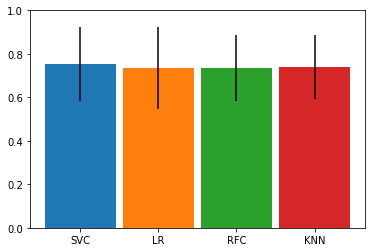

Best model: 
SVC
classifier__C = 1
classifier__gamma = 0.01
classifier__kernel = rbf
dim_reduction = SelectNFeaturesFromModel(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
             n_selected=20, prefit=False)


In [36]:
n_splits = 5
problem = "TLEPos_C"
problem_labels = "TLEPositive/C"
pos_label = label_to_idx["TLEPositive"]
idx = TLEPos_C_idx
X, y = mri_data[idx], pd.Series(labels[idx][problem_labels] == pos_label, dtype=int)

best_model_mri_TLEPos_C, grid_cv_svc_mri_TLEPos_C, grid_cv_lr_mri_TLEPos_C, grid_cv_rfc_mri_TLEPos_C, grid_cv_knn_mri_TLEPos_C= train_grid_cv(
    X, y, n_splits=n_splits, n_repeats=5, scoring=scoring, random_state=42, n_jobs=1)

In [37]:
grid_cv_l = [grid_cv_svc_mri_TLEPos_C, grid_cv_lr_mri_TLEPos_C, grid_cv_rfc_mri_TLEPos_C, grid_cv_knn_mri_TLEPos_C]
best_model_l = [x.best_estimator_ for x in grid_cv_l]
for i, clf in enumerate(classifiers_l):
    save_model(best_model_l[i], "T1_sMRI_{}_best_{}.pkl".format(problem, clf))
save_model(best_model_mri_TLEPos_C, "T1_sMRI_{}.pkl".format(problem))    
    
probas_l = [repeated_cross_val_predict_proba(best_model, X, y, cv=LeaveOneOut(), file="{}_probas_mri_{}.csv".format(classifiers_l[i], problem)) for i, best_model in enumerate(best_model_l)]
feature_sets_l = [get_feature_sets_on_cross_val(X, y, best_model, cv=LeaveOneOut()) for best_model in best_model_l]
features_l = [pd.DataFrame(pd.DataFrame(data=feature_set).stack().reset_index(drop=True).value_counts(), columns=['frequency']) for feature_set in feature_sets_l]

41it [00:06,  6.65it/s]
41it [00:05,  6.97it/s]
41it [00:11,  3.60it/s]
41it [00:06,  6.74it/s]
41it [00:06,  6.30it/s]
41it [00:04,  8.22it/s]
41it [00:07,  5.29it/s]
41it [00:05,  7.23it/s]


Pipeline(memory=None,
     steps=[('Fill_NaN', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), ('StdScaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('dim_reduction', SelectNFeaturesFromModel(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini...bf',
  max_iter=-1, probability=True, random_state=42, shrinking=True,
  tol=0.001, verbose=False))])


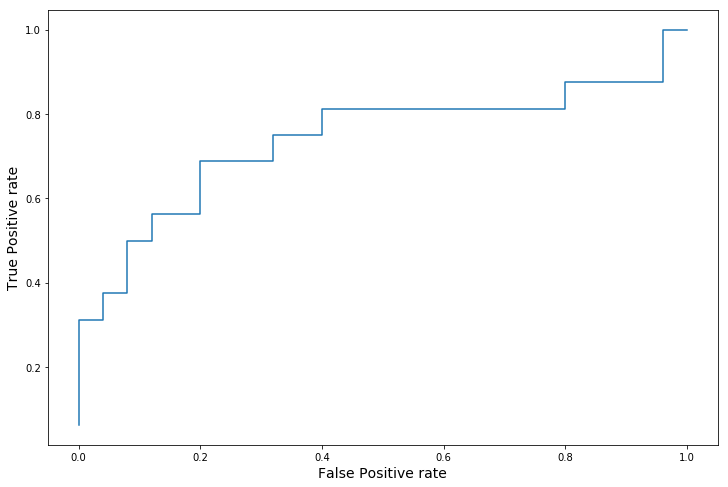

auc = 0.74


,False Positive rate (fixed),False Negative rate
0,0.10,0.5000
1,0.15,0.4375
2,0.20,0.3125
3,0.30,0.3125


,False Positive rate (fixed),Threshold,False Positives indexes,False Negatives indexes
0,0.10,0.654566,"P077, P106","P011, P024, P027, P038, P039, P044, P049, P057, P074"
1,0.15,0.489406,"P077, P093, P106","P011, P024, P027, P038, P044, P049, P057, P074"
2,0.20,0.363404,"P046, P051, P077, P093, P106","P011, P024, P038, P044, P049, P057"
3,0.30,0.363404,"P046, P051, P077, P093, P106","P011, P024, P038, P044, P049, P057"


,frequency
frontalpole_SurfArea_r,41
inferiorparietal_GrayVol_l,41
superiorfrontal_GrayVol_r,40
inferiortemporal_ThickAvg_l,34
insula_CurvInd_r,32
superiorparietal_ThickAvg_r,29
precuneus_ThickStd_r,29
parsopercularis_MeanCurv_r,27
Left-Cerebellum-White-Matter_Volume_mm3,27
inferiorparietal_SurfArea_r,26


Pipeline(memory=None,
     steps=[('Fill_NaN', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), ('StdScaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('dim_reduction', SelectNFeaturesFromModel(estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini'...alty='l2', random_state=42,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))])


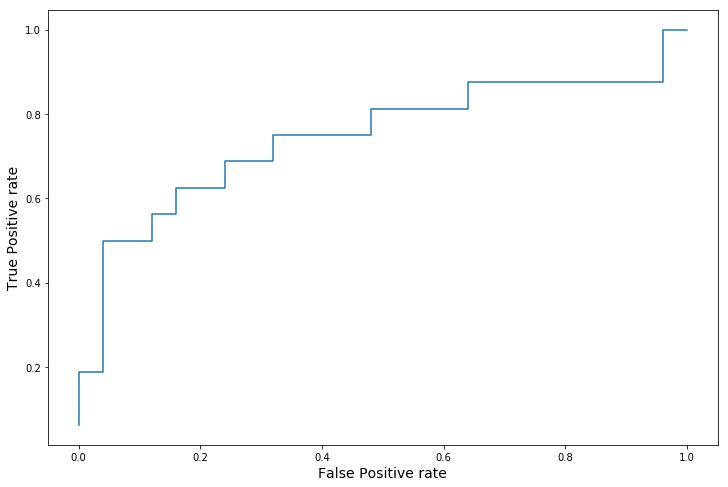

auc = 0.745


,False Positive rate (fixed),False Negative rate
0,0.10,0.5000
1,0.15,0.4375
2,0.20,0.3750
3,0.30,0.3125


,False Positive rate (fixed),Threshold,False Positives indexes,False Negatives indexes
0,0.10,0.501117,P077,"P011, P024, P027, P038, P044, P049, P057, P074, P079"
1,0.15,0.500379,"P051, P077, P106","P011, P024, P027, P038, P044, P049, P057, P074"
2,0.20,0.499787,"P036, P051, P077, P106","P011, P027, P038, P044, P049, P057, P074"
3,0.30,0.499714,"P018, P036, P051, P077, P093, P106","P011, P027, P038, P044, P049, P057"


,frequency
Right-Cerebellum-White-Matter_NVoxels,41
superiorfrontal_GrayVol_r,41
inferiortemporal_ThickAvg_l,41
Left-Cerebellum-White-Matter_Volume_mm3,39
frontalpole_SurfArea_r,35
Left-Cerebellum-Cortex_normStdDev,35
insula_ThickStd_r,34
inferiortemporal_MeanCurv_l,33
caudalmiddlefrontal_ThickAvg_l,33
Left-Accumbens-area_normRange,30


Pipeline(memory=None,
     steps=[('Fill_NaN', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), ('StdScaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('dim_reduction', SelectKBest(k=20, score_func=<function ttest_ind at 0x000001C4D7D24B70>)), ('classifier', RandomForestClassi...timators=190, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False))])


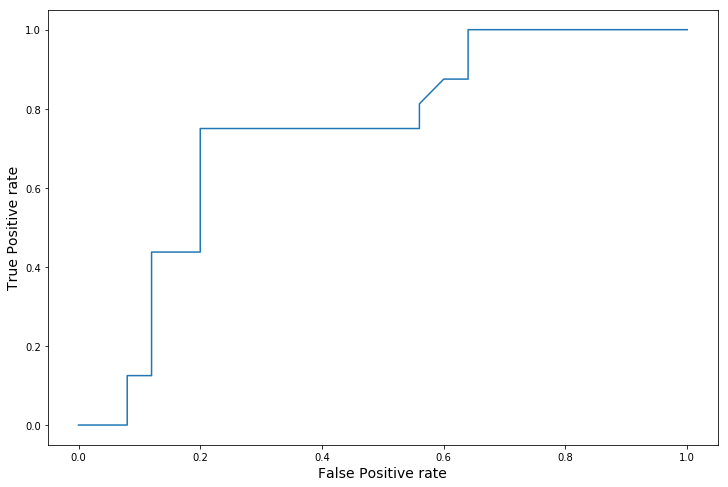

auc = 0.73875


,False Positive rate (fixed),False Negative rate
0,0.10,0.8750
1,0.15,0.5625
2,0.20,0.2500
3,0.30,0.2500


,False Positive rate (fixed),Threshold,False Positives indexes,False Negatives indexes
0,0.10,0.710526,"P051, P093","P003, P011, P024, P025, P026, P027, P038, P039, P049, P055, P057, P064, P074, P079, P105"
1,0.15,0.568421,"P051, P077, P093","P026, P027, P039, P049, P055, P057, P064, P074, P079, P105"
2,0.20,0.463158,"P013, P051, P077, P085, P093","P026, P049, P057, P074, P079, P105"
3,0.30,0.415789,"P013, P051, P077, P085, P093","P026, P049, P074, P079"


,frequency
CC_Mid_Anterior_normMean,24
Left-Hippocampus_normMean,23
precuneus_ThickAvg_l,18
caudalmiddlefrontal_MeanCurv_l,18
Left-Cerebellum-Cortex_normMean,17
Left-Cerebellum-White-Matter_normMean,17
Left-Caudate_normMean,16
lateraloccipital_ThickAvg_l,14
precuneus_MeanCurv_l,13
Right-Accumbens-area_normMean,13


Pipeline(memory=None,
     steps=[('Fill_NaN', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), ('StdScaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('dim_reduction', SelectNFeaturesFromModel(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini...wski',
           metric_params=None, n_jobs=1, n_neighbors=14, p=2,
           weights='uniform'))])


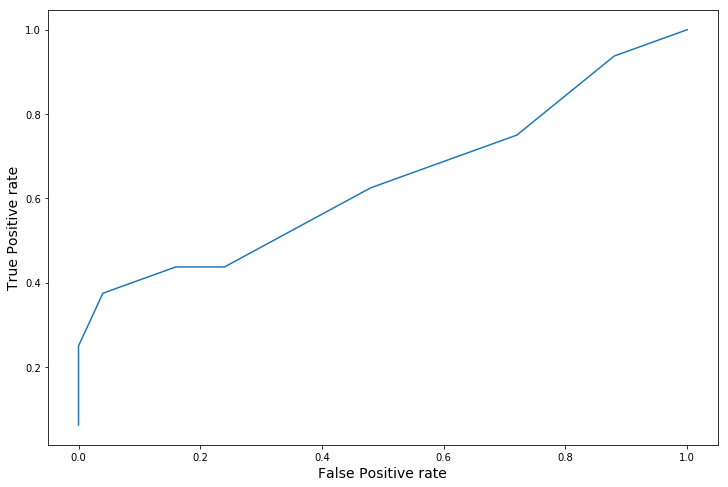

auc = 0.64


,False Positive rate (fixed),False Negative rate
0,0.10,0.6250
1,0.15,0.6250
2,0.20,0.5625
3,0.30,0.5625


,False Positive rate (fixed),Threshold,False Positives indexes,False Negatives indexes
0,0.10,0.428571,,"P003, P011, P024, P026, P027, P038, P039, P044, P049, P057, P064, P074"
1,0.15,0.428571,,"P003, P011, P024, P026, P027, P038, P039, P044, P049, P057, P064, P074"
2,0.20,0.357143,P106,"P003, P011, P024, P027, P038, P039, P044, P049, P057, P074"
3,0.30,0.285714,"P046, P077, P106, P108","P011, P024, P027, P038, P039, P044, P049, P057, P074"


,frequency
frontalpole_SurfArea_r,41
inferiorparietal_GrayVol_l,41
superiorfrontal_GrayVol_r,40
inferiortemporal_ThickAvg_l,34
insula_CurvInd_r,32
superiorparietal_ThickAvg_r,29
precuneus_ThickStd_r,29
parsopercularis_MeanCurv_r,27
Left-Cerebellum-White-Matter_Volume_mm3,27
inferiorparietal_SurfArea_r,26


In [38]:
for i in range(len(best_model_l)):
    print(best_model_l[i])
    fpr, tpr, t = plot_roc_curve(y, probas_l[i], idx)
    get_fpr_fnr(fpr, tpr)
    get_incorrectly_classified(y, probas_l[i], idx, fpr, t)
    display(features_l[i].iloc[:10])

In [39]:
all_features, frequent_features, common_frequent_features = get_frequent_features(features_l, classifiers_l, y, p=0.7)
display(frequent_features.iloc[:30])
print("common_frequent_features: " + ", ".join(common_frequent_features))
all_incorr_classified, common_false_positives, common_false_negatives = get_frequent_indexes(probas_l, classifiers_l, y, idx, show=False)
print('False positives for more than 3 clsf',common_false_positives)
print('False negatives for more than 3 clsf',common_false_negatives)

,feature
inferiortemporal_ThickAvg_l,3
frontalpole_SurfArea_r,3
superiorfrontal_GrayVol_r,3
insula_CurvInd_r,2
inferiorparietal_GrayVol_l,2
precuneus_ThickStd_r,2
superiorparietal_ThickAvg_r,2
caudalmiddlefrontal_ThickAvg_l,1
Right-Cerebellum-White-Matter_NVoxels,1
inferiorparietal_MeanCurv_r,1


common_frequent_features: inferiortemporal_ThickAvg_l, frontalpole_SurfArea_r, superiorfrontal_GrayVol_r
False positives for more than 3 clsf P051, P077, P093, P106
False negatives for more than 3 clsf P011, P024, P027, P038, P039, P044, P049, P057, P074


### 11. TLE negative / control

Target distribution: 
0    25
1    14
Name: TLENegative/C, dtype: int64 

Training SVC...
(training took 107.18209648132324s)

Training LR...
(training took 36.773292541503906s)

Training RFC...
(training took 94.85328578948975s)

Training KNN...
(training took 76.37851786613464s)

Scoring: roc_auc


,best parameters,best dim. reduction method,mean,std
classifier,,,,
SVC,"classifier__C = 1, classifier__gamma = 0.01, classifier__kernel = rbf","SelectNFeaturesFromModel(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, ma...",0.924615,0.120248
LR,"classifier__C = 0.0001, classifier__penalty = l2","SelectNFeaturesFromModel(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, ma...",0.905641,0.144242
RFC,classifier__n_estimators = 160,"SelectNFeaturesFromModel(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, ma...",0.887778,0.107749
KNN,"classifier__n_neighbors = 11, classifier__p = 1, classifier__weights = distance","SelectNFeaturesFromModel(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, ma...",0.896325,0.133960


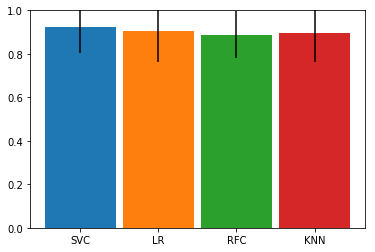

Best model: 
SVC
classifier__C = 1
classifier__gamma = 0.01
classifier__kernel = rbf
dim_reduction = SelectNFeaturesFromModel(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
             n_selected=20, prefit=False)


In [47]:
n_splits = 5
problem = "TLENeg_C"
problem_labels = "TLENegative/C"
pos_label = label_to_idx["TLENegative"]
idx = TLENeg_C_idx
X, y = mri_data[idx], pd.Series(labels[idx][problem_labels] == pos_label, dtype=int)

best_model_mri_TLENeg_C, grid_cv_svc_mri_TLENeg_C, grid_cv_lr_mri_TLENeg_C, grid_cv_rfc_mri_TLENeg_C, grid_cv_knn_mri_TLENeg_C= train_grid_cv(
    X, y, n_splits=n_splits, n_repeats=5, scoring=scoring, random_state=42, n_jobs=1)

In [48]:
grid_cv_l = [grid_cv_svc_mri_TLENeg_C, grid_cv_lr_mri_TLENeg_C, grid_cv_rfc_mri_TLENeg_C, grid_cv_knn_mri_TLENeg_C]
best_model_l = [x.best_estimator_ for x in grid_cv_l]
for i, clf in enumerate(classifiers_l):
    save_model(best_model_l[i], "T1_sMRI_{}_best_{}.pkl".format(problem, clf))
save_model(best_model_mri_TLENeg_C, "T1_sMRI_{}.pkl".format(problem))    
    
probas_l = [repeated_cross_val_predict_proba(best_model, X, y, cv=LeaveOneOut(), file="{}_probas_mri_{}.csv".format(classifiers_l[i], problem)) for i, best_model in enumerate(best_model_l)]
feature_sets_l = [get_feature_sets_on_cross_val(X, y, best_model, cv=LeaveOneOut()) for best_model in best_model_l]
features_l = [pd.DataFrame(pd.DataFrame(data=feature_set).stack().reset_index(drop=True).value_counts(), columns=['frequency']) for feature_set in feature_sets_l]

39it [00:00, 105.32it/s]
39it [00:00, 97.33it/s] 
39it [00:06,  5.88it/s]
39it [00:00, 95.96it/s] 
39it [00:00, 85.35it/s]
39it [00:00, 88.95it/s]
39it [00:06,  6.17it/s]
39it [00:00, 93.03it/s]


Pipeline(memory=None,
     steps=[('Fill_NaN', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), ('StdScaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('dim_reduction', SelectNFeaturesFromModel(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=Tr...bf',
  max_iter=-1, probability=True, random_state=42, shrinking=True,
  tol=0.001, verbose=False))])


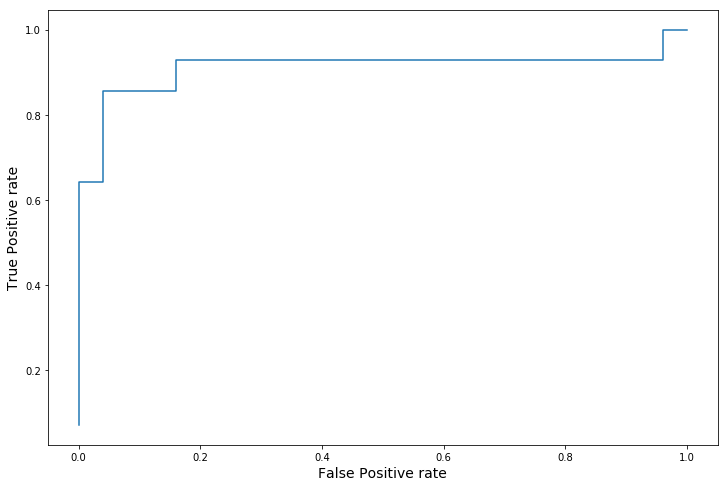

auc = 0.9114285714285714


,False Positive rate (fixed),False Negative rate
0,0.10,0.142857
1,0.15,0.142857
2,0.20,0.071429
3,0.30,0.071429


,False Positive rate (fixed),Threshold,False Positives indexes,False Negatives indexes
0,0.10,0.418036,P013,"P073, P075, P083"
1,0.15,0.418036,P013,"P073, P075, P083"
2,0.20,0.383391,"P013, P043, P098, P100","P073, P075"
3,0.30,0.383391,"P013, P043, P098, P100","P073, P075"


,frequency
insula_ThickStd_r,39
Right-Amygdala_NVoxels,39
Right-Amygdala_Volume_mm3,39
Left-Amygdala_Volume_mm3,39
parsorbitalis_ThickStd_r,39
frontalpole_FoldInd_l,39
Left-Amygdala_NVoxels,39
isthmuscingulate_MeanCurv_r,39
lingual_MeanCurv_l,39
frontalpole_CurvInd_l,39


Pipeline(memory=None,
     steps=[('Fill_NaN', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), ('StdScaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('dim_reduction', SelectNFeaturesFromModel(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=Tr...alty='l2', random_state=42,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))])


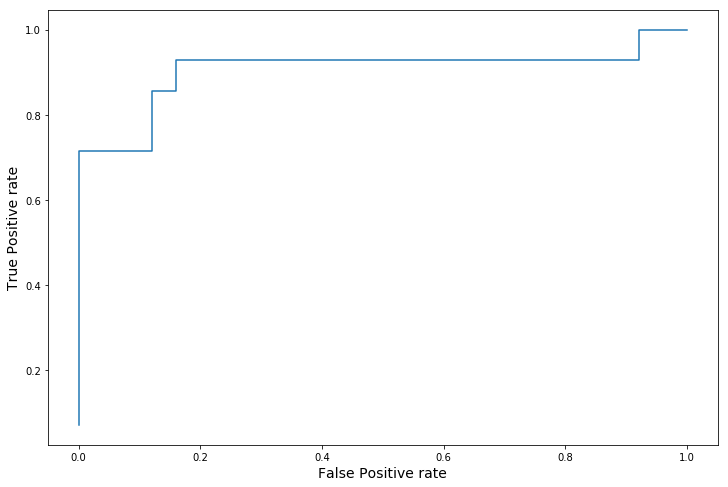

auc = 0.9057142857142857


,False Positive rate (fixed),False Negative rate
0,0.10,0.285714
1,0.15,0.142857
2,0.20,0.071429
3,0.30,0.071429


,False Positive rate (fixed),Threshold,False Positives indexes,False Negatives indexes
0,0.10,0.501036,,"P073, P075, P076, P083, P088"
1,0.15,0.500281,"P013, P043, P098","P073, P075, P083"
2,0.20,0.500090,"P013, P043, P098, P100","P075, P083"
3,0.30,0.500090,"P013, P043, P098, P100","P075, P083"


,frequency
insula_ThickStd_r,39
Right-Amygdala_NVoxels,39
Right-Amygdala_Volume_mm3,39
Left-Amygdala_Volume_mm3,39
parsorbitalis_ThickStd_r,39
frontalpole_FoldInd_l,39
Left-Amygdala_NVoxels,39
isthmuscingulate_MeanCurv_r,39
lingual_MeanCurv_l,39
frontalpole_CurvInd_l,39


Pipeline(memory=None,
     steps=[('Fill_NaN', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), ('StdScaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('dim_reduction', SelectNFeaturesFromModel(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=Tr...timators=160, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False))])


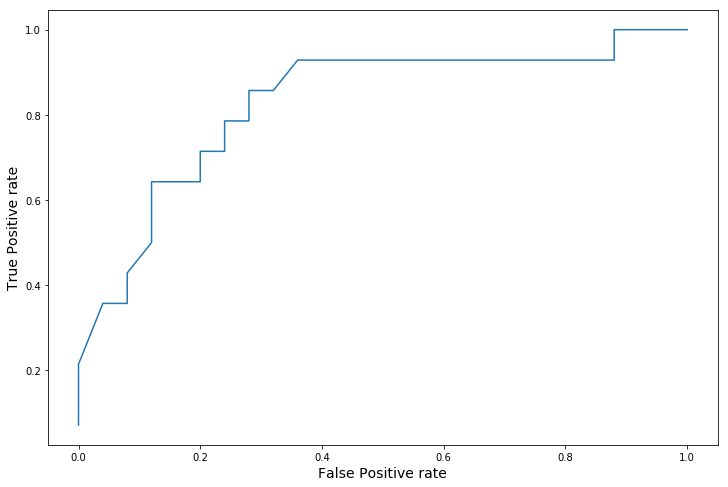

auc = 0.8285714285714286


,False Positive rate (fixed),False Negative rate
0,0.10,0.571429
1,0.15,0.357143
2,0.20,0.285714
3,0.30,0.142857


,False Positive rate (fixed),Threshold,False Positives indexes,False Negatives indexes
0,0.10,0.54375,"P043, P077","P022, P032, P045, P056, P073, P075, P076, P083, P088"
1,0.15,0.43750,"P043, P077, P100","P022, P056, P075, P076, P083, P088"
2,0.20,0.34375,"P013, P043, P077, P098, P100","P022, P075, P076, P083, P088"
3,0.30,0.30625,"P013, P043, P077, P082, P098, P100, P107","P075, P076, P088"


,frequency
insula_ThickStd_r,39
Right-Amygdala_NVoxels,39
Right-Amygdala_Volume_mm3,39
Left-Amygdala_Volume_mm3,39
parsorbitalis_ThickStd_r,39
frontalpole_FoldInd_l,39
Left-Amygdala_NVoxels,39
isthmuscingulate_MeanCurv_r,39
lingual_MeanCurv_l,39
frontalpole_CurvInd_l,39


Pipeline(memory=None,
     steps=[('Fill_NaN', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), ('StdScaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('dim_reduction', SelectNFeaturesFromModel(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=Tr...ski',
           metric_params=None, n_jobs=1, n_neighbors=11, p=1,
           weights='distance'))])


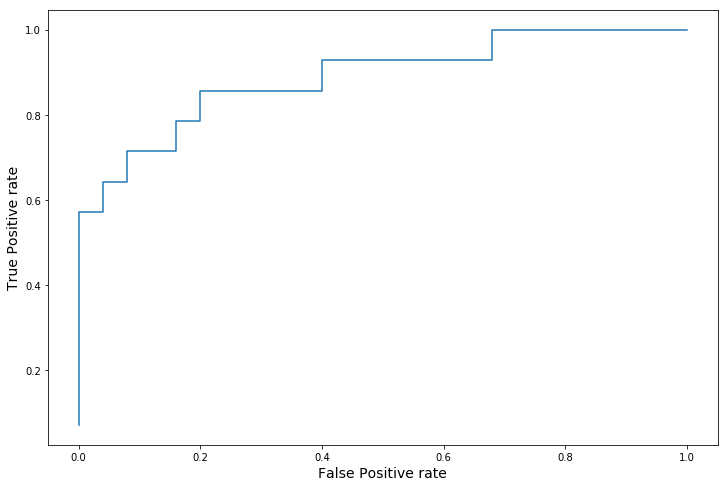

auc = 0.8885714285714286


,False Positive rate (fixed),False Negative rate
0,0.10,0.285714
1,0.15,0.285714
2,0.20,0.142857
3,0.30,0.142857


,False Positive rate (fixed),Threshold,False Positives indexes,False Negatives indexes
0,0.10,0.344582,"P013, P043","P073, P075, P076, P083, P088"
1,0.15,0.344582,"P013, P043","P073, P075, P076, P083, P088"
2,0.20,0.271043,"P013, P043, P077, P098, P100","P073, P075, P083"
3,0.30,0.271043,"P013, P043, P077, P098, P100","P073, P075, P083"


,frequency
insula_ThickStd_r,39
Right-Amygdala_NVoxels,39
Right-Amygdala_Volume_mm3,39
Left-Amygdala_Volume_mm3,39
parsorbitalis_ThickStd_r,39
frontalpole_FoldInd_l,39
Left-Amygdala_NVoxels,39
isthmuscingulate_MeanCurv_r,39
lingual_MeanCurv_l,39
frontalpole_CurvInd_l,39


In [49]:
for i in range(len(best_model_l)):
    print(best_model_l[i])
    fpr, tpr, t = plot_roc_curve(y, probas_l[i], idx)
    get_fpr_fnr(fpr, tpr)
    get_incorrectly_classified(y, probas_l[i], idx, fpr, t)
    display(features_l[i].iloc[:10])

In [50]:
all_features, frequent_features, common_frequent_features = get_frequent_features(features_l, classifiers_l, y, p=0.7)
display(frequent_features.iloc[:30])
print("common_frequent_features: " + ", ".join(common_frequent_features))
all_incorr_classified, common_false_positives, common_false_negatives = get_frequent_indexes(probas_l, classifiers_l, y, idx, show=False)
print('False positives for more than 3 clsf',common_false_positives)
print('False negatives for more than 3 clsf',common_false_negatives)

,feature
parsorbitalis_ThickStd_r,4
isthmuscingulate_MeanCurv_r,4
parsorbitalis_CurvInd_r,4
frontalpole_ThickAvg_l,4
lingual_MeanCurv_l,4
Left-choroid-plexus_NVoxels,4
frontalpole_FoldInd_l,4
frontalpole_CurvInd_l,4
Right-Amygdala_NVoxels,4
CC_Posterior_normRange,4


common_frequent_features: parsorbitalis_ThickStd_r, isthmuscingulate_MeanCurv_r, parsorbitalis_CurvInd_r, frontalpole_ThickAvg_l, lingual_MeanCurv_l, Left-choroid-plexus_NVoxels, frontalpole_FoldInd_l, frontalpole_CurvInd_l, Right-Amygdala_NVoxels, CC_Posterior_normRange, frontalpole_GausCurv_l, parsorbitalis_GausCurv_r, parahippocampal_ThickAvg_r, insula_ThickStd_r, Left-Amygdala_NVoxels, Left-Amygdala_Volume_mm3, Right-Amygdala_Volume_mm3
False positives for more than 3 clsf P013, P043, P098, P100
False negatives for more than 3 clsf P073, P075, P076, P083, P088


### 12. Not TLE epilepsy / control

Target distribution: 
0    25
1    20
Name: NoTLE/C, dtype: int64 

Training SVC...
(training took 144.4039821624756s)

Training LR...
(training took 54.72704029083252s)

Training RFC...
(training took 145.26238012313843s)

Training KNN...
(training took 188.4788830280304s)

Scoring: roc_auc


,best parameters,best dim. reduction method,mean,std
classifier,,,,
SVC,"classifier__C = 1, classifier__gamma = 0.001, classifier__kernel = rbf","SelectKBest(k=20, score_func=<function ttest_ind at 0x000001C4D7D24B70>)",0.594,0.147865
LR,"classifier__C = 0.0001, classifier__penalty = l2","SelectKBest(k=20, score_func=<function ttest_ind at 0x000001C4D7D24B70>)",0.598,0.145245
RFC,classifier__n_estimators = 100,"SelectKBest(k=20, score_func=<function ttest_ind at 0x000001C4D7D24B70>)",0.665,0.171756
KNN,"classifier__n_neighbors = 8, classifier__p = 2, classifier__weights = uniform","SelectKBest(k=20, score_func=<function ttest_ind at 0x000001C4D7D24B70>)",0.589,0.165088


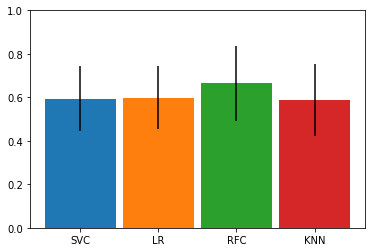

Best model: 
RFC
classifier__n_estimators = 100
dim_reduction = SelectKBest(k=20, score_func=<function ttest_ind at 0x000001C4D7D24B70>)


In [51]:
n_splits = 5
problem = "NoTLE_C"
problem_labels = "NoTLE/C"
pos_label = label_to_idx["NoTLE"]
idx = NoTLE_C_idx
X, y = mri_data[idx], pd.Series(labels[idx][problem_labels] == pos_label, dtype=int)

best_model_mri_NoTLE_C, grid_cv_svc_mri_NoTLE_C, grid_cv_lr_mri_NoTLE_C, grid_cv_rfc_mri_NoTLE_C, grid_cv_knn_mri_NoTLE_C= train_grid_cv(
    X, y, n_splits=n_splits, n_repeats=5, scoring=scoring, random_state=42, n_jobs=1)

In [52]:
grid_cv_l = [grid_cv_svc_mri_NoTLE_C, grid_cv_lr_mri_NoTLE_C, grid_cv_rfc_mri_NoTLE_C, grid_cv_knn_mri_NoTLE_C]
best_model_l = [x.best_estimator_ for x in grid_cv_l]
for i, clf in enumerate(classifiers_l):
    save_model(best_model_l[i], "T1_sMRI_{}_best_{}.pkl".format(problem, clf))
save_model(best_model_mri_NoTLE_C, "T1_sMRI_{}.pkl".format(problem))    
    
probas_l = [repeated_cross_val_predict_proba(best_model, X, y, cv=LeaveOneOut(), file="{}_probas_mri_{}.csv".format(classifiers_l[i], problem)) for i, best_model in enumerate(best_model_l)]
feature_sets_l = [get_feature_sets_on_cross_val(X, y, best_model, cv=LeaveOneOut()) for best_model in best_model_l]
features_l = [pd.DataFrame(pd.DataFrame(data=feature_set).stack().reset_index(drop=True).value_counts(), columns=['frequency']) for feature_set in feature_sets_l]

45it [00:00, 83.55it/s]
45it [00:00, 87.25it/s] 
45it [00:07,  6.09it/s]
45it [00:00, 96.57it/s]
45it [00:00, 82.81it/s]
45it [00:00, 93.13it/s]
45it [00:07,  6.38it/s]
45it [00:00, 94.92it/s]


Pipeline(memory=None,
     steps=[('Fill_NaN', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), ('StdScaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('dim_reduction', SelectKBest(k=20, score_func=<function ttest_ind at 0x000001C4D7D24B70>)), ('classifier', SVC(C=1, cache_siz...bf',
  max_iter=-1, probability=True, random_state=42, shrinking=True,
  tol=0.001, verbose=False))])


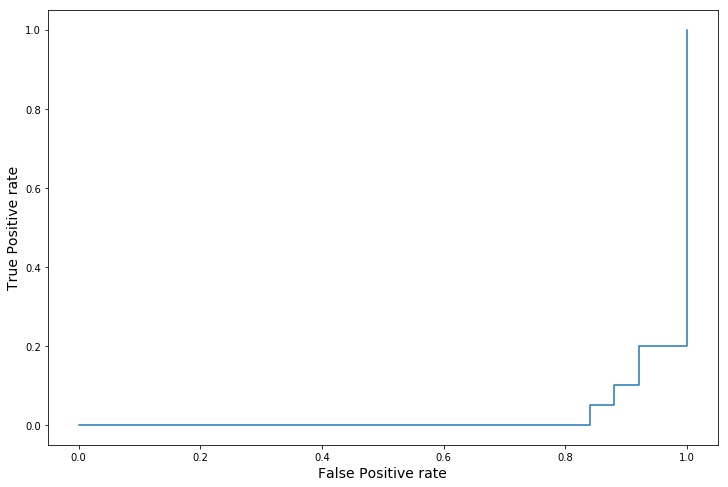

auc = 0.022


,False Positive rate (fixed),False Negative rate
0,0.10,1.0
1,0.15,1.0
2,0.20,1.0
3,0.30,1.0


,False Positive rate (fixed),Threshold,False Positives indexes,False Negatives indexes
0,0.10,0.570581,,"P002, P006, P009, P010, P015, P017, P034, P040, P050, P059, P061, P068, P072, P078, P081, P086, P092, P094, P096, P099"
1,0.15,0.570581,,"P002, P006, P009, P010, P015, P017, P034, P040, P050, P059, P061, P068, P072, P078, P081, P086, P092, P094, P096, P099"
2,0.20,0.570581,,"P002, P006, P009, P010, P015, P017, P034, P040, P050, P059, P061, P068, P072, P078, P081, P086, P092, P094, P096, P099"
3,0.30,0.570581,,"P002, P006, P009, P010, P015, P017, P034, P040, P050, P059, P061, P068, P072, P078, P081, P086, P092, P094, P096, P099"


,frequency
inferiorparietal_MeanCurv_r,45
inferiorparietal_ThickAvg_r,40
Left-Hippocampus_normMean,32
Left-Thalamus-Proper_normMean,31
superiorparietal_MeanCurv_l,31
Left-Putamen_normMean,31
Left-Caudate_normStdDev,26
Right-Amygdala_normMean,25
precuneus_ThickAvg_r,25
Brain-Stem_normMean,24


Pipeline(memory=None,
     steps=[('Fill_NaN', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), ('StdScaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('dim_reduction', SelectKBest(k=20, score_func=<function ttest_ind at 0x000001C4D7D24B70>)), ('classifier', LogisticRegression...alty='l2', random_state=42,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))])


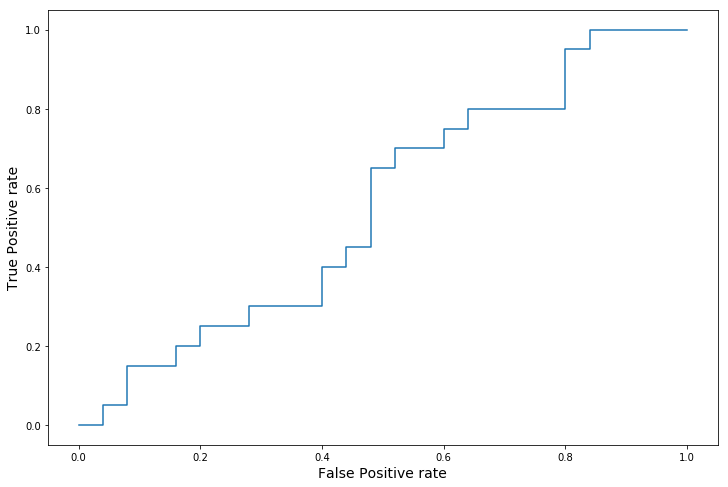

auc = 0.55


,False Positive rate (fixed),False Negative rate
0,0.10,0.85
1,0.15,0.85
2,0.20,0.75
3,0.30,0.70


,False Positive rate (fixed),Threshold,False Positives indexes,False Negatives indexes
0,0.10,0.500772,"P037, P077","P002, P006, P009, P010, P015, P017, P034, P040, P050, P059, P061, P068, P078, P081, P086, P094, P096, P099"
1,0.15,0.500772,"P037, P077","P002, P006, P009, P010, P015, P017, P034, P040, P050, P059, P061, P068, P078, P081, P086, P094, P096, P099"
2,0.20,0.500296,"P037, P077, P089, P093, P100","P002, P006, P009, P010, P015, P017, P034, P040, P050, P059, P061, P068, P078, P094, P096, P099"
3,0.30,0.500104,"P036, P037, P077, P089, P093, P100, P108","P002, P006, P009, P010, P015, P017, P034, P040, P059, P061, P068, P078, P094, P096, P099"


,frequency
inferiorparietal_MeanCurv_r,45
inferiorparietal_ThickAvg_r,40
Left-Hippocampus_normMean,32
Left-Thalamus-Proper_normMean,31
superiorparietal_MeanCurv_l,31
Left-Putamen_normMean,31
Left-Caudate_normStdDev,26
Right-Amygdala_normMean,25
precuneus_ThickAvg_r,25
Brain-Stem_normMean,24


Pipeline(memory=None,
     steps=[('Fill_NaN', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), ('StdScaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('dim_reduction', SelectKBest(k=20, score_func=<function ttest_ind at 0x000001C4D7D24B70>)), ('classifier', RandomForestClassi...timators=100, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False))])


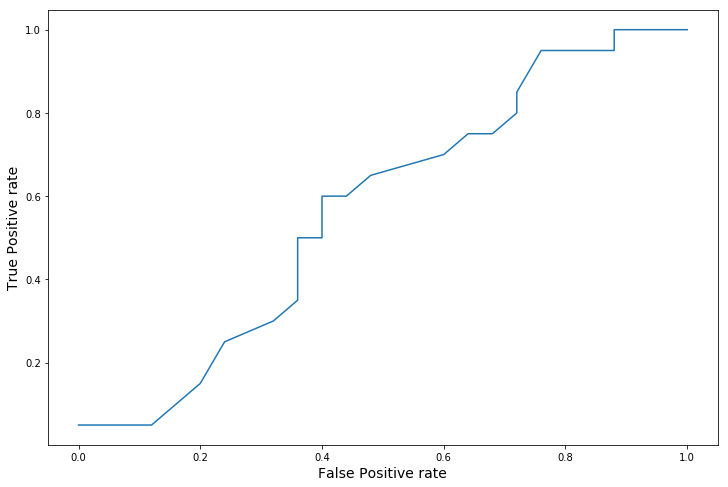

auc = 0.567


,False Positive rate (fixed),False Negative rate
0,0.10,0.95
1,0.15,0.95
2,0.20,0.85
3,0.30,0.75


,False Positive rate (fixed),Threshold,False Positives indexes,False Negatives indexes
0,0.10,0.68,,"P002, P006, P009, P010, P015, P017, P034, P040, P050, P059, P061, P068, P072, P078, P081, P086, P092, P094, P099"
1,0.15,0.67,"P082, P091","P002, P006, P009, P010, P015, P017, P034, P040, P050, P059, P061, P068, P072, P078, P081, P086, P092, P094, P099"
2,0.20,0.58,"P077, P082, P091, P098","P002, P009, P010, P015, P017, P034, P040, P050, P059, P061, P068, P072, P078, P081, P086, P092, P094, P099"
3,0.30,0.57,"P037, P077, P082, P091, P098","P002, P009, P010, P015, P017, P034, P040, P050, P059, P061, P068, P078, P081, P086, P092, P094, P099"


,frequency
inferiorparietal_MeanCurv_r,45
inferiorparietal_ThickAvg_r,40
Left-Hippocampus_normMean,32
Left-Thalamus-Proper_normMean,31
superiorparietal_MeanCurv_l,31
Left-Putamen_normMean,31
Left-Caudate_normStdDev,26
Right-Amygdala_normMean,25
precuneus_ThickAvg_r,25
Brain-Stem_normMean,24


Pipeline(memory=None,
     steps=[('Fill_NaN', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), ('StdScaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('dim_reduction', SelectKBest(k=20, score_func=<function ttest_ind at 0x000001C4D7D24B70>)), ('classifier', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=8, p=2,
           weights='uniform'))])


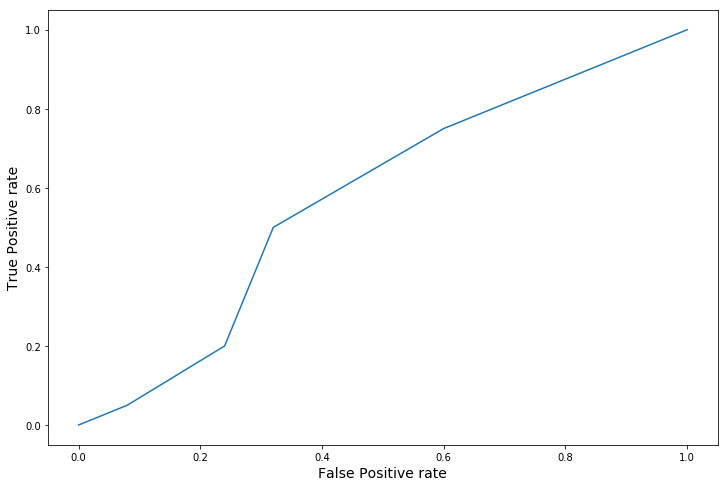

auc = 0.575


,False Positive rate (fixed),False Negative rate
0,0.10,0.95
1,0.15,0.95
2,0.20,0.95
3,0.30,0.80


,False Positive rate (fixed),Threshold,False Positives indexes,False Negatives indexes
0,0.10,0.750,,"P002, P006, P009, P010, P015, P017, P034, P040, P050, P059, P061, P068, P072, P078, P081, P086, P092, P094, P096, P099"
1,0.15,0.750,,"P002, P006, P009, P010, P015, P017, P034, P040, P050, P059, P061, P068, P072, P078, P081, P086, P092, P094, P096, P099"
2,0.20,0.750,,"P002, P006, P009, P010, P015, P017, P034, P040, P050, P059, P061, P068, P072, P078, P081, P086, P092, P094, P096, P099"
3,0.30,0.625,"P037, P107","P002, P006, P009, P010, P015, P017, P040, P050, P059, P061, P068, P072, P078, P081, P086, P092, P094, P096, P099"


,frequency
inferiorparietal_MeanCurv_r,45
inferiorparietal_ThickAvg_r,40
Left-Hippocampus_normMean,32
Left-Thalamus-Proper_normMean,31
superiorparietal_MeanCurv_l,31
Left-Putamen_normMean,31
Left-Caudate_normStdDev,26
Right-Amygdala_normMean,25
precuneus_ThickAvg_r,25
Brain-Stem_normMean,24


In [53]:
for i in range(len(best_model_l)):
    print(best_model_l[i])
    fpr, tpr, t = plot_roc_curve(y, probas_l[i], idx)
    get_fpr_fnr(fpr, tpr)
    get_incorrectly_classified(y, probas_l[i], idx, fpr, t)
    display(features_l[i].iloc[:10])

In [54]:

all_features, frequent_features, common_frequent_features = get_frequent_features(features_l, classifiers_l, y, p=0.7)
display(frequent_features.iloc[:30])
print("common_frequent_features: " + ", ".join(common_frequent_features))
all_incorr_classified, common_false_positives, common_false_negatives = get_frequent_indexes(probas_l, classifiers_l, y, idx, show=False)
print('False positives for more than 3 clsf',common_false_positives)
print('False negatives for more than 3 clsf',common_false_negatives)

,feature
inferiorparietal_ThickAvg_r,4
inferiorparietal_MeanCurv_r,4
Left-Hippocampus_normMean,4


common_frequent_features: inferiorparietal_ThickAvg_r, inferiorparietal_MeanCurv_r, Left-Hippocampus_normMean
False positives for more than 3 clsf P037
False negatives for more than 3 clsf P002, P006, P009, P010, P015, P017, P034, P040, P050, P059, P061, P068, P072, P078, P081, P086, P092, P094, P096, P099
